In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_run, replay_fig, replay_participation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## Main analysis

In [75]:
# load sessions
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
# collect epoch info
epochs_df = pd.DataFrame()
for basepath in df.basepath:
    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs.main(epoch_df)
    epoch_df["basepath"] = basepath
    epochs_df = pd.concat([epochs_df, epoch_df], ignore_index=True)

df = pd.DataFrame()
df["basepath"] = epochs_df[epochs_df.environment.str.contains("linear") & ~(epochs_df.manipulation == "mec_silencing")].basepath.unique()

In [31]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay"

batch_analysis.run(
    df,
    save_path,
    replay_run.run_all,
    parallel=True,
    traj_shuff=1000,
    verbose=True,
    place_cell_peak_mean_ratio=1,
)

100%|██████████| 130/130 [00:07<00:00, 18.30it/s]


## Load all data

In [404]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

df = replay_run.load_results(save_path)

In [5]:
df.to_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_results.csv')

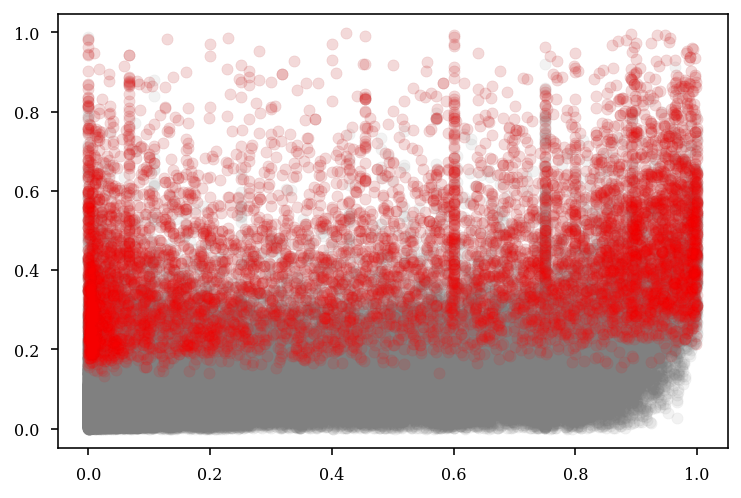

In [415]:
plt.scatter(df.r_squared, df.trajectory_score,alpha=.1,color="grey")
plt.scatter(df[df['score_pval_col_cycle'] < 0.05].r_squared, df[df['score_pval_col_cycle'] < 0.05].trajectory_score,alpha=.1,color="r")
# plt.xscale("log")
# plt.yscale("log")
# df = df[(df.decoding_r2_pval < 0.05) & (df.decoding_median_error < 30)]

## Inspect decoding quality

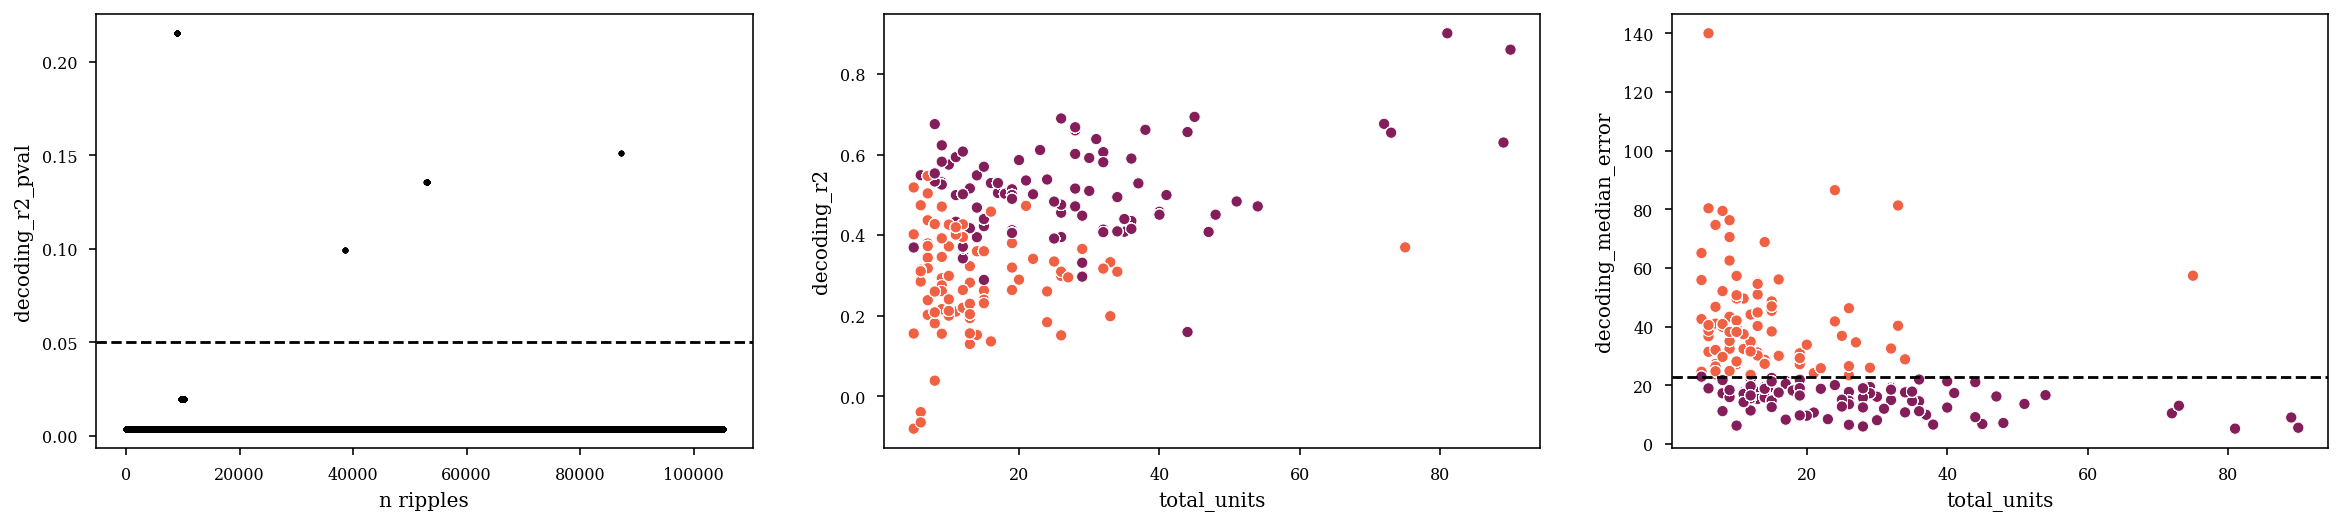

In [410]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].plot(df.decoding_r2_pval, '.k')
axs[0].set_ylabel('decoding_r2_pval')
axs[0].set_xlabel('n ripples')
axs[0].axhline(0.05, color='k', linestyle='--')

sns.scatterplot(x="total_units", y="decoding_r2",
                hue=df.decoding_median_error<23,
                data=df, ax=axs[1], legend=False, palette="rocket_r")

sns.scatterplot(x="total_units", y="decoding_median_error",
                hue=df.decoding_median_error<23,palette="rocket_r",
                data=df, ax=axs[2], legend=False)
# axs[2].legend(bbox_to_anchor=(1.1, 1.05))
axs[2].axhline(23, color='k', linestyle='--')

In [ ]:
print(df[df.decoding_r2_pval > 0.05].basepath.unique())
print(df[df.decoding_median_error > 23].basepath.unique())

In [416]:
df = df[(df.decoding_r2_pval < 0.05) & (df.decoding_median_error < 23)]

In [ ]:
alpha = 0.05
print('n ripples', df.shape[0])
print('pass by col swap', sum(df['score_pval_col_cycle'] < alpha))

print(df[df['score_pval_col_cycle'] < alpha].basepath.value_counts())
print('')
print('pass by time swap', sum(df['score_pval_time_swap'] < alpha))
print(df[df['score_pval_time_swap'] < alpha].basepath.value_counts())
print('')
print('pass by time swap & col swap', sum(
    (df['score_pval_time_swap'] < alpha) & (df['score_pval_col_cycle'] < alpha)))
print(df[(df['score_pval_time_swap'] < alpha) & (
    df['score_pval_col_cycle'] < alpha)].basepath.value_counts())
# df[(df['score_pval_time_swap'] < alpha) & (df['score_pval_col_cycle'] < alpha)].basepath.value_counts().plot(kind='barh')


## check if sup are more active in replay

In [ ]:
basepath = r"Z:\Data\Kenji\ec013.194_213"
temp_df = replay_participation.run(basepath, replay_df=df, replay_save_path=save_path)

In [417]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'
save_path_cur_analysis = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation"
batch_analysis.run(
    df,
    save_path_cur_analysis,
    replay_participation.run,
    parallel=True,
    verbose=True,
    overwrite=True,
    skip_if_error=False,
    replay_df=df,
    replay_save_path=save_path,
    alpha=0.05
)

# read back in
save_path_cur_analysis = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation"
sessions = glob.glob(save_path_cur_analysis + os.sep + "*.pkl")
par_df = pd.DataFrame()
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    par_df = pd.concat([par_df, results])

100%|██████████| 52/52 [00:33<00:00,  1.55it/s] 


In [418]:
par_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(par_df)

In [419]:
for basepath in par_df.basepath.unique():
    par_df.loc[par_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)

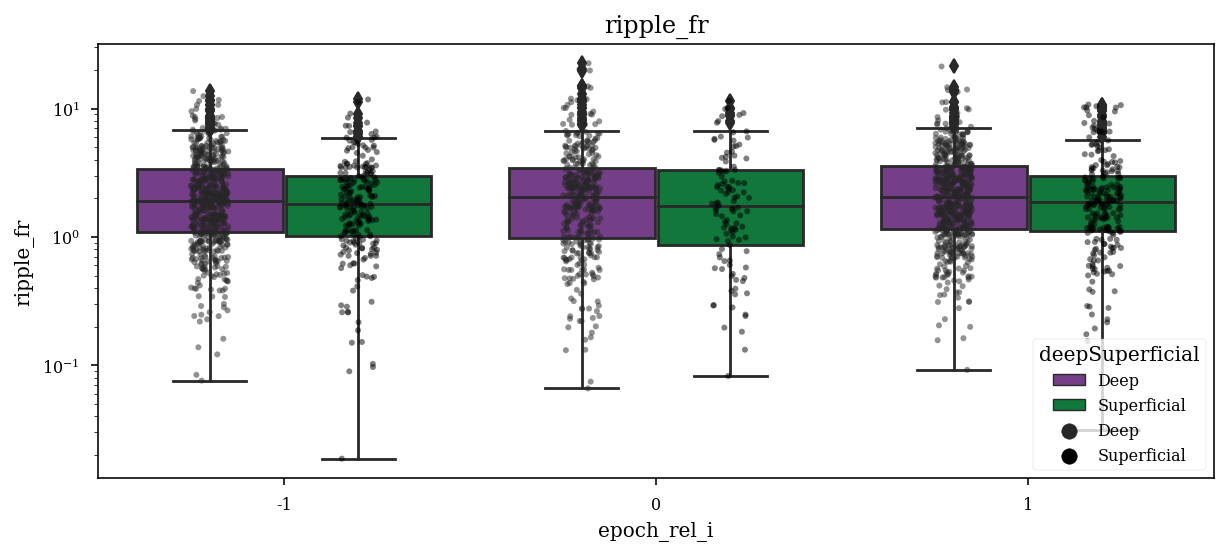

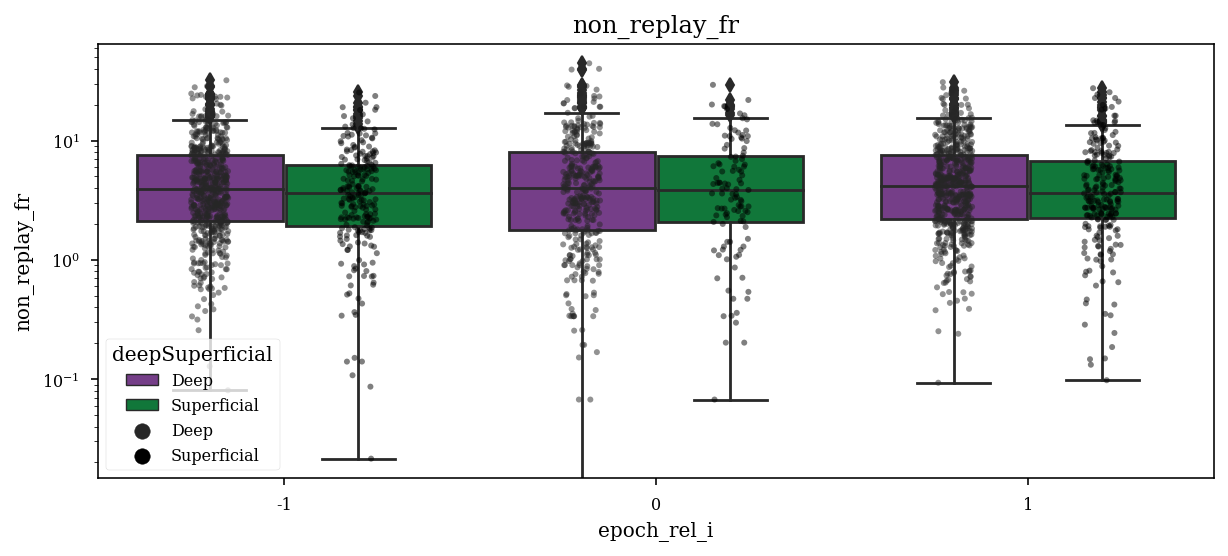

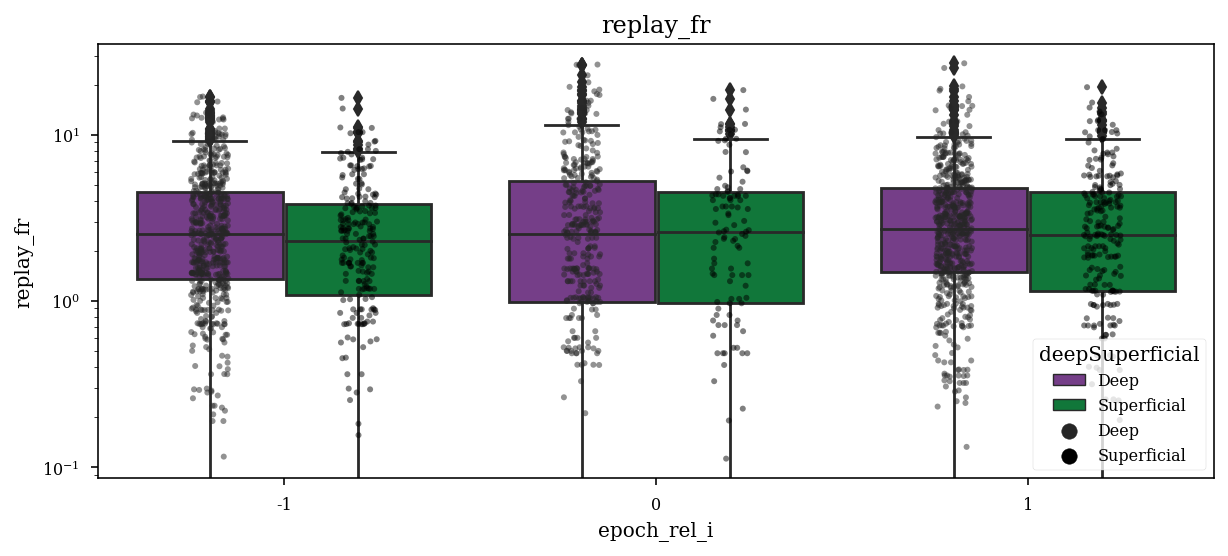

In [420]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

keep_idx = (
    (par_df.deepSuperficial != "middle") 
    & (par_df.n_replays > 5) 
    & (par_df.epoch_rel_i >=-1) & (par_df.epoch_rel_i <= 1)
    & ((par_df.epoch == "linear") | (par_df.epoch == "sleep"))
)

ys = ["ripple_fr","non_replay_fr","replay_fr"]
for y in ys:
    plt.figure(figsize=(10,4))
    sns.boxplot(x="epoch_rel_i", y=y,
                hue="deepSuperficial",
                data=par_df[keep_idx])
    sns.stripplot(x="epoch_rel_i", y=y,
                hue="deepSuperficial",
                data=par_df[keep_idx],dodge=True,color="k",size=3,alpha=.5)
    plt.title(y,fontsize=12)
    plt.yscale("log")


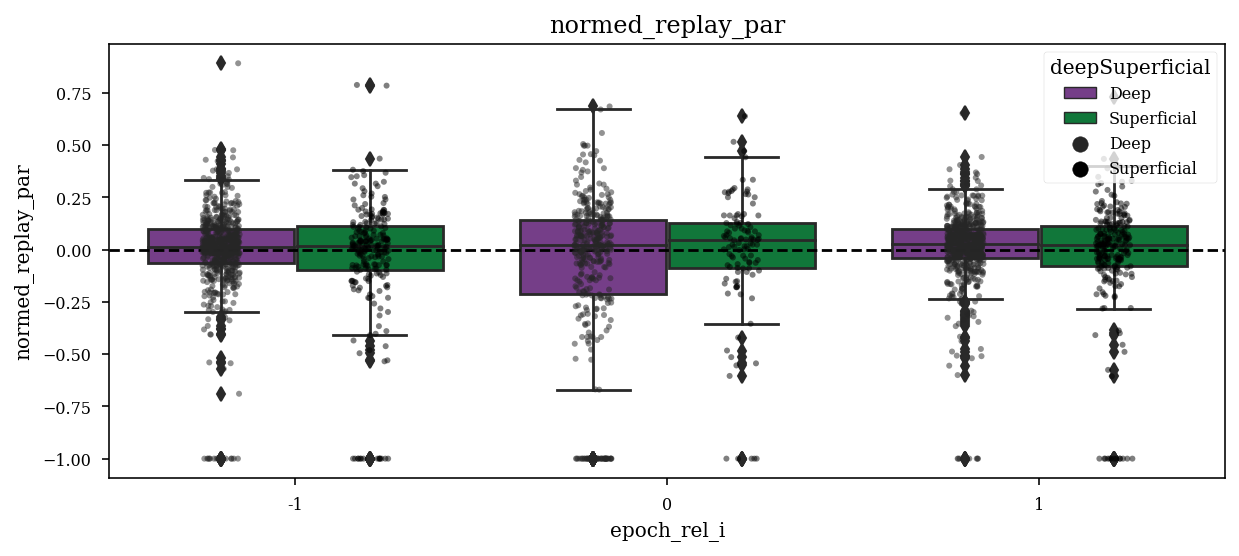

In [421]:
par_df["normed_replay_par"] = (par_df.replay_par - par_df.non_replay_par) / (
    par_df.replay_par + par_df.non_replay_par
)

# par_df["normed_replay_par"] = par_df.replay_par / par_df.non_replay_par

for y in ["normed_replay_par"]:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x="epoch_rel_i", y=y, hue="deepSuperficial", data=par_df[keep_idx])
    sns.stripplot(
        x="epoch_rel_i",
        y=y,
        hue="deepSuperficial",
        data=par_df[keep_idx],
        dodge=True,
        color="k",
        size=3,
        alpha=0.5,
    )
    plt.title(y, fontsize=12)
    # plt.yscale("log")
plt.axhline(0, color="k", linestyle="--")

## normalize replay participation by baseline replay-canidate participation

In [422]:
keep_idx = (
    (par_df.deepSuperficial != "middle")
    & (par_df.n_replays > 2)
    & (par_df.epoch_rel_i >= -1)
    & (par_df.epoch_rel_i <= 1)
    & ((par_df.epoch == "linear") | (par_df.epoch == "sleep"))
)
temp_df = par_df[keep_idx]
temp_df["basepath_UID"] = temp_df["basepath"] + "_" + temp_df["UID"].astype(str)

for basepath_UID in temp_df.basepath_UID.unique():
    par_baseline = temp_df[
        (temp_df.basepath_UID == basepath_UID) & (temp_df.epoch_rel_i == -1)
    ].non_replay_par

    par_task = temp_df[
        (temp_df.basepath_UID == basepath_UID) & (temp_df.epoch_rel_i == 0)
    ].replay_par

    if (len(par_task) == 0) | (len(par_baseline) == 0):
        continue

    temp_df.loc[temp_df.basepath_UID == basepath_UID, "replay_par_rel_baseline"] = (
        (par_task.values[0] - par_baseline.values[0])
    ) / (par_baseline.values[0] + par_task.values[0])

    replay_fr_baseline = temp_df[
        (temp_df.basepath_UID == basepath_UID) & (temp_df.epoch_rel_i == -1)
    ].non_replay_fr

    replay_fr_task = temp_df[
        (temp_df.basepath_UID == basepath_UID) & (temp_df.epoch_rel_i == 0)
    ].replay_fr

    temp_df.loc[temp_df.basepath_UID == basepath_UID, "replay_fr_rel_baseline"] = (
        (replay_fr_task.values[0] - replay_fr_baseline.values[0])
    ) / (replay_fr_baseline.values[0] + replay_fr_task.values[0])

<AxesSubplot:xlabel='label', ylabel='fr'>

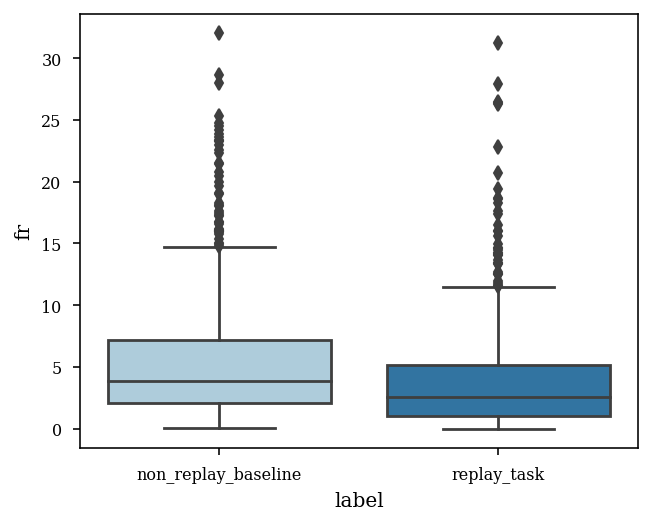

In [423]:
temp_temp_df = pd.DataFrame()
temp_temp_df['fr'] =  np.hstack([temp_df[(temp_df.epoch_rel_i == -1)].non_replay_fr, temp_df[(temp_df.epoch_rel_i == 0)].replay_fr])
temp_temp_df['label'] = (['non_replay_baseline'] * (temp_df.epoch_rel_i == -1).sum()) + (['replay_task'] * (temp_df.epoch_rel_i == 0).sum())


plt.figure(figsize=(5, 4))
sns.boxplot(x="label", y="fr", data=temp_temp_df, palette="Paired")

<AxesSubplot:xlabel='deepSuperficial', ylabel='replay_par_rel_baseline'>

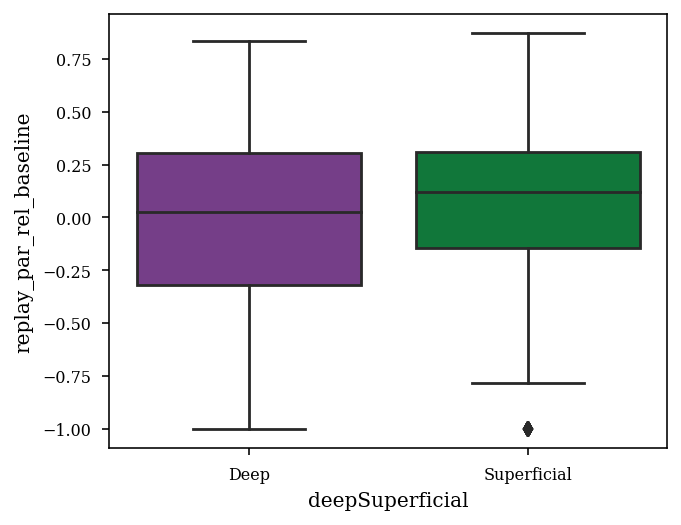

In [424]:
plt.figure(figsize=(5, 4))

replay_fr_baseline = temp_df[(temp_df.epoch_rel_i == -1)].non_replay_fr
sns.boxplot(x="deepSuperficial", y="replay_par_rel_baseline", data=temp_df)

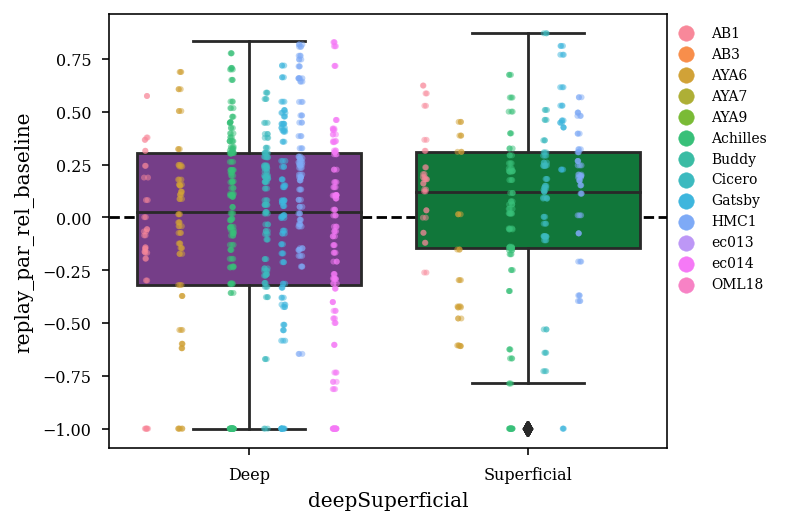

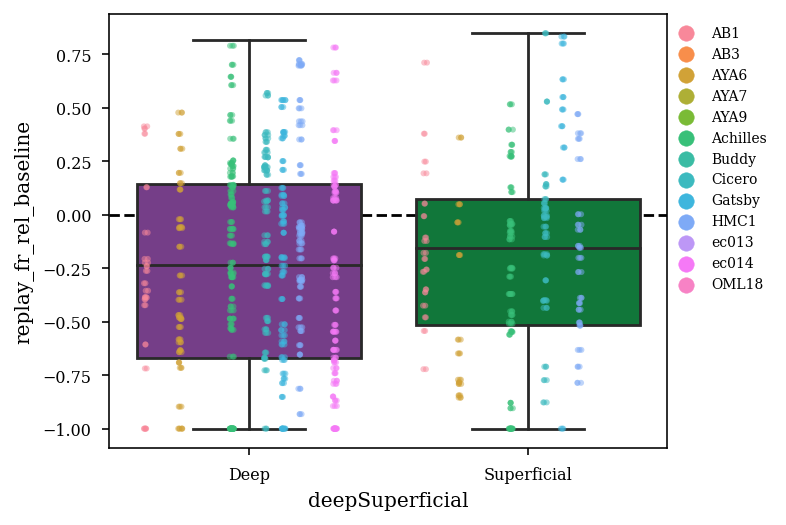

In [425]:
remove_idx = ~temp_df.basepath.str.contains("GirardeauG")


plt.figure(figsize=(5, 4))
sns.boxplot(x="deepSuperficial", y="replay_par_rel_baseline", data=temp_df)
sns.stripplot(
    x="deepSuperficial",
    y="replay_par_rel_baseline",
    hue="animal_id",
    data=temp_df[remove_idx],
    dodge=True,
    size=3,
    alpha=0.5,
)
plt.axhline(0, color="k", linestyle="--",zorder=-100)
plt.legend(loc='best', bbox_to_anchor=(.2, 0., 1, 1),fontsize='x-small',frameon=False)


plt.figure(figsize=(5, 4))
sns.boxplot(x="deepSuperficial", y="replay_fr_rel_baseline", data=temp_df)
sns.stripplot(
    x="deepSuperficial",
    y="replay_fr_rel_baseline",
    hue="animal_id",
    data=temp_df[remove_idx],
    dodge=True,
    size=3,
    alpha=0.5,
)
plt.axhline(0, color="k", linestyle="--",zorder=-100)
plt.legend(loc='best', bbox_to_anchor=(.2, 0., 1, 1),fontsize='x-small',frameon=False)


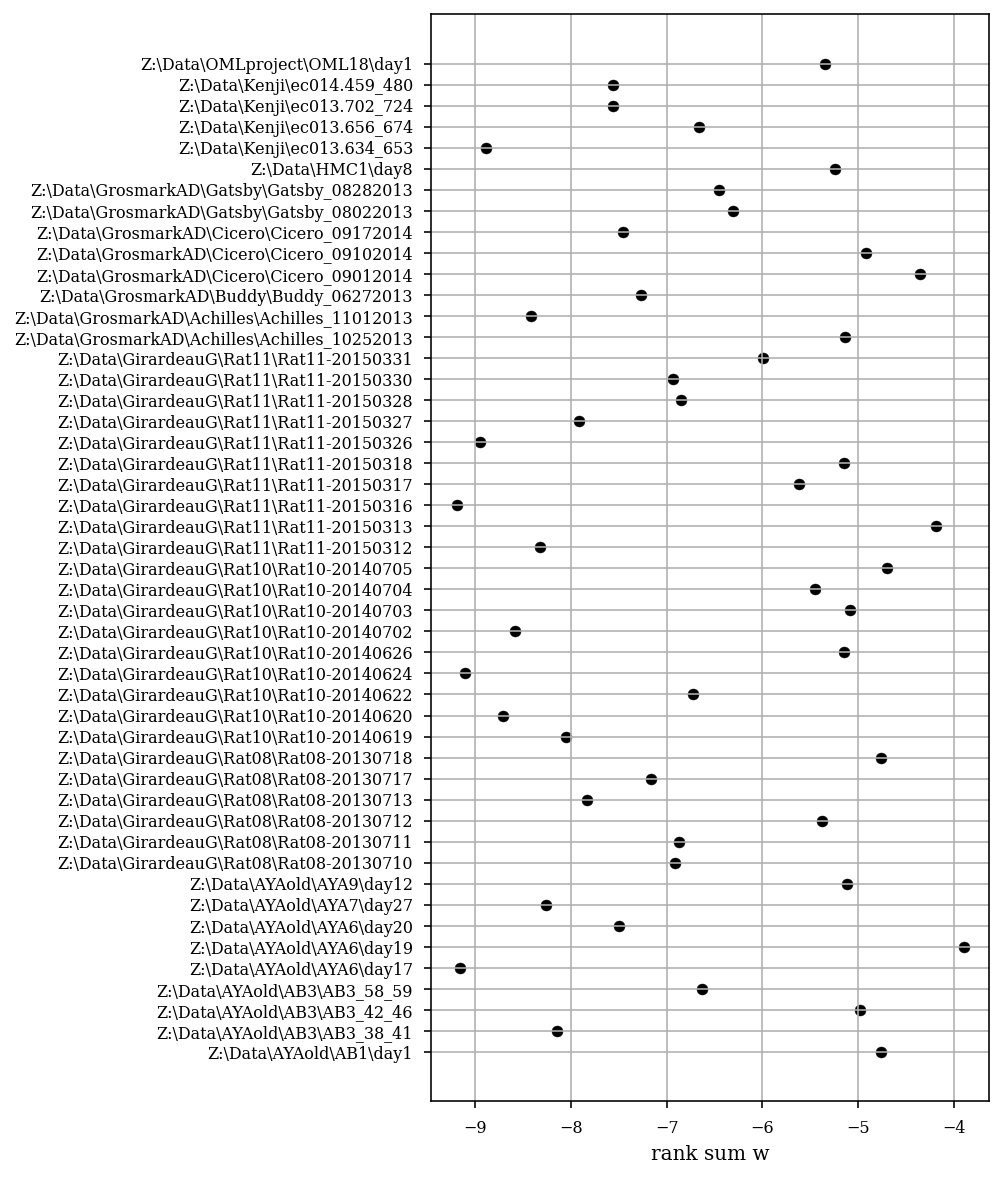

In [426]:
from scipy.stats import ranksums

plt.figure(figsize=(5,10))
for basepath in temp_df.basepath.unique():
    remove_idx = ~(temp_df.basepath == basepath)
    w, p = ranksums(
        temp_df[(temp_df.deepSuperficial == "Deep") & remove_idx].replay_par_rel_baseline.values,
        temp_df[(temp_df.deepSuperficial == "Superficial") & remove_idx].replay_par_rel_baseline.values,
    )
    plt.scatter(w, basepath,color='k',s=30)

plt.xlabel("rank sum w")
plt.grid()

In [277]:
# import statsmodels.formula.api as smf
# import statsmodels.api as sm



In [276]:
# md = smf.mixedlm("replay_fr_rel_baseline ~ deepSuperficial", temp_df, groups=temp_df["animal_id"], re_formula="~deepSuperficial")

In [266]:
temp_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\temp_replay_participation_df.csv")

In [267]:
temp_df

avg_fr  replay_fr  ripple_fr  non_replay_fr  replay_par  ripple_par  \
0    0.025439   0.727167   0.076020       0.080510    0.142857    0.012069   
2    0.277193   0.727167   0.619022       0.724591    0.142857    0.082759   
4    0.637720   2.181501   2.085125       3.622955    0.285714    0.224138   
5    1.067545   0.727167   3.594669      10.063764    0.142857    0.315517   
9    0.489474   0.000000   1.227183       1.771222    0.000000    0.162069   
..        ...        ...        ...            ...         ...         ...   
142  1.481981   6.395861   5.216095      11.867744    0.641026    0.385487   
143  0.446743   5.187754   2.212471       6.416861    0.521368    0.197927   
144  1.161844   0.959379   1.666636       2.612744    0.188034    0.149952   
145  1.822286   7.035447   4.409609       9.733390    0.538462    0.360897   
146  1.461154   6.431394   6.203504      12.626727    0.589744    0.453954   

     non_replay_par  forward_replay_par  reverse_replay_par  epoch  ...  \
0          0.008264            0.000000            0.200000  sleep  ...   
2          0.074380            0.000000            0.200000  sleep  ...   
4          0.264463            0.500000            0.200000  sleep  ...   
5          0.471074            0.000000            0.200000  sleep  ...   
9          0.165289            0.000000            0.000000  sleep  ...   
..              ...                 ...                 ...    ...  ...   
142        0.583333            0.657534            0.627451  sleep  ...   
143        0.359060            0.616438            0.372549  sleep  ...   
144        0.191834            0.136986            0.254902  sleep  ...   
145        0.506152            0.547945            0.549020  sleep  ...   
146        0.606264            0.616438            0.549020  sleep  ...   

     n_replays  n_ripples                     basepath  deepSuperficial  \
0            7        580      Z:\Data\AYAold\AB1\day1             Deep   
2            7        580      Z:\Data\AYAold\AB1\day1      Superficial   
4            7        580      Z:\Data\AYAold\AB1\day1      Superficial   
5            7        580      Z:\Data\AYAold\AB1\day1      Superficial   
9            7        580      Z:\Data\AYAold\AB1\day1      Superficial   
..         ...        ...                          ...              ...   
142        117       4148  Z:\Data\Kenji\ec014.459_480             Deep   
143        117       4148  Z:\Data\Kenji\ec014.459_480             Deep   
144        117       4148  Z:\Data\Kenji\ec014.459_480             Deep   
145        117       4148  Z:\Data\Kenji\ec014.459_480             Deep   
146        117       4148  Z:\Data\Kenji\ec014.459_480             Deep   

     normed_replay_par  animal_id normed_replay_fr  \
0             0.890625        AB1         0.800638   
2             0.315217        AB1         0.001774   
4             0.038627        AB1        -0.248336   
5            -0.534615        AB1        -0.865226   
9            -1.000000        AB1        -1.000000   
..                 ...        ...              ...   
142           0.047120      ec014        -0.299606   
143           0.184350      ec014        -0.105915   
144          -0.010004      ec014        -0.462852   
145           0.030930      ec014        -0.160890   
146          -0.013813      ec014        -0.325076   

                       basepath_UID  replay_par_rel_baseline  \
0         Z:\Data\AYAold\AB1\day1_1                -1.000000   
2        Z:\Data\AYAold\AB1\day1_10                 0.586885   
4        Z:\Data\AYAold\AB1\day1_15                 0.367232   
5        Z:\Data\AYAold\AB1\day1_17                 0.205179   
9        Z:\Data\AYAold\AB1\day1_22                -0.072797   
..                              ...                      ...   
142  Z:\Data\Kenji\ec014.459_480_75                 0.142857   
143  Z:\Data\Kenji\ec014.459_480_76                 0.361022   
144  Z:\Data\Kenji\ec014.459_480_77        

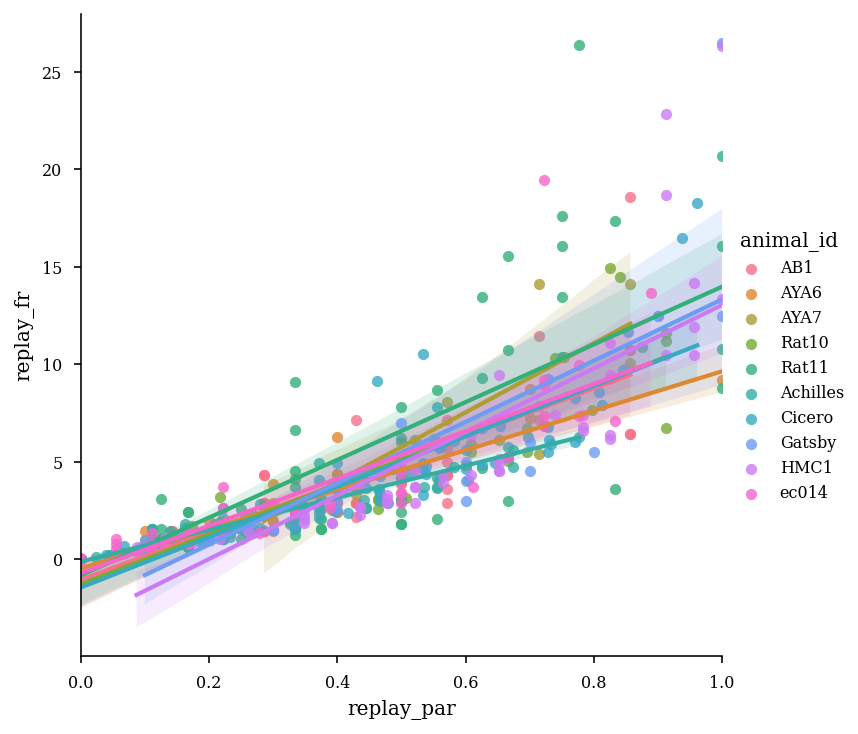

In [427]:
# plt.plot(par_df[keep_idx].replay_par.values,'.k')

idx = (
    (par_df.deepSuperficial != "middle") 
    & (par_df.n_replays > 5) 
    & (par_df.epoch_rel_i == 0)
    & (par_df.epoch == "linear")
)
g = sns.lmplot(
    data=par_df[idx],
    x="replay_par", y="replay_fr", hue="animal_id",
)

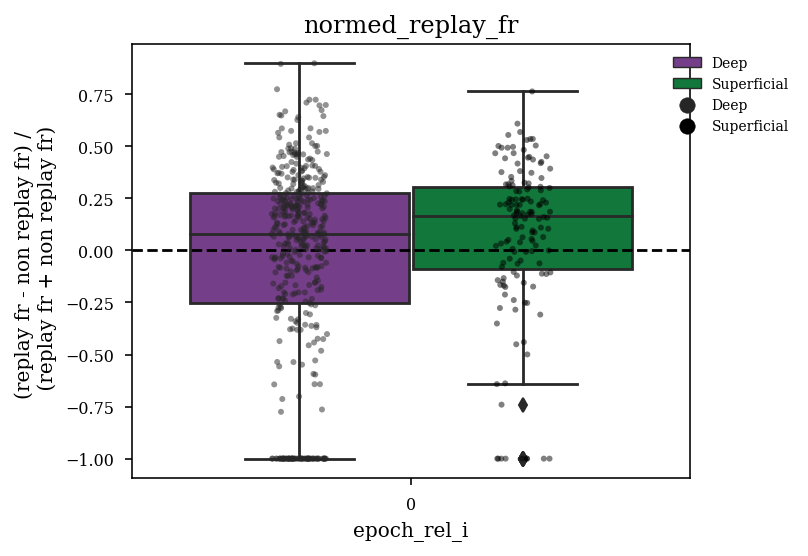

In [428]:
keep_idx = (
    (par_df.deepSuperficial != "middle")
    & (par_df.n_replays > 2)
    & (par_df.epoch_rel_i ==0)
    & ((par_df.epoch == "linear"))
)

par_df["normed_replay_fr"] = (par_df.replay_fr - par_df.ripple_fr) / (
    par_df.ripple_fr + par_df.replay_fr
)
# remove_idx = ~par_df.basepath.str.contains("GirardeauG")

# par_df["normed_replay_fr"] = (par_df.replay_fr / par_df.non_replay_fr)
for y in ["normed_replay_fr"]:
    plt.figure(figsize=(5, 4))
    sns.boxplot(x="epoch_rel_i", y=y, hue="deepSuperficial", data=par_df[keep_idx])
    sns.stripplot(
        x="epoch_rel_i",
        y=y,
        hue="deepSuperficial",
        data=par_df[keep_idx],
        dodge=True,
        color="k",
        size=3,
        alpha=0.5,
    )
    plt.title(y, fontsize=12)
    # plt.yscale("log")
plt.axhline(0, color="k", linestyle="--")
plt.ylabel("(replay fr - non replay fr) / \n (replay fr + non replay fr)")
plt.legend(loc='best', bbox_to_anchor=(.2, 0., 1, 1),fontsize='x-small',frameon=False)

# plt.yscale("log")

In [352]:
par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\temp_replay_participation_df.csv")

## ripple and replay features 

0 is linear track
-1 and 1 are sleep

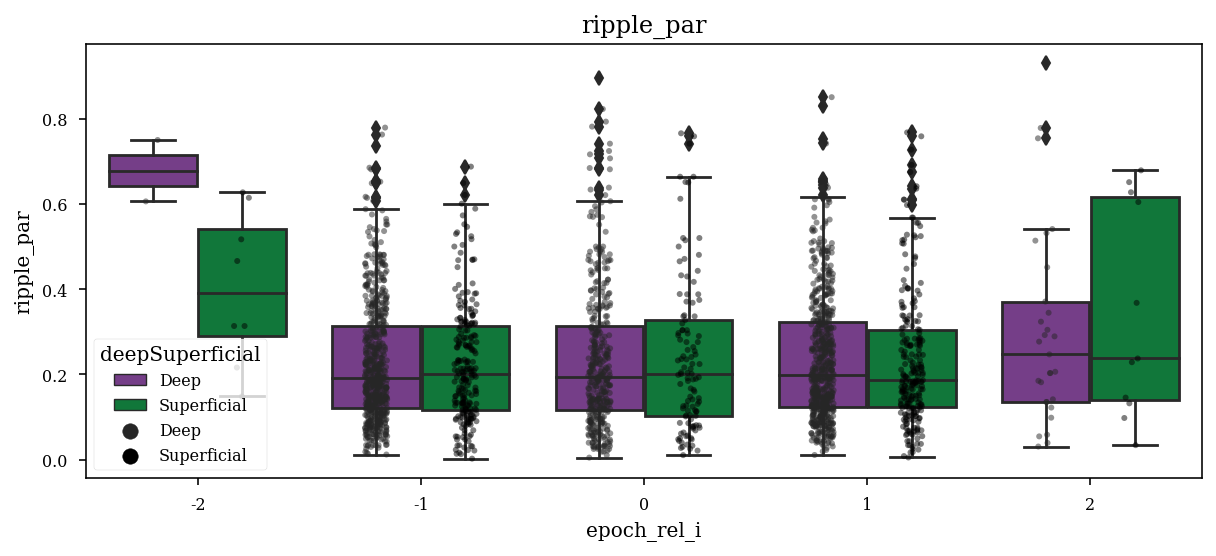

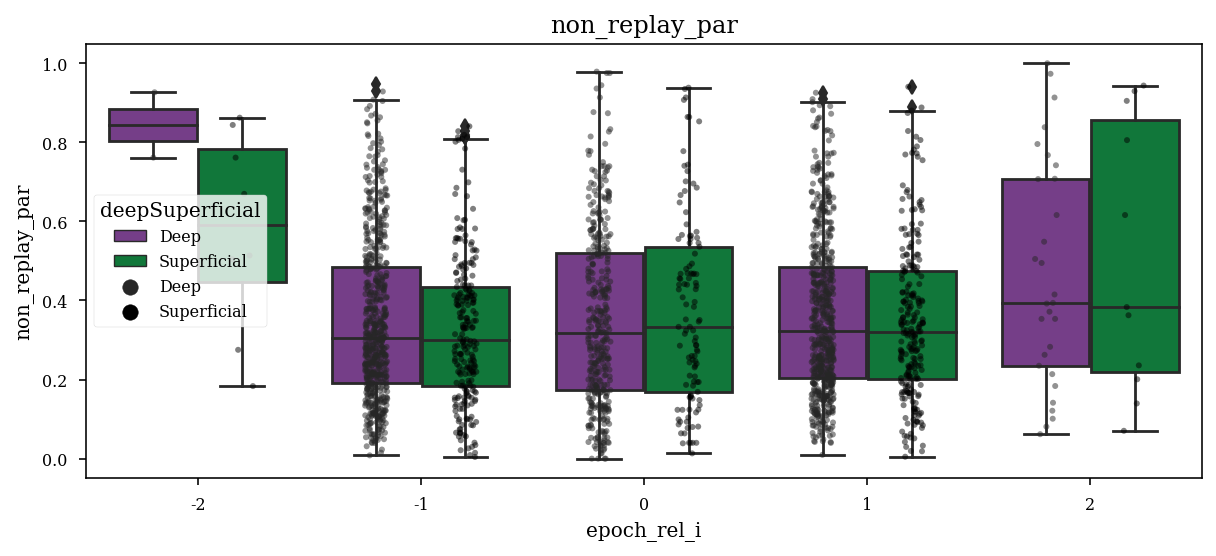

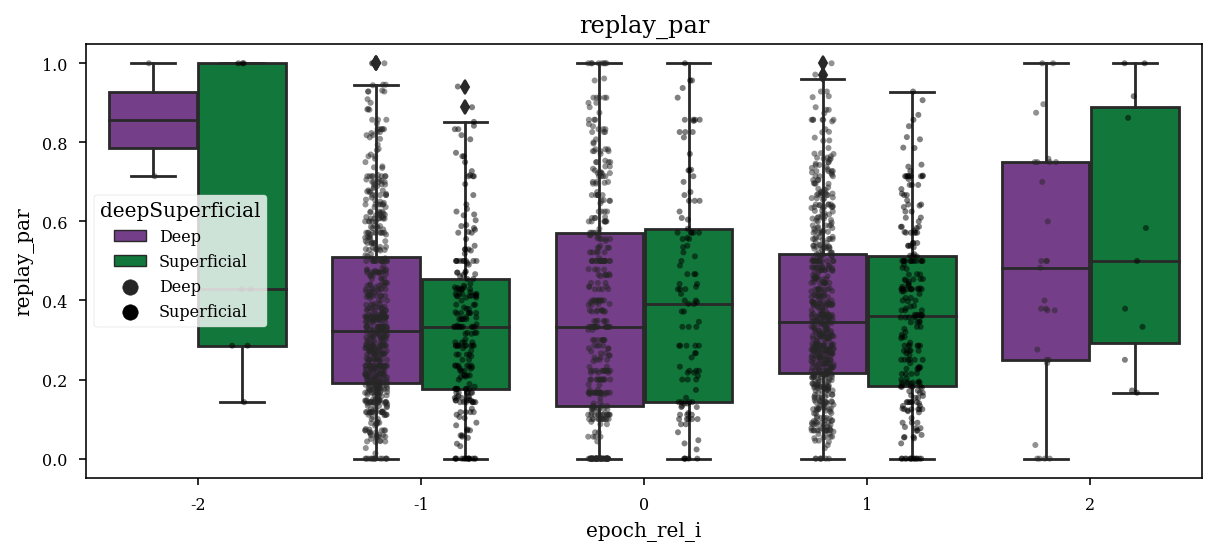

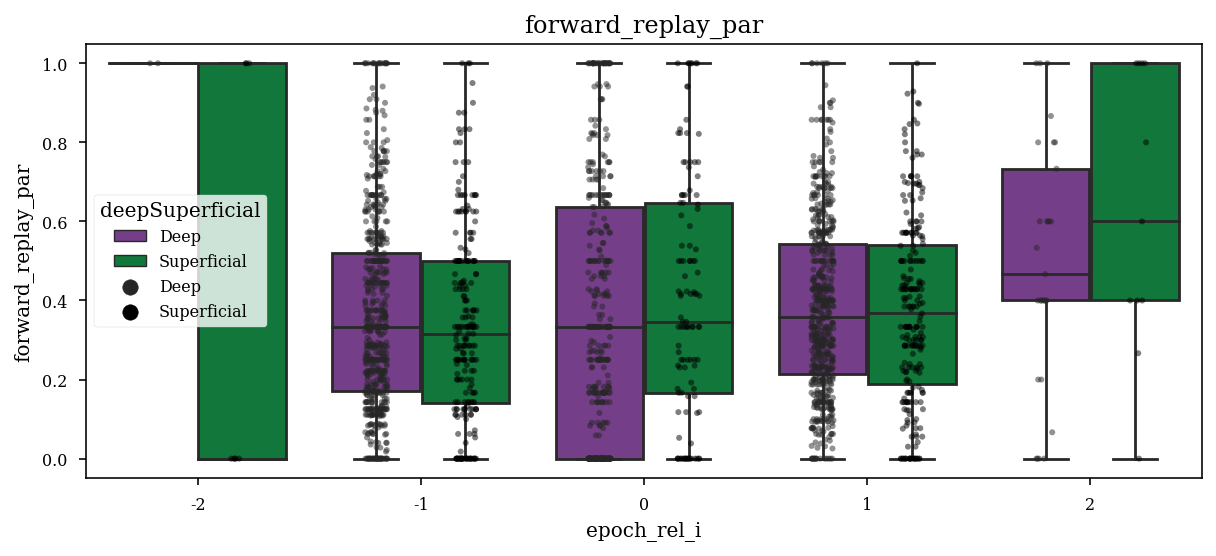

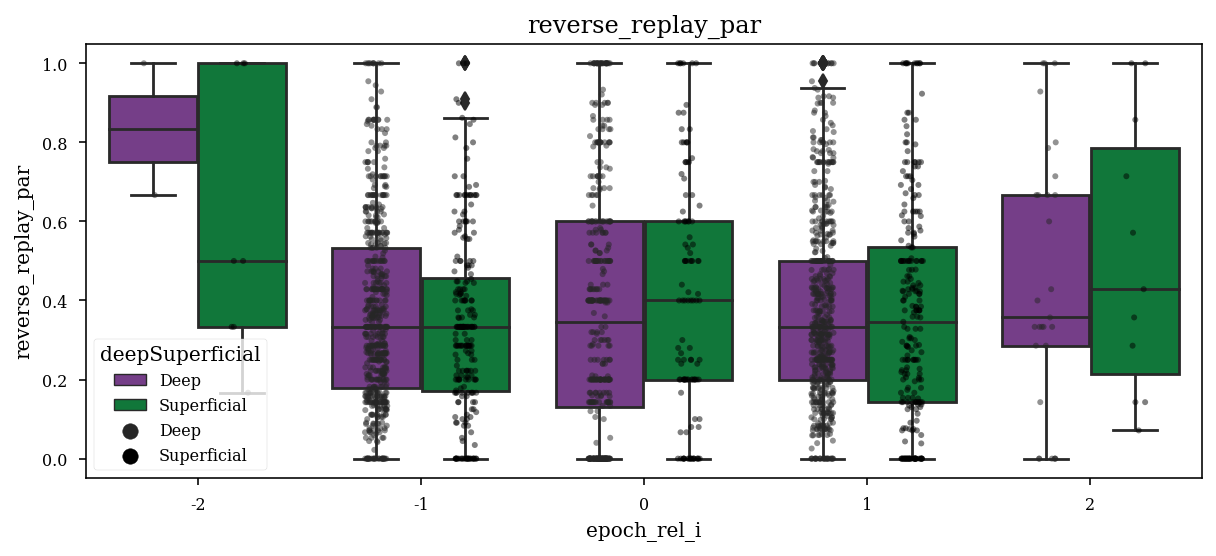

In [429]:
# plt.figure(figsize=(10,4))
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

keep_idx = (
    (par_df.deepSuperficial != "middle") 
    & (par_df.n_replays > 5) 
    & (par_df.epoch_rel_i >=-2) & (par_df.epoch_rel_i <= 2)
    & ((par_df.epoch == "linear") | (par_df.epoch == "sleep"))
)

ys = ["ripple_par","non_replay_par","replay_par","forward_replay_par","reverse_replay_par"]
for y in ys:
    plt.figure(figsize=(10,4))
    sns.boxplot(x="epoch_rel_i", y=y,
                hue="deepSuperficial",
                data=par_df[keep_idx])
    sns.stripplot(x="epoch_rel_i", y=y,
                hue="deepSuperficial",
                data=par_df[keep_idx],dodge=True,color="k",size=3,alpha=.5)
    plt.title(y,fontsize=12)
 

<Axes:>

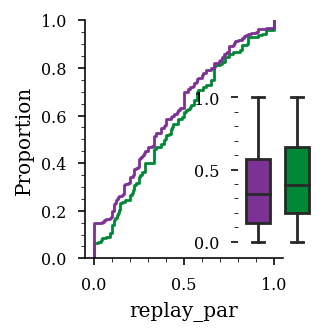

In [430]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(2, 1)), edgecolor=None
)
ax = plt.gca()

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

custom_plots.plot_ecdf_box(
    par_df[
        (par_df.deepSuperficial != "middle")
        & (par_df.epoch_rel_i == 0)
        & (par_df.epoch == "linear")
        & (par_df.n_replays > 2)
    ],
    x="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    x_offset=0.6,
    ax=ax,
    fig=fig,
)


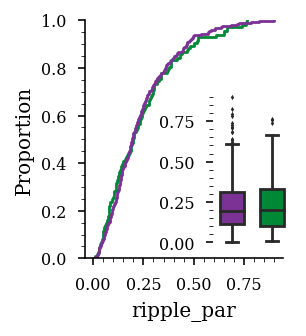

In [431]:
fig=plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(2, 1)), edgecolor=None
)
ax = plt.gca()

group_colors = {
    "Deep": "#7b3294",
    "Superficial": "#008837"
}
sns.set_palette(sns.color_palette(group_colors.values()))

box_ax = custom_plots.plot_ecdf_box(
    par_df[
        (par_df.deepSuperficial != "middle")
        & (par_df.epoch_rel_i == 0)
        & (par_df.epoch == "linear")
        & (par_df.n_replays > 5)
    ],
    x="ripple_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    x_offset=.5,
    ax=ax,
    fig=fig
)
# box_ax.legend(loc="lower right")

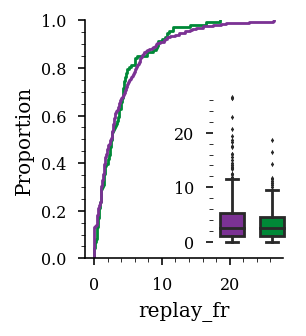

In [432]:
fig=plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(2, 1)), edgecolor=None
)
ax = plt.gca()

group_colors = {
    "Deep": "#7b3294",
    "Superficial": "#008837"
}
sns.set_palette(sns.color_palette(group_colors.values()))

box_ax = custom_plots.plot_ecdf_box(
    par_df[
        (par_df.deepSuperficial != "middle")
        & (par_df.epoch_rel_i == 0)
        & (par_df.epoch == "linear")
        & (par_df.n_replays > 5)
    ],
    x="replay_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    x_offset=.5,
    ax=ax,
    fig=fig
)

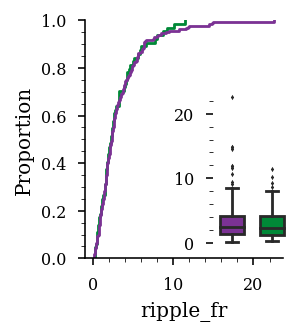

In [433]:
fig=plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(2, 1)), edgecolor=None
)
ax = plt.gca()

group_colors = {
    "Deep": "#7b3294",
    "Superficial": "#008837"
}
sns.set_palette(sns.color_palette(group_colors.values()))

box_ax = custom_plots.plot_ecdf_box(
    par_df[
        (par_df.deepSuperficial != "middle")
        & (par_df.epoch_rel_i == 0)
        & (par_df.epoch == "linear")
        & (par_df.n_replays > 10)
    ],
    x="ripple_fr",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    x_offset=.5,
    ax=ax,
    fig=fig
)

## Counts for forward and reverse replay by epoch

Here, I'm using score_pval_time_swap instead of score_pval_col_cycle. 

score_pval_time_swap enforces a spatial trajectory across the maze, while stationary events will still pass score_pval_col_cycle


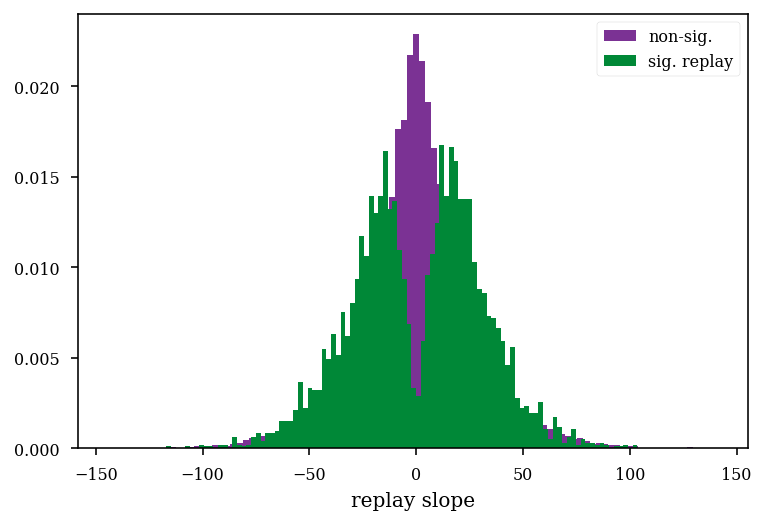

In [434]:
plt.hist(df[df.score_pval_time_swap > 0.05].slope,
         100, density=True, label='non-sig.')
plt.hist(df[df.score_pval_time_swap < 0.05].slope,
         100, density=True, label='sig. replay')
plt.legend()
plt.xlabel('replay slope')
plt.show()


In [ ]:
from matplotlib.ticker import AutoMinorLocator

alpha = 0.05

n_forward = [sum((df.score_pval_time_swap < alpha) & (df.replay_type == 'forward') & (df.epoch == 'pre_sleep')),
             sum((df.score_pval_time_swap < alpha) & (
                 df.replay_type == 'forward') & (df.epoch == 'linear')),
             sum((df.score_pval_time_swap < alpha) & (
                 df.replay_type == 'forward') & (df.epoch == 'post_sleep'))
             ]
n_reverse = [sum((df.score_pval_time_swap < alpha) & (df.replay_type == 'reverse') & (df.epoch == 'pre_sleep')),
             sum((df.score_pval_time_swap < alpha) & (
                 df.replay_type == 'reverse') & (df.epoch == 'linear')),
             sum((df.score_pval_time_swap < alpha) & (
                 df.replay_type == 'reverse') & (df.epoch == 'post_sleep'))
             ]
total = [sum((df.score_pval_time_swap < alpha) & (df.epoch == 'pre_sleep')),
         sum((df.score_pval_time_swap < alpha) & (df.epoch == 'linear')),
         sum((df.score_pval_time_swap < alpha) & (df.epoch == 'post_sleep'))
         ]
total_all = [sum((df.epoch == 'pre_sleep')),
             sum((df.epoch == 'linear')),
             sum((df.epoch == 'post_sleep'))
             ]
prop_df = pd.DataFrame()

prop_df['counts'] = np.hstack([n_forward, n_reverse])
prop_df['total'] = np.hstack([total, total])
prop_df['prop'] = prop_df['counts'] / prop_df['total']
# prop_df['total_prop'] = prop_df['counts'] / np.sum(prop_df['total'])
prop_df['total_prop'] = prop_df['counts'] / np.hstack([total_all, total_all])

prop_df['replay_labels'] = ['forward', 'forward',
                            'forward', 'reverse', 'reverse', 'reverse']
prop_df['epoch_labels'] = ['pre', 'task', 'post', 'pre', 'task', 'post']

plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)))
ax = plt.gca()
sns.barplot(data=prop_df, x="epoch_labels", y="prop",
            hue="replay_labels", palette="vlag", ax=ax)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(bbox_to_anchor=(1, 1.05))

plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)))
ax = plt.gca()
sns.barplot(data=prop_df, x="epoch_labels", y="counts",
            hue="replay_labels", palette="vlag", ax=ax)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_ylabel('Number of events')
plt.savefig(os.path.join(fig_save_path,
            'forward_reverse_counts_per_session.svg'), dpi=300, bbox_inches='tight')

plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)))
ax = plt.gca()
sns.barplot(data=prop_df, x="epoch_labels", y="total_prop",
            hue="replay_labels", palette="vlag", ax=ax)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_ylabel('Proportion of \n candidate events')
ax.set_xlabel('')
ax.set_xticklabels(['Pre', 'Maze', 'Post'])

ax.legend(bbox_to_anchor=(1.1, 1.4), fontsize=7)
# ax.yaxis.grid(True)
ax.set_axisbelow(True)
ax.yaxis.grid()
plt.savefig(os.path.join(fig_save_path, 'forward_reverse_total_prop_per_session.svg'),
            dpi=300, bbox_inches='tight', transparent=True)


## Show some replay and non replay examples

In [ ]:
forward_path = os.path.join(fig_save_path, 'replay_examples', 'forward')
reverse_path = os.path.join(fig_save_path, 'replay_examples', 'reverse')

if not os.path.isdir(forward_path):
    os.mkdir(forward_path)
if not os.path.isdir(reverse_path):
    os.mkdir(reverse_path)

sessions = glob.glob(save_path + os.sep + '*.pkl')
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    if results is None:
        continue
    
    basepath = results['outbound_epochs']['session']
    animal_name = loading.get_animal_id(basepath)
    basename = os.path.basename(basepath)
    idx = np.where((results['outbound_epochs']['df'].score_pval_time_swap < 0.05) &
                    (results['outbound_epochs']['df'].replay_type == 'forward'))[0]

    if (results['outbound_epochs']["decoding_r2_pval"] > 0.05) | (results['outbound_epochs']["decoding_median_error"] > 30):
        idx = []
            
    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                                results['outbound_epochs']['sta_placecells'],
                                                results['outbound_epochs']['tc'],
                                                results['outbound_epochs']['tc'],
                                                vmax=.1)
        fig.savefig(os.path.join(fig_save_path, 'replay_examples', forward_path,
                    basename+'_'+animal_name+'_.jpeg'), dpi=300, bbox_inches='tight')
        plt.close(fig)

    idx = np.where((results['inbound_epochs']['df'].score_pval_time_swap < 0.05) &
                    (results['inbound_epochs']['df'].replay_type == 'forward'))[0]

    if (results['inbound_epochs']["decoding_r2_pval"] > 0.05) | (results['inbound_epochs']["decoding_median_error"] > 30):
        idx = []
    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(results['inbound_epochs']['bst_placecells'][idx],
                                                results['inbound_epochs']['sta_placecells'],
                                                results['inbound_epochs']['tc'],
                                                results['inbound_epochs']['tc'],
                                                vmax=.1)
        fig.savefig(os.path.join(fig_save_path, 'replay_examples', forward_path,
                    basename+'_'+animal_name+'1_.jpeg'), dpi=300, bbox_inches='tight')
        plt.close(fig)

    idx = np.where((results['outbound_epochs']['df'].score_pval_time_swap < 0.05) &
                    (results['outbound_epochs']['df'].replay_type == 'reverse'))[0]
    if (results['outbound_epochs']["decoding_r2_pval"] > 0.05) | (results['outbound_epochs']["decoding_median_error"] > 30):
        idx = []               
    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                                results['outbound_epochs']['sta_placecells'],
                                                results['outbound_epochs']['tc'],
                                                results['outbound_epochs']['tc'],
                                                vmax=.1)
        fig.savefig(os.path.join(fig_save_path, 'replay_examples', reverse_path,
                    basename+'_'+animal_name+'_.jpeg'), dpi=300, bbox_inches='tight')
        plt.close(fig)

    idx = np.where((results['inbound_epochs']['df'].score_pval_time_swap < 0.05) &
                    (results['inbound_epochs']['df'].replay_type == 'reverse'))[0]
    if (results['inbound_epochs']["decoding_r2_pval"] > 0.05) | (results['inbound_epochs']["decoding_median_error"] > 30):
        idx = []                
    if len(idx) > 0:
        ax, fig = replay_fig.plot_all_replay(results['inbound_epochs']['bst_placecells'][idx],
                                                results['inbound_epochs']['sta_placecells'],
                                                results['inbound_epochs']['tc'],
                                                results['inbound_epochs']['tc'],
                                                vmax=.1)
        fig.savefig(os.path.join(fig_save_path, 'replay_examples', reverse_path,
                    basename+'_'+animal_name+'1_.jpeg'), dpi=300, bbox_inches='tight')
        plt.close(fig)


In [16]:
session = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay\Z__Data_GrosmarkAD_Achilles_Achilles_10252013.pkl'
basepath = 'Z:\Data\GrosmarkAD\Achilles\Achilles_10252013'
with open(session, 'rb') as f:
    results = pickle.load(f)

temp_df = df[(df.basepath == basepath)]
idx = np.where((temp_df['score_pval_col_cycle'] < 0.05))[0][0:30]
temp_df[temp_df['score_pval_col_cycle'] < 0.05]

epoch_df = loading.load_epoch(basepath)
pattern_idx, _ = functions.find_epoch_pattern(
    epoch_df.environment, ['sleep', 'linear', 'sleep'])
epoch_df = epoch_df[pattern_idx]


In [ ]:
import warnings
warnings.filterwarnings("ignore")
results['outbound_epochs']['df'].loc[results['outbound_epochs']['df'].start.between(
    epoch_df.startTime[0], epoch_df.stopTime[0]), 'epoch'] = 'pre_sleep'
results['outbound_epochs']['df'].loc[results['outbound_epochs']['df'].start.between(
    epoch_df.startTime[1], epoch_df.stopTime[1]), 'epoch'] = 'linear'
results['outbound_epochs']['df'].loc[results['outbound_epochs']['df'].start.between(
    epoch_df.startTime[2], epoch_df.stopTime[2]), 'epoch'] = 'post_sleep'

results['inbound_epochs']['df'].loc[results['inbound_epochs']['df'].start.between(
    epoch_df.startTime[0], epoch_df.stopTime[0]), 'epoch'] = 'pre_sleep'
results['inbound_epochs']['df'].loc[results['inbound_epochs']['df'].start.between(
    epoch_df.startTime[1], epoch_df.stopTime[1]), 'epoch'] = 'linear'
results['inbound_epochs']['df'].loc[results['inbound_epochs']['df'].start.between(
    epoch_df.startTime[2], epoch_df.stopTime[2]), 'epoch'] = 'post_sleep'

idx = np.where(
    (results['inbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['inbound_epochs']['df'].replay_type == 'forward') &
    (results['inbound_epochs']['df'].epoch == 'pre_sleep')
)[0]
ax, fig = replay_fig.plot_all_replay(results['inbound_epochs']['bst_placecells'][idx],
                                     results['inbound_epochs']['sta_placecells'],
                                     results['inbound_epochs']['tc'],
                                     results['inbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="forward pre_sleep")

idx = np.where(
    (results['inbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['inbound_epochs']['df'].replay_type == 'forward') &
    (results['inbound_epochs']['df'].epoch == 'linear')
)[0]
ax, fig = replay_fig.plot_all_replay(results['inbound_epochs']['bst_placecells'][idx],
                                     results['inbound_epochs']['sta_placecells'],
                                     results['inbound_epochs']['tc'],
                                     results['inbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="forward linear")

idx = np.where(
    (results['inbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['inbound_epochs']['df'].replay_type == 'forward') &
    (results['inbound_epochs']['df'].epoch == 'post_sleep')
)[0]
ax, fig = replay_fig.plot_all_replay(results['inbound_epochs']['bst_placecells'][idx],
                                     results['inbound_epochs']['sta_placecells'],
                                     results['inbound_epochs']['tc'],
                                     results['inbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="forward post_sleep")


idx = np.where(
    (results['inbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['inbound_epochs']['df'].replay_type == 'reverse') &
    (results['inbound_epochs']['df'].epoch == 'pre_sleep')
)[0]
ax, fig = replay_fig.plot_all_replay(results['inbound_epochs']['bst_placecells'][idx],
                                     results['inbound_epochs']['sta_placecells'],
                                     results['inbound_epochs']['tc'],
                                     results['inbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="reverse pre_sleep")

idx = np.where(
    (results['inbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['inbound_epochs']['df'].replay_type == 'reverse') &
    (results['inbound_epochs']['df'].epoch == 'linear')
)[0]
ax, fig = replay_fig.plot_all_replay(results['inbound_epochs']['bst_placecells'][idx],
                                     results['inbound_epochs']['sta_placecells'],
                                     results['inbound_epochs']['tc'],
                                     results['inbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="reverse linear")

idx = np.where(
    (results['inbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['inbound_epochs']['df'].replay_type == 'reverse') &
    (results['inbound_epochs']['df'].epoch == 'post_sleep')
)[0]

ax, fig = replay_fig.plot_all_replay(results['inbound_epochs']['bst_placecells'][idx],
                                     results['inbound_epochs']['sta_placecells'],
                                     results['inbound_epochs']['tc'],
                                     results['inbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="reverse post_sleep")


In [ ]:
idx = np.where(
    (results['outbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['outbound_epochs']['df'].replay_type == 'forward') &
    (results['outbound_epochs']['df'].epoch == 'pre_sleep')
)[0]
ax, fig = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                     results['outbound_epochs']['sta_placecells'],
                                     results['outbound_epochs']['tc'],
                                     results['outbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="forward pre_sleep")

idx = np.where(
    (results['outbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['outbound_epochs']['df'].replay_type == 'forward') &
    (results['outbound_epochs']['df'].epoch == 'linear')
)[0]
ax, fig = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                     results['outbound_epochs']['sta_placecells'],
                                     results['outbound_epochs']['tc'],
                                     results['outbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="forward linear")

idx = np.where(
    (results['outbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['outbound_epochs']['df'].replay_type == 'forward') &
    (results['outbound_epochs']['df'].epoch == 'post_sleep')
)[0]
ax, fig = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                     results['outbound_epochs']['sta_placecells'],
                                     results['outbound_epochs']['tc'],
                                     results['outbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="forward post_sleep")


idx = np.where(
    (results['outbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['outbound_epochs']['df'].replay_type == 'reverse') &
    (results['outbound_epochs']['df'].epoch == 'pre_sleep')
)[0]
ax, fig = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                     results['outbound_epochs']['sta_placecells'],
                                     results['outbound_epochs']['tc'],
                                     results['outbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="reverse pre_sleep")

idx = np.where(
    (results['outbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['outbound_epochs']['df'].replay_type == 'reverse') &
    (results['outbound_epochs']['df'].epoch == 'linear')
)[0]
ax, fig = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                     results['outbound_epochs']['sta_placecells'],
                                     results['outbound_epochs']['tc'],
                                     results['outbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="reverse linear")

idx = np.where(
    (results['outbound_epochs']['df'].score_pval_col_cycle < 0.05) &
    (results['outbound_epochs']['df'].replay_type == 'reverse') &
    (results['outbound_epochs']['df'].epoch == 'post_sleep')
)[0]

ax, fig = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                     results['outbound_epochs']['sta_placecells'],
                                     results['outbound_epochs']['tc'],
                                     results['outbound_epochs']['tc'],
                                     vmax=.1,
                                     title_str="reverse post_sleep")


## get single session examples

In [24]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

sessions = glob.glob(save_path + os.sep + '*.pkl')

with open(sessions[2], 'rb') as f:
    results = pickle.load(f)

basepath = results['outbound_epochs']['session']
print(basepath)
# 'Z:\Data\GrosmarkAD\Achilles\Achilles_10252013'
temp_df = df[(df.basepath == basepath)]
directions = temp_df.direction.unique()
n_sig = [sum((temp_df['score_pval_col_cycle'] < 0.05) & (temp_df['direction'] == directions[0])),
         sum((temp_df['score_pval_col_cycle'] < 0.05) & (temp_df['direction'] == directions[1]))]
direction = directions[np.argmax(n_sig)]
print(direction)

ripple_epochs = nel.EpochArray(
    [np.array([results[direction]['df'].start, results[direction]['df'].stop]).T])
epoch_df = loading.load_epoch(results[direction]['df'].basepath.unique()[0])
behavioral_epochs = nel.EpochArray(
    [np.array([epoch_df.startTime, epoch_df.stopTime]).T])
st = results[direction]['sta_placecells']

# pre task ripple participation prob
starts = ripple_epochs[behavioral_epochs[0]].starts
stops = ripple_epochs[behavioral_epochs[0]].stops
particip_mat_pre_ripple = functions.get_participation(st.data, starts, stops)
unit_partic_pre_task = particip_mat_pre_ripple.mean(axis=1)


Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
outbound_epochs


## Tuning curve snake plot

In [23]:
# results[direction]['sta_placecells']
# basepath = 'Z:\Data\GrosmarkAD\Achilles\Achilles_10252013'
# epoch_df = epoch_df[(epoch_df.stopTime - epoch_df.startTime)/60 > 5]
# beh_epochs = nel.EpochArray([np.array([epoch_df.startTime,epoch_df.stopTime]).T])
# pos,outbound_epochs,inbound_epochs = replay_run.handle_behavior(basepath,epoch_df,beh_epochs)


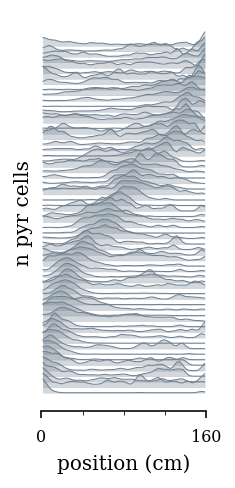

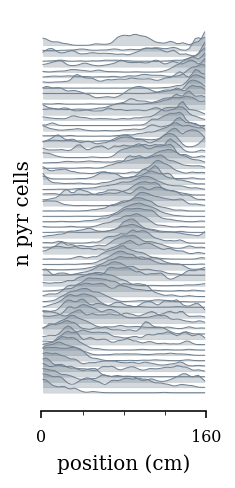

In [41]:
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator

tc = results[direction]['tc'].reorder_units()

w, h = functions.set_size('thesis', fraction=.25, subplots=(4, 1))

npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(w, h)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    ax1 = npl.plot_tuning_curves1D(
        tc, normalize=True, pad=.4, fill=True, color='slategrey')
    leg_lines = ax1.get_lines()
    plt.setp(leg_lines, linewidth=.5)
    ax.set_xlabel('position (cm)')
    ax.set_ylabel('n pyr cells')
    # ax.set_yticks([0,tc.ratemap.shape[0]])
    ax.set_yticks([])
    ax.set_xticks([0, tc.bins.max()])

    ax.xaxis.set_minor_locator(AutoMinorLocator())

    plt.savefig(os.path.join(fig_save_path,
                'place_cell_snake_example.svg'), dpi=300, bbox_inches='tight')

tc = results['inbound_epochs']['tc'].reorder_units()

w, h = functions.set_size('thesis', fraction=.25, subplots=(4, 1))

npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(w, h)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    ax1 = npl.plot_tuning_curves1D(
        tc, normalize=True, pad=.4, fill=True, color='slategrey')
    leg_lines = ax1.get_lines()
    plt.setp(leg_lines, linewidth=.5)
    ax.set_xlabel('position (cm)')
    ax.set_ylabel('n pyr cells')
    # ax.set_yticks([0,tc.ratemap.shape[0]])
    ax.set_yticks([])
    ax.set_xticks([0, tc.bins.max()])

    ax.xaxis.set_minor_locator(AutoMinorLocator())


In [151]:
basepath = results[direction]['session']
epoch_df = loading.load_epoch(basepath)
behavioral_epochs = nel.EpochArray(
    [np.array([epoch_df.startTime, epoch_df.stopTime]).T])

results[direction]['df'].loc[results[direction]['df'].start.between(
    epoch_df.startTime[0], epoch_df.stopTime[0]), 'epoch'] = 'pre_sleep'
results[direction]['df'].loc[results[direction]['df'].start.between(
    epoch_df.startTime[1], epoch_df.stopTime[1]), 'epoch'] = 'linear'
results[direction]['df'].loc[results[direction]['df'].start.between(
    epoch_df.startTime[2], epoch_df.stopTime[2]), 'epoch'] = 'post_sleep'


## get std of pre task rip participation for each sig replay event

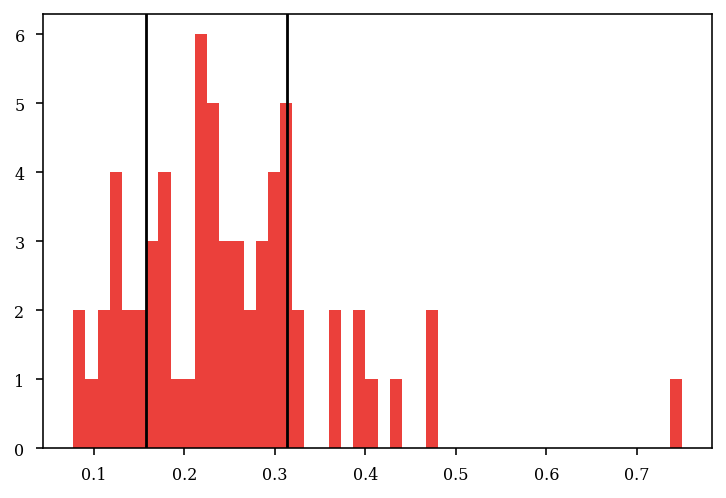

In [152]:
plt.hist(unit_partic_pre_task, 50)
plt.axvline(np.percentile(unit_partic_pre_task, 20), color='k')

plt.axvline(np.percentile(unit_partic_pre_task, 80), color='k')
plt.show()


In [ ]:
particip_mat = functions.get_participation(
    st.data, results[direction]['df'].start.values, results[direction]['df'].stop.values)

par_std = []
par_sem = []
n_active_check = []
par_median = []
par_mean = []
low_par_percent = []
for event in particip_mat.T:
    values = unit_partic_pre_task[event == 1]

    low_par_percent.append(sum(values < np.percentile(
        unit_partic_pre_task, 20)) / len(values))

    par_std.append(np.std(values))
    par_sem.append(np.std(values)/np.sqrt(len(values)))
    n_active_check.append(len(values))
    par_median.append(np.median(values))
    par_mean.append(np.mean(values))

results['df']['par_std'] = np.hstack(par_std)
results['df']['par_sem'] = np.hstack(par_sem)
results['df']['n_active_check'] = np.hstack(n_active_check)
results['df']['par_median'] = np.hstack(par_median)
results['df']['par_mean'] = np.hstack(par_mean)
results['df']['low_par_percent'] = np.hstack(low_par_percent)


In [365]:
results['df'].keys()


Index(['start', 'stop', 'peaks', 'amplitude', 'duration', 'frequency',
       'detectorName', 'ripple_channel', 'event_spk_thres', 'basepath',
       'basename', 'animal', 'n_active', 'inactive_bin_prop',
       'trajectory_score', 'r_squared', 'slope', 'intercept',
       'score_pval_time_swap', 'score_pval_col_cycle', 'traj_dist',
       'traj_speed', 'traj_step', 'replay_type', 'dist_rat_start',
       'dist_rat_end', 'epoch', 'par_std', 'par_sem', 'n_active_check',
       'replay', 'par_median', 'par_mean', 'low_par_percent'],
      dtype='object')

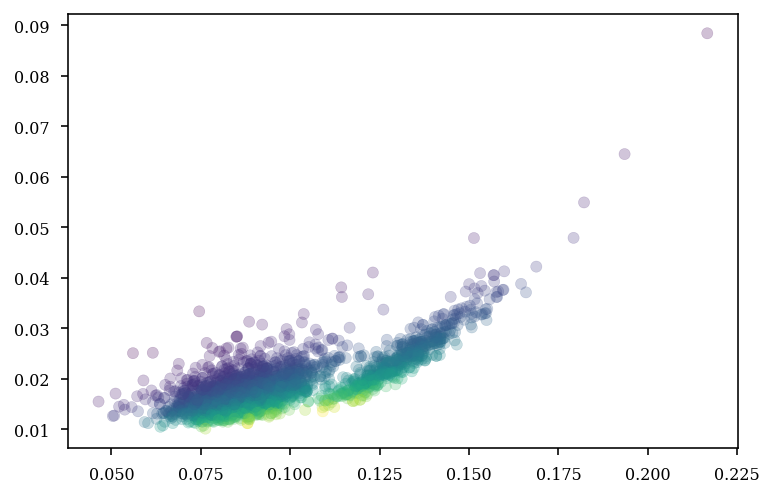

In [367]:
plt.scatter(results['df'].par_std, results['df'].par_sem,
            c=results['df'].n_active_check, alpha=.25)
# plt.yscale('log')
# plt.scatter(results['df'].n_active_check,results['df'].n_active,alpha=.25)


In [351]:
results['df']['replay'] = False

results['df'].loc[results['df']['score_pval_col_cycle'] < 0.05, 'replay'] = True


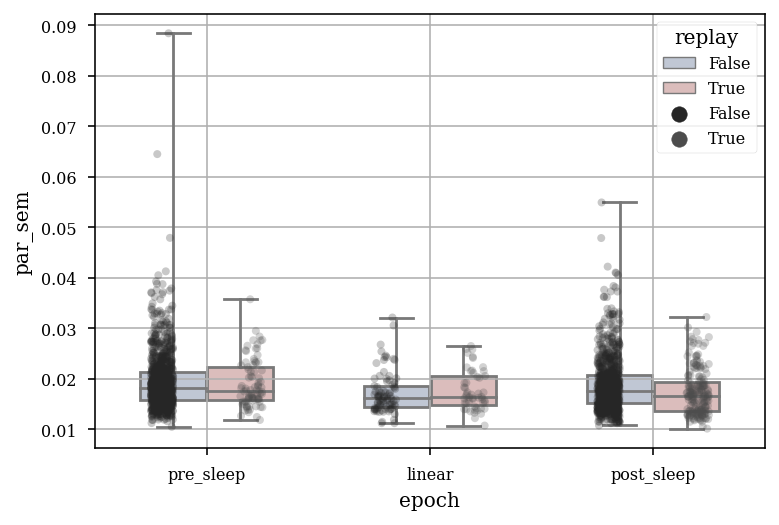

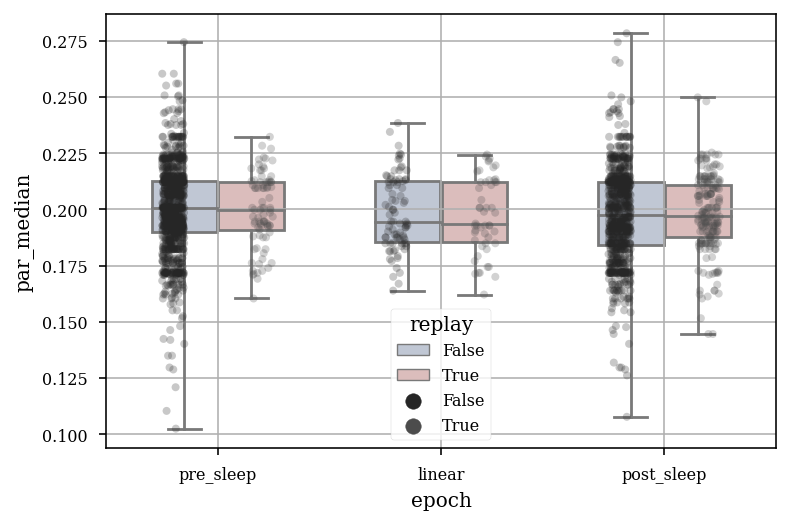

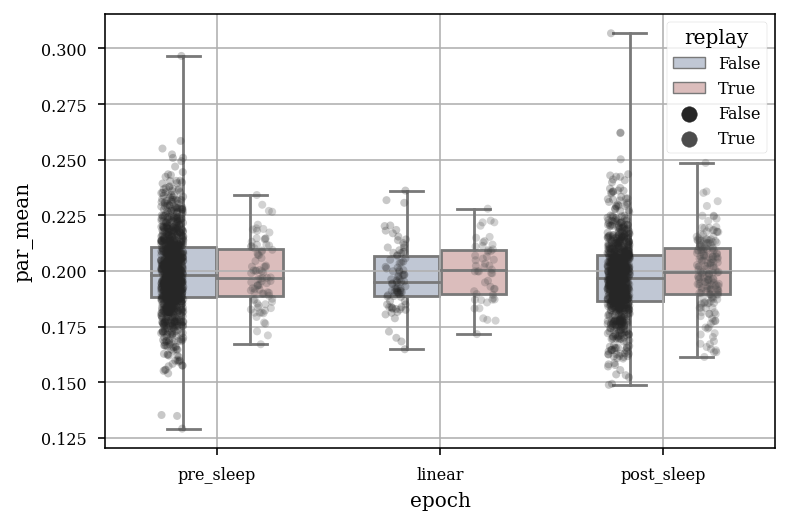

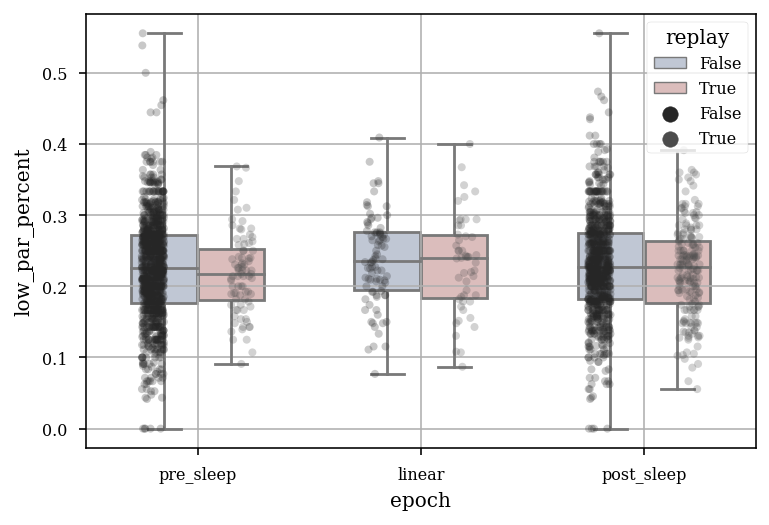

In [370]:
# plt.figure()

# sns.histplot(
#     results['df'],
#     x="par_std", hue="epoch",
#     edgecolor=".3",
#     linewidth=.5,common_bins=True,common_norm=False,kde=True,element="step",stat="density"
# )

# plt.figure()

# sns.histplot(
#     results['df'],
#     x="par_sem", hue="epoch",
#     edgecolor=".3",
#     linewidth=.5,common_bins=True,common_norm=False,kde=True,element="step",stat="density"
# )
alpha = 0.05
results['df']['replay'] = False
results['df'].loc[results['df']['score_pval_col_cycle'] < alpha, 'replay'] = True

plt.figure()
sns.boxplot(x="epoch", y="par_sem", hue='replay', data=results['df'],
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="epoch", y="par_sem", hue='replay', data=results['df'],
              size=4, color=".3", linewidth=0, dodge=True, alpha=.25)
# plt.yscale('log')
plt.grid()

plt.figure()
sns.boxplot(x="epoch", y="par_median", hue='replay', data=results['df'],
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="epoch", y="par_median", hue='replay', data=results['df'],
              size=4, color=".3", linewidth=0, dodge=True, alpha=.25)
plt.grid()

plt.figure()
sns.boxplot(x="epoch", y="par_mean", hue='replay', data=results['df'],
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="epoch", y="par_mean", hue='replay', data=results['df'],
              size=4, color=".3", linewidth=0, dodge=True, alpha=.25)
plt.grid()

plt.figure()
sns.boxplot(x="epoch", y="low_par_percent", hue='replay', data=results['df'],
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="epoch", y="low_par_percent", hue='replay', data=results['df'],
              size=4, color=".3", linewidth=0, dodge=True, alpha=.25)
plt.grid()
# plt.figure()
# sns.histplot(
#     results['df'],
#     x="par_std", hue=results['df']['score_pval_col_cycle'] < 0.05,
#     edgecolor=".3",
#     linewidth=.5,common_bins=True,common_norm=False,kde=True,element="step",stat="density"
# )
# plt.axvline(0.105,color='k')


In [ ]:
vars = ["amplitude", "duration", "frequency",
        "n_active", "inactive_bin_prop", "trajectory_score",
        "r_squared", "slope", "score_pval_time_swap",
        "score_pval_col_cycle", "traj_dist", "traj_speed", "traj_step", "par_std"]

ax = sns.pairplot(results['df'], hue='epoch', corner=True,
                  x_vars=vars, y_vars=vars)


In [ ]:
alpha = 0.05
idx = np.where(
    (results[direction]['df']['score_pval_col_cycle'] < alpha) &
    (results[direction]['df']['epoch'] == 'pre_sleep')
)[0]

ax, fig = replay_fig.plot_all_replay(results[direction]['bst_placecells'][idx],
                                     results[direction]['sta_placecells'],
                                     results[direction]['tc'],
                                     results[direction]['tc'],
                                     vmax=.1,
                                     title_str="",
                                     custom_raster_color=True,
                                     color_scale_vector=unit_partic_pre_task,
                                     raster_lw=2,
                                     raster_lh=2,
                                     rasterized_heatmap=True)
# color_scale_vector=np.log10(unit_partic_pre_task),

idx = np.where(
    (results[direction]['df']['score_pval_col_cycle'] < alpha) &
    (results[direction]['df']['epoch'] == 'linear')
)[0]

ax, fig = replay_fig.plot_all_replay(results[direction]['bst_placecells'][idx],
                                     results[direction]['sta_placecells'],
                                     results[direction]['tc'],
                                     results[direction]['tc'],
                                     vmax=.1,
                                     title_str="",
                                     custom_raster_color=True,
                                     color_scale_vector=unit_partic_pre_task,
                                     raster_lw=2,
                                     raster_lh=2,
                                     rasterized_heatmap=True)

idx = np.where(
    (results[direction]['df']['score_pval_col_cycle'] < alpha) &
    (results[direction]['df']['epoch'] == 'post_sleep')
)[0]

ax, fig = replay_fig.plot_all_replay(results[direction]['bst_placecells'][idx],
                                     results[direction]['sta_placecells'],
                                     results[direction]['tc'],
                                     results[direction]['tc'],
                                     vmax=.1,
                                     title_str="",
                                     custom_raster_color=True,
                                     color_scale_vector=unit_partic_pre_task,
                                     raster_lw=2,
                                     raster_lh=2,
                                     rasterized_heatmap=True)


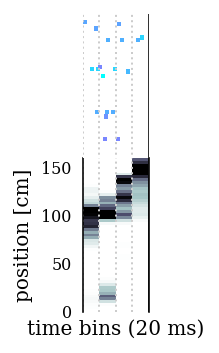

In [173]:

# idx = np.where(results['df']['score_pval_col_cycle'] < 0.01)[0][-20:]

idx = np.where(
    (results[direction]['df']['score_pval_col_cycle'] < alpha) &
    (results[direction]['df']['epoch'] == 'pre_sleep')
)[0][52]

ax, fig = replay_fig.plot_all_replay(results[direction]['bst_placecells'][int(idx)],
                                     results[direction]['sta_placecells'],
                                     results[direction]['tc'],
                                     results[direction]['tc'],
                                     vmax=.1,
                                     title_str="",
                                     custom_raster_color=True,
                                     color_scale_vector=unit_partic_pre_task,
                                     raster_lw=2,
                                     raster_lh=2,
                                     rasterized_heatmap=True)

fig.savefig(os.path.join(fig_save_path, 'pre_task_replay_example.svg'),
            dpi=300, bbox_inches='tight')


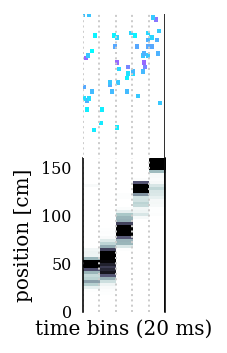

In [174]:
idx = np.where(
    (results[direction]['df']['score_pval_col_cycle'] < 0.05) &
    (results[direction]['df']['epoch'] == 'linear')
)[0][4]

ax, fig = replay_fig.plot_all_replay(results[direction]['bst_placecells'][int(idx)],
                                     results[direction]['sta_placecells'],
                                     results[direction]['tc'],
                                     results[direction]['tc'],
                                     vmax=.1,
                                     title_str="",
                                     custom_raster_color=True,
                                     color_scale_vector=unit_partic_pre_task,
                                     raster_lw=2,
                                     raster_lh=2,
                                     rasterized_heatmap=True)
fig.savefig(os.path.join(fig_save_path, 'task_replay_example.svg'),
            dpi=300, bbox_inches='tight')


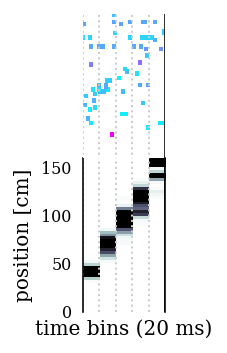

In [175]:
idx = np.where(
    (results[direction]['df']['score_pval_col_cycle'] < 0.05) &
    (results[direction]['df']['epoch'] == 'post_sleep')
)[0][70]

idx = int(idx)
ax, fig = replay_fig.plot_all_replay(results[direction]['bst_placecells'][idx],
                                     results[direction]['sta_placecells'],
                                     results[direction]['tc'],
                                     results[direction]['tc'],
                                     vmax=.1,
                                     title_str="",
                                     custom_raster_color=True,
                                     color_scale_vector=unit_partic_pre_task,
                                     raster_lw=2,
                                     raster_lh=2,
                                     rasterized_heatmap=True)
fig.savefig(os.path.join(fig_save_path, 'post_task_replay_example.svg'),
            dpi=300, bbox_inches='tight')


In [194]:
# plt.cm.cool
# plt.get_cmap('cool')

# norm = plt.Normalize()
# colors = plt.get_cmap('cool')(norm(unit_partic_pre_task))
# colors


## deep superficial raster example

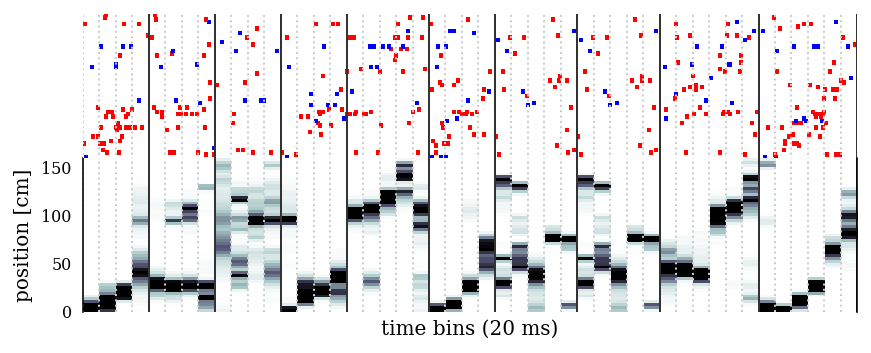

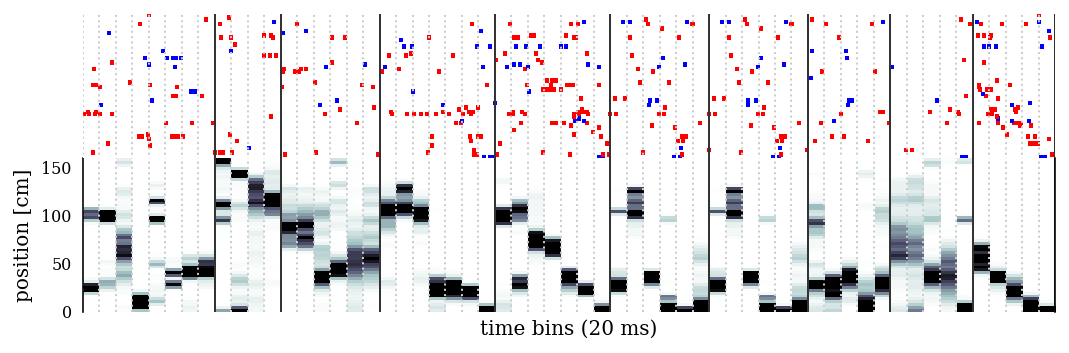

In [216]:
idx = np.where(
    (results[direction]['df']['score_pval_col_cycle'] < 0.05) &
    (results[direction]['df']['epoch'] == 'post_sleep') &
    (results[direction]['df']['replay_type'] == 'forward')
)[0][0:10]

# idx = int(idx)
ax, fig = replay_fig.plot_all_replay(results[direction]['bst_placecells'][idx],
                                     results[direction]['sta_placecells'],
                                     results[direction]['tc'],
                                     results[direction]['tc'],
                                     vmax=.1,
                                     title_str="",
                                     custom_raster_color=True,
                                     color_scale_vector=results[direction]['cell_metrics'].deepSuperficial == 'Deep',
                                     raster_lw=2,
                                     raster_lh=2,
                                     rasterized_heatmap=True,
                                     cmap='bwr')
idx = np.where(
    (results[direction]['df']['score_pval_col_cycle'] < 0.05) &
    (results[direction]['df']['epoch'] == 'post_sleep') &
    (results[direction]['df']['replay_type'] == 'reverse')
)[0][10:20]

# idx = int(idx)
ax, fig = replay_fig.plot_all_replay(results[direction]['bst_placecells'][idx],
                                     results[direction]['sta_placecells'],
                                     results[direction]['tc'],
                                     results[direction]['tc'],
                                     vmax=.1,
                                     title_str="",
                                     custom_raster_color=True,
                                     color_scale_vector=results[direction]['cell_metrics'].deepSuperficial == 'Deep',
                                     raster_lw=2,
                                     raster_lh=2,
                                     rasterized_heatmap=True,
                                     cmap='bwr')


## Demonstrate that sig replay events benifit from recruiting units with low ripple participation probability

In [18]:
def shuffle_matrices(A, B, n_shuffles=1500):
    """
    shuffle_matrices: takes two matrices (A,B) with same n rows
        and randomly exchanges columns n_shuffles times
    """
    a_partic_shuff = np.zeros((A.shape[0], n_shuffles))
    b_partic_shuff = np.zeros_like(a_partic_shuff)

    for shuff_i in range(n_shuffles):
        # find number of columns to exchange based on the smallest matrix
        n_rearange = np.min([A.shape[1], B.shape[1]])
        # get n_rearange number of random columns to exchange scaled to each matrix
        idx_a = random.sample(range(0, A.shape[1]), n_rearange)
        idx_b = random.sample(range(0, B.shape[1]), n_rearange)
        # make copy of matrice to manipulate
        temp_a = A.copy()
        temp_b = B.copy()
        # use random column index to exchange columns between matrices
        temp_a[:, idx_a] = B[:, idx_b]
        temp_b[:, idx_b] = A[:, idx_a]
        # calculate participation prob. and save
        a_partic_shuff[:, shuff_i] = temp_a.mean(axis=1)
        b_partic_shuff[:, shuff_i] = temp_b.mean(axis=1)
    return a_partic_shuff, b_partic_shuff


def shuffle_matrices_v2(A, B, n_shuffles=1500):
    """
    shuffle_matrices: takes two matrices (A,B) with same n rows
        and randomly exchanges columns n_shuffles times
    """
    a_partic_shuff = np.zeros((A.shape[0], n_shuffles))
    b_partic_shuff = np.zeros_like(a_partic_shuff)

    X = np.concatenate([A, B], axis=1)

    for shuff_i in range(n_shuffles):

        idx_a = random.sample(range(0, X.shape[1]), A.shape[1])
        idx_b = random.sample(range(0, X.shape[1]), B.shape[1])

        a_partic_shuff[:, shuff_i] = X[:, idx_a].mean(axis=1)
        b_partic_shuff[:, shuff_i] = X[:, idx_b].mean(axis=1)

    return a_partic_shuff, b_partic_shuff


In [ ]:
# alpha = 0.05
# df = df.sort_values(by=['basepath','start'])

# for basepath in df.basepath.unique():
#     save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.pkl')

#     with open(save_file, 'rb') as f:
#         results = pickle.load(f)

#     temp_df = df[df.basepath == basepath]

#     for direction in temp_df.direction.unique():
#         st = results[direction]['sta_placecells']
#         ripple_epochs = nel.EpochArray([np.array([results[direction]['df'].start,results[direction]['df'].stop]).T])
#         epoch_df = loading.load_epoch(basepath)
#         behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,epoch_df.stopTime]).T])

#         sig_replay_epochs = nel.EpochArray([np.array([results['df'].start[results['df'].score_pval_col_cycle < alpha],
#                                             results['df'].stop[results['df'].score_pval_col_cycle < alpha]]).T])

#         non_sig_replay_epochs = nel.EpochArray([np.array([results['df'].start[results['df'].score_pval_col_cycle > alpha],
#                                                     results['df'].stop[results['df'].score_pval_col_cycle > alpha]]).T])


In [19]:
alpha = 0.05

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

sessions = glob.glob(save_path + os.sep + '*.pkl')
UID = []
unit_partic_post_sig_replay = []
unit_partic_pre_task = []
unit_partic_post_non_sig_replay = []
particip_mat_pre_ripple_shuff = []
particip_mat_post_replay_shuff = []
avg_fr_not_rip_pre_task = []
avg_fr_in_rip_pre_task = []
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    basepath = results['outbound_epochs']['session']
    for direction in results.keys():

        ripple_epochs = nel.EpochArray(
            [np.array([results[direction]['df'].start, results[direction]['df'].stop]).T])
        epoch_df = loading.load_epoch(basepath)
        pattern_idx, _ = functions.find_epoch_pattern(
            epoch_df.environment, ['sleep', 'linear', 'sleep'])
        epoch_df = epoch_df[pattern_idx]
        behavioral_epochs = nel.EpochArray(
            [np.array([epoch_df.startTime, epoch_df.stopTime]).T])
        st = results[direction]['sta_placecells']

        sig_idx = results[direction]['df'].score_pval_col_cycle > alpha
        sig_replay_epochs = nel.EpochArray([np.array([results[direction]['df'].start[sig_idx],
                                                      results[direction]['df'].stop[sig_idx]]).T])
        non_sig_idx = results[direction]['df'].score_pval_col_cycle > alpha
        non_sig_replay_epochs = nel.EpochArray([np.array([results[direction]['df'].start[non_sig_idx],
                                                          results[direction]['df'].stop[non_sig_idx]]).T])
        # post task replay participation prob.
        starts = sig_replay_epochs[behavioral_epochs[2]].starts
        stops = sig_replay_epochs[behavioral_epochs[2]].stops
        if len(starts) == 0:
            unit_partic_post_sig_replay.append(
                np.tile(np.nan, st.data.shape[0]))
            particip_mat_post_replay = np.tile(
                np.nan, [st.data.shape[0], len(starts)])
        else:
            particip_mat_post_replay = functions.get_participation(
                st.data, starts, stops)
            unit_partic_post_sig_replay.append(
                particip_mat_post_replay.mean(axis=1))

        # post task non-replay participation prob.
        starts = non_sig_replay_epochs[behavioral_epochs[2]].starts
        stops = non_sig_replay_epochs[behavioral_epochs[2]].stops
        if len(starts) == 0:
            unit_partic_post_non_sig_replay.append(
                np.tile(np.nan, st.data.shape[0]))
        else:
            particip_mat = functions.get_participation(st.data, starts, stops)
            unit_partic_post_non_sig_replay.append(particip_mat.mean(axis=1))

        # pre task ripple participation prob
        starts = ripple_epochs[behavioral_epochs[0]].starts
        stops = ripple_epochs[behavioral_epochs[0]].stops
        if len(starts) == 0:
            unit_partic_pre_task.append(np.tile(np.nan, st.data.shape[0]))
            particip_mat_pre_ripple = np.tile(
                np.nan, [st.data.shape[0], len(starts)])
        else:
            particip_mat_pre_ripple = functions.get_participation(
                st.data, starts, stops)
            unit_partic_pre_task.append(particip_mat_pre_ripple.mean(axis=1))

        if len(ripple_epochs) == 0:
            avg_fr_not_rip_pre_task.append(np.tile(np.nan, st.data.shape[0]))
            avg_fr_in_rip_pre_task.append(np.tile(np.nan, st.data.shape[0]))
        else:
            avg_fr_not_rip_pre_task.append(
                st[behavioral_epochs[0]][~ripple_epochs].n_spikes / st[behavioral_epochs[0]][~ripple_epochs].support.duration)
            avg_fr_in_rip_pre_task.append(
                st[behavioral_epochs[0]][ripple_epochs].n_spikes / st[behavioral_epochs[0]][ripple_epochs].support.duration)

        # shuffle identity from pre to post
        # a_shuff,b_shuff = shuffle_matrices(particip_mat_pre_ripple,particip_mat_post_replay)
        a_shuff, b_shuff = shuffle_matrices_v2(
            particip_mat_pre_ripple, particip_mat_post_replay)
        particip_mat_pre_ripple_shuff.append(a_shuff)
        particip_mat_post_replay_shuff.append(b_shuff)

        UID.append(results[direction]['cell_metrics'].UID)

pre_post_df = pd.DataFrame()
pre_post_df['UID'] = np.hstack(UID)
pre_post_df['avg_fr_not_rip_pre_task'] = np.hstack(avg_fr_not_rip_pre_task)
pre_post_df['avg_fr_in_rip_pre_task'] = np.hstack(avg_fr_in_rip_pre_task)

pre_post_df['unit_partic_pre_task'] = np.hstack(unit_partic_pre_task)
pre_post_df['unit_partic_post_sig_replay'] = np.hstack(
    unit_partic_post_sig_replay)
pre_post_df['unit_partic_post_non_sig_replay'] = np.hstack(
    unit_partic_post_non_sig_replay)

particip_mat_pre_ripple_shuff = np.vstack(particip_mat_pre_ripple_shuff)
particip_mat_post_replay_shuff = np.vstack(particip_mat_post_replay_shuff)

C:\Users\Cornell\AppData\Local\Temp/ipykernel_15708/1053295117.py:43: RuntimeWarning: Mean of empty slice.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\AppData\Local\Temp/ipykernel_15708/1053295117.py:42: RuntimeWarning: Mean of empty slice.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\AppData\Local\Temp/ipykernel_15708/1053295117.py:43: RuntimeWarning: Mean of empty slice.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_15708/1053295117.py:42: RuntimeWarning: Mean of empty slice.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Cornell\AppData\Local\Temp/ipykernel_15708/1053295117.py:43: RuntimeWarning: Mean of empty slice.


In [20]:
y = (
    (pre_post_df.unit_partic_post_sig_replay-pre_post_df.unit_partic_pre_task) /
    (pre_post_df.unit_partic_post_sig_replay+pre_post_df.unit_partic_pre_task)
)
y = y.values
y_shuff = (
    (particip_mat_post_replay_shuff-particip_mat_pre_ripple_shuff) /
    (particip_mat_post_replay_shuff+particip_mat_pre_ripple_shuff)
)
sig_event_idx, pvalues = functions.get_significant_events(y, y_shuff)

pre_post_df['pre_post_ratio_pvalues'] = pvalues
pre_post_df

UID  avg_fr_not_rip_pre_task  avg_fr_in_rip_pre_task  \
0      3                 1.215257                3.127299   
1      7                 1.442628                2.685798   
2     11                 0.414286                2.023547   
3     12                 1.364278                4.332230   
4     16                 0.880991                4.065489   
..   ...                      ...                     ...   
691   75                 0.558997                2.250514   
692   76                 0.549442                3.858025   
693   77                 2.597940                3.097136   
694   82                 1.829301                4.522462   
695   84                 2.224841               17.961248   

     unit_partic_pre_task  unit_partic_post_sig_replay  \
0                0.256206                     0.231614   
1                0.207447                     0.268935   
2                0.148050                     0.145993   
3                0.328014                     0.373216   
4                0.294326                     0.323820   
..                    ...                          ...   
691              0.202532                     0.527168   
692              0.291139                     0.313295   
693              0.233474                     0.139884   
694              0.388186                     0.445087   
695              0.746835                     0.554913   

     unit_partic_post_non_sig_replay  pre_post_ratio_pvalues  
0                           0.231614                0.069287  
1                           0.268935                0.000666  
2                           0.145993                0.860759  
3                           0.373216                0.005330  
4                           0.323820                0.041306  
..                               ...                     ...  
691                         0.527168                0.000666  
692                         0.313295                0.195869  
693                         0.139884                0.000666  
694                         0.445087                0.003331  
695                         0.554913                0.000666  

[696 rows x 7 columns]

In [21]:
pre_post_df = pre_post_df.dropna()


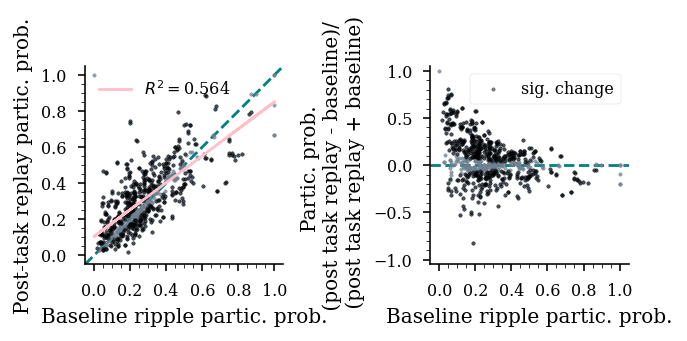

In [22]:
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

fig, axs = plt.subplots(1, 2, figsize=functions.set_size(
    'thesis', fraction=1, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace=0, wspace=.1)
axs = axs.ravel()

x, y = pre_post_df.unit_partic_pre_task, pre_post_df.unit_partic_post_sig_replay
reg = LinearRegression().fit(np.expand_dims(x, axis=1), y)
axs[0].scatter(x, y, s=3, alpha=.75, color='slategrey')
axs[0].scatter(x[pre_post_df.pre_post_ratio_pvalues < 0.05],
               y[pre_post_df.pre_post_ratio_pvalues < 0.05], s=3, alpha=.5, color='k')

axs[0].plot(x, x*reg.coef_+reg.intercept_,
            color='pink',
            label='$R^2=$'+str('%.3f' % (reg.score(np.expand_dims(x, axis=1), y))))

y = (
    (pre_post_df.unit_partic_post_sig_replay-pre_post_df.unit_partic_pre_task) /
    (pre_post_df.unit_partic_post_sig_replay+pre_post_df.unit_partic_pre_task)
)
y = y.values

x = pre_post_df.unit_partic_pre_task.values
axs[1].scatter(x, y, s=3, alpha=.75, color='slategrey')
axs[1].scatter(x[pre_post_df.pre_post_ratio_pvalues < 0.05],
               y[pre_post_df.pre_post_ratio_pvalues < 0.05], s=3, color='k', alpha=.5, label='sig. change')

axs[1].set_xlim(-.05, 1.05)
axs[1].set_ylim(-1.05, 1.05)

axs[1].axhline(0, color='teal', ls='--', zorder=-100)
axs[1].set_aspect(1./axs[1].get_data_ratio())
axs[1].set_xticks(np.arange(0, 1.1, .2))

axs[0].set_xlim(-.05, 1.05)
axs[0].set_ylim(-.05, 1.05)
axs[0].set_aspect('equal')
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes,
            color='teal', ls='--', zorder=-100)
axs[0].set_xticks(np.arange(0, 1.1, .2))
axs[0].set_yticks(np.arange(0, 1.1, .2))

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[0].set_xlabel('Baseline ripple partic. prob.')
axs[0].set_ylabel('Post-task replay partic. prob.')

axs[1].set_xlabel('Baseline ripple partic. prob.')
axs[1].set_ylabel(
    'Partic. prob. \n (post task replay - baseline)/ \n (post task replay + baseline)')

axs[0].legend(frameon=False)
axs[1].legend(frameon=True)

plt.savefig(os.path.join(fig_save_path,
            'rip_particip_replay_particip_pre_post.svg'), dpi=300, bbox_inches='tight')


## look at baseline FR

No handles with labels found to put in legend.


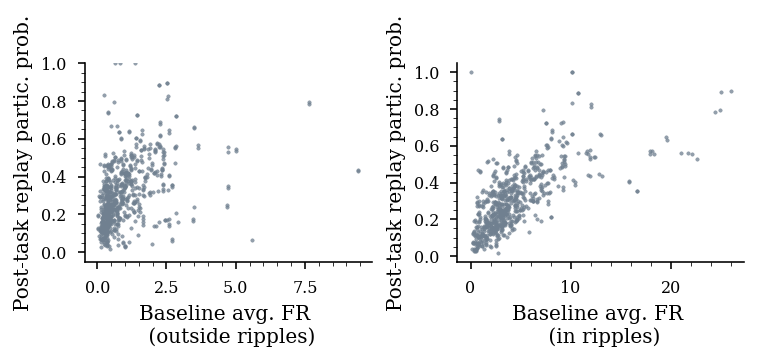

In [23]:
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

fig, axs = plt.subplots(1, 2, figsize=functions.set_size(
    'thesis', fraction=1, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace=0, wspace=.3)
axs = axs.ravel()

x, y = pre_post_df.avg_fr_not_rip_pre_task, pre_post_df.unit_partic_post_sig_replay
reg = LinearRegression().fit(np.expand_dims(x, axis=1), y)
axs[0].scatter(x, y, s=3, alpha=.75, color='slategrey')
# axs[0].plot(x,x*reg.coef_+reg.intercept_,
#             color='k',
#             label='$R^2=$'+str('%.3f'%(reg.score(np.expand_dims(x,axis=1),y))))

axs[0].set_ylim(-.05, 1)
axs[0].set_yticks(np.arange(0, 1.1, .2))

x, y = pre_post_df.avg_fr_in_rip_pre_task, pre_post_df.unit_partic_post_sig_replay
reg = LinearRegression().fit(np.expand_dims(x, axis=1), y)
axs[1].scatter(x, y, s=3, alpha=.75, color='slategrey')
# axs[1].plot(x,x*reg.coef_+reg.intercept_,
#             color='k',
#             label='$R^2=$'+str('%.3f'%(reg.score(np.expand_dims(x,axis=1),y))))

axs[0].set_ylim(-.05, 1)
axs[0].set_yticks(np.arange(0, 1.1, .2))

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[0].set_xlabel('Baseline avg. FR \n (outside ripples)')
axs[0].set_ylabel('Post-task replay partic. prob.')

axs[1].set_xlabel('Baseline avg. FR \n (in ripples)')
axs[1].set_ylabel('Post-task replay partic. prob.')
# axs[0].set_xscale('log')
axs[0].legend(frameon=False)

plt.savefig(os.path.join(fig_save_path,
            'rip_particip_replay_particip_pre_post_FR.svg'), dpi=300, bbox_inches='tight')


In [ ]:
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

fig, axs = plt.subplots(1, 2, figsize=functions.set_size(
    'thesis', fraction=1, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace=0, wspace=.1)
axs = axs.ravel()

x, y = unit_partic_pre_task, unit_partic_post_non_sig_replay
reg = LinearRegression().fit(np.expand_dims(x, axis=1), y)
axs[0].scatter(x, y, s=3, alpha=.75, color='slategrey')
axs[0].plot(x, x*reg.coef_+reg.intercept_,
            color='k',
            label='$R^2=$'+str('%.3f' % (reg.score(np.expand_dims(x, axis=1), y))))

y = (unit_partic_post_non_sig_replay-unit_partic_pre_task) / \
    (unit_partic_post_non_sig_replay+unit_partic_pre_task)
# y_shuff = (
#             (particip_mat_post_replay_shuff-particip_mat_pre_ripple_shuff) /
#                 (particip_mat_post_replay_shuff+particip_mat_pre_ripple_shuff)
#             )
# sig_event_idx, pvalues = functions.get_significant_events(y,y_shuff.T)

x = unit_partic_pre_task
axs[1].scatter(x, y, s=3, alpha=.75, color='slategrey')
# axs[1].scatter(x[pvalues<0.05], y[pvalues<0.05],s=3,color='k',label='sig. change')

axs[1].set_xlim(-.05, 1)
axs[1].set_ylim(-1.05, 1.05)

axs[1].axhline(0, color='teal', ls='--', zorder=-100)
axs[1].set_aspect(1./axs[1].get_data_ratio())
axs[1].set_xticks(np.arange(0, 1.1, .2))

axs[0].set_xlim(-.05, 1)
axs[0].set_ylim(-.05, 1)
axs[0].set_aspect('equal')
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes,
            color='teal', ls='--', zorder=-100)
axs[0].set_xticks(np.arange(0, 1.1, .2))
axs[0].set_yticks(np.arange(0, 1.1, .2))

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[0].set_xlabel('Baseline ripple partic. prob.', fontsize=8)
axs[0].set_ylabel('Post-task non-replay \n partic. prob.', fontsize=8)

axs[1].set_xlabel('Baseline ripple partic. prob.', fontsize=8)
axs[1].set_ylabel(
    'Partic. prob. \n (post task non replay - baseline)/ \n (post task non replay + baseline)', fontsize=8)

axs[0].legend(frameon=False)
axs[1].legend(frameon=True)

# plt.savefig(os.path.join(fig_save_path,'rip_particip_replay_particip_pre_post.svg'),dpi=300,bbox_inches='tight')


## Look at prop of deep and sup

Hypothesis: sup cells will be less active in preplay

Also look at sup/deep prop of forward backward stationary replay

In [96]:
def get_replay_epochs(results, direction, alpha=0.05):

    if not np.any((direction == "forward") | (direction == "reverse")):
        print("wrong direction")
        return
    starts = []
    stops = []

    idx = (results["outbound_epochs"]["df"].score_pval_time_swap <= alpha) & (
        results["outbound_epochs"]["df"].replay_type == direction
    )
    starts.append(results["outbound_epochs"]["df"][idx].start)
    stops.append(results["outbound_epochs"]["df"][idx].stop)

    idx = (results["inbound_epochs"]["df"].score_pval_time_swap <= alpha) & (
        results["inbound_epochs"]["df"].replay_type == direction
    )
    starts.append(results["inbound_epochs"]["df"][idx].start)
    stops.append(results["inbound_epochs"]["df"][idx].stop)

    sort_idx = np.argsort(np.hstack(starts))

    starts = np.hstack(starts)[sort_idx]
    stops = np.hstack(stops)[sort_idx]

    return nel.EpochArray(np.array([starts, stops]).T)


def compile_dataframe(
    basepath,
    sta_placecells,
    behavior_epochs,
    forward_replay,
    reverse_replay,
    ripple_epochs,
    cell_metrics,
):

    rip_par = [
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[0][ripple_epochs].starts,
            behavior_epochs[0][ripple_epochs].stops,
        ).mean(axis=1),
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[1][ripple_epochs].starts,
            behavior_epochs[1][ripple_epochs].stops,
        ).mean(axis=1),
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[2][ripple_epochs].starts,
            behavior_epochs[2][ripple_epochs].stops,
        ).mean(axis=1),
    ]

    #  forward
    par = [
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[0][forward_replay].starts,
            behavior_epochs[0][forward_replay].stops,
        ).mean(axis=1),
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[1][forward_replay].starts,
            behavior_epochs[1][forward_replay].stops,
        ).mean(axis=1),
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[2][forward_replay].starts,
            behavior_epochs[2][forward_replay].stops,
        ).mean(axis=1),
    ]
    epoch = [
        ["pre"] * sta_placecells.data.shape[0],
        ["task"] * sta_placecells.data.shape[0],
        ["post"] * sta_placecells.data.shape[0],
    ]

    n_replays = [
        np.tile(
            len(behavior_epochs[0][forward_replay].starts), sta_placecells.data.shape[0]
        ),
        np.tile(
            len(behavior_epochs[1][forward_replay].starts), sta_placecells.data.shape[0]
        ),
        np.tile(
            len(behavior_epochs[2][forward_replay].starts), sta_placecells.data.shape[0]
        ),
    ]

    par_df_forward = pd.DataFrame()
    par_df_forward["participation"] = np.hstack(par)
    par_df_forward["rip_par"] = np.hstack(rip_par)
    par_df_forward["epoch"] = np.hstack(epoch)
    par_df_forward["n_replays"] = np.hstack(n_replays)
    par_df_forward["UID"] = np.hstack(
        [cell_metrics.UID, cell_metrics.UID, cell_metrics.UID]
    )
    par_df_forward["deepSuperficial"] = np.hstack(
        [
            cell_metrics.deepSuperficial,
            cell_metrics.deepSuperficial,
            cell_metrics.deepSuperficial,
        ]
    )
    par_df_forward["deepSuperficialDistance"] = np.hstack(
        [
            cell_metrics.deepSuperficialDistance,
            cell_metrics.deepSuperficialDistance,
            cell_metrics.deepSuperficialDistance,
        ]
    )
    par_df_forward["basepath"] = basepath
    par_df_forward["replay_type"] = "forward"

    #  reverse
    par = [
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[0][reverse_replay].starts,
            behavior_epochs[0][reverse_replay].stops,
        ).mean(axis=1),
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[1][reverse_replay].starts,
            behavior_epochs[1][reverse_replay].stops,
        ).mean(axis=1),
        functions.get_participation(
            sta_placecells.data,
            behavior_epochs[2][reverse_replay].starts,
            behavior_epochs[2][reverse_replay].stops,
        ).mean(axis=1),
    ]
    epoch = [
        ["pre"] * sta_placecells.data.shape[0],
        ["task"] * sta_placecells.data.shape[0],
        ["post"] * sta_placecells.data.shape[0],
    ]

    epoch = [
        ["pre"] * sta_placecells.data.shape[0],
        ["task"] * sta_placecells.data.shape[0],
        ["post"] * sta_placecells.data.shape[0],
    ]

    n_replays = [
        np.tile(
            len(behavior_epochs[0][reverse_replay].starts), sta_placecells.data.shape[0]
        ),
        np.tile(
            len(behavior_epochs[1][reverse_replay].starts), sta_placecells.data.shape[0]
        ),
        np.tile(
            len(behavior_epochs[2][reverse_replay].starts), sta_placecells.data.shape[0]
        ),
    ]
    par_df_reverse = pd.DataFrame()
    par_df_reverse["participation"] = np.hstack(par)
    par_df_reverse["rip_par"] = np.hstack(rip_par)
    par_df_reverse["epoch"] = np.hstack(epoch)
    par_df_reverse["n_replays"] = np.hstack(n_replays)
    par_df_reverse["UID"] = np.hstack(
        [cell_metrics.UID, cell_metrics.UID, cell_metrics.UID]
    )
    par_df_reverse["deepSuperficial"] = np.hstack(
        [
            cell_metrics.deepSuperficial,
            cell_metrics.deepSuperficial,
            cell_metrics.deepSuperficial,
        ]
    )
    par_df_reverse["deepSuperficialDistance"] = np.hstack(
        [
            cell_metrics.deepSuperficialDistance,
            cell_metrics.deepSuperficialDistance,
            cell_metrics.deepSuperficialDistance,
        ]
    )
    par_df_reverse["basepath"] = basepath
    par_df_reverse["replay_type"] = "reverse"

    par_df = pd.concat([par_df_forward, par_df_reverse])

    par_df["replay_layer"] = par_df.replay_type + par_df.deepSuperficial

    return par_df


sessions = glob.glob(save_path + os.sep + "*.pkl")
par_df = pd.DataFrame()
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)

    try:
        basepath = results["outbound_epochs"]["df"].basepath.unique()[0]
    except:
        basepath = results["inbound_epochs"]["df"].basepath.unique()[0]

    forward_replay = get_replay_epochs(results, "forward")
    reverse_replay = get_replay_epochs(results, "reverse")

    epoch_df = loading.load_epoch(basepath)
    pattern_idx, _ = functions.find_epoch_pattern(
        epoch_df.environment, ["sleep", "linear", "sleep"]
    )
    epoch_df = epoch_df[pattern_idx]
    behavior_epochs = nel.EpochArray(
        [np.array([epoch_df.startTime, epoch_df.stopTime]).T]
    )

    ripples = loading.load_ripples_events(basepath)
    ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

    # state_dict = loading.load_SleepState_states(basepath)
    # nrem_epochs = nel.EpochArray(state_dict['NREMstate'])
    # wake_epochs = nel.EpochArray(state_dict['WAKEstate'])

    # locate active units that were used in anlysis
    # because out/inbound templates were used seperately, we need to include both
    # always load cell metrics from source to get most up to date data
    st, cell_metrics = loading.load_spikes(basepath)

    uid = pd.unique(
        np.hstack(
            [
                results["outbound_epochs"]["cell_metrics"].UID,
                results["inbound_epochs"]["cell_metrics"].UID,
            ]
        )
    )

    # remove uids with bad waveforms as we can not estimate deep/sup
    if "tags_bad_waveform" in cell_metrics.columns:
        a = set(cell_metrics[cell_metrics.tags_bad_waveform].UID.values)
        b = set(uid)
        c = b.difference(a)
        uid = np.sort(np.array(list(c)))

    _, x_ind, _ = np.intersect1d(cell_metrics.UID, uid, return_indices=True)
    unit_ids_to_keep = (x_ind + 1).squeeze().tolist()
    sta_placecells = st._unit_subset(unit_ids_to_keep)

    cell_metrics = cell_metrics.iloc[x_ind]

    temp_df = compile_dataframe(
        basepath,
        sta_placecells,
        behavior_epochs,
        forward_replay,
        reverse_replay,
        ripple_epochs,
        cell_metrics,
    )
    par_df = pd.concat([par_df, temp_df])


### add Middle layer

In [97]:
deep = -30
middle = [-30,30]
sup = 30

par_df.loc[par_df.deepSuperficialDistance  <= deep, "deepSuperficial"] = "Deep"
par_df.loc[(par_df.deepSuperficialDistance  > middle[0]) & (par_df.deepSuperficialDistance  < middle[1]), "deepSuperficial"] = "middle"
par_df.loc[par_df.deepSuperficialDistance  >= sup, "deepSuperficial"] = "Superficial"

par_df.replay_layer = par_df.replay_type + par_df.deepSuperficial
par_df = par_df[~par_df.deepSuperficial.str.contains("middle")]

par_df['animal'] = [loading.get_animal_id(basepath) for basepath in par_df.basepath]

par_df

participation   rip_par epoch  n_replays  UID deepSuperficial  \
1         0.254545  0.139288   pre         55    7            Deep   
2         0.181818  0.113054   pre         55   11            Deep   
4         0.254545  0.214866   pre         55   16     Superficial   
5         0.145455  0.098480   pre         55   23            Deep   
6         0.327273  0.209036   pre         55   26            Deep   
..             ...       ...   ...        ...  ...             ...   
142       0.717391  0.312309  post         46   75            Deep   
143       0.326087  0.154279  post         46   76            Deep   
144       0.130435  0.091676  post         46   77            Deep   
145       0.456522  0.270106  post         46   82            Deep   
146       0.478261  0.371864  post         46   84            Deep   

     deepSuperficialDistance                                       basepath  \
1                  -40.00000  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013   
2                  -60.00000  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013   
4                   40.00000  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013   
5                  -60.00000  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013   
6                  -60.00000  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013   
..                       ...                                            ...   
142                -40.00000                    Z:\Data\Kenji\ec014.459_480   
143                -60.00000                    Z:\Data\Kenji\ec014.459_480   
144                -80.00000                    Z:\Data\Kenji\ec014.459_480   
145                -92.12865                    Z:\Data\Kenji\ec014.459_480   
146                -92.12865                    Z:\Data\Kenji\ec014.459_480   

    replay_type        replay_layer    animal  
1       forward         forwardDeep  Achilles  
2       forward         forwardDeep  Achilles  
4       forward  forwardSuperficial  Achilles  
5       forward         forwardDeep  Achilles  
6       forward         forwardDeep  Achilles  
..          ...                 ...       ...  
142     reverse         reverseDeep     ec014  
143     reverse         reverseDeep     ec014  
144     reverse         reverseDeep     ec014  
145     reverse         reverseDeep     ec014  
146     reverse         reverseDeep     ec014  

[1632 rows x 11 columns]

In [82]:
# par_df.to_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_df.csv')

In [157]:
par_df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_df.csv')

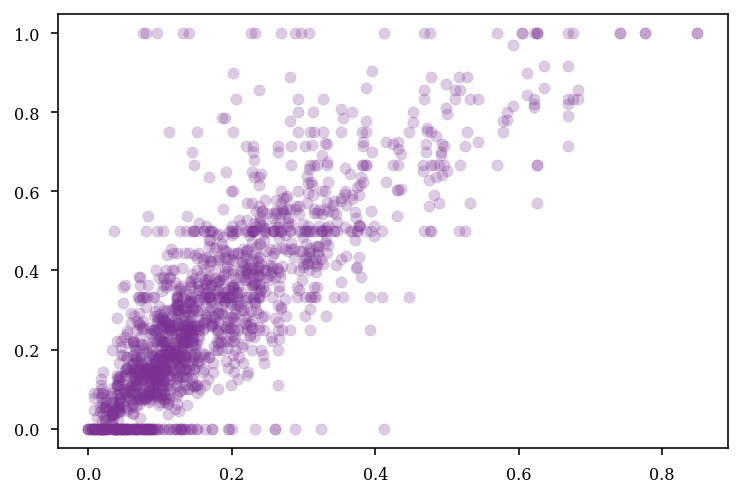

In [158]:
plt.scatter(par_df.rip_par,par_df.participation,alpha=.25)

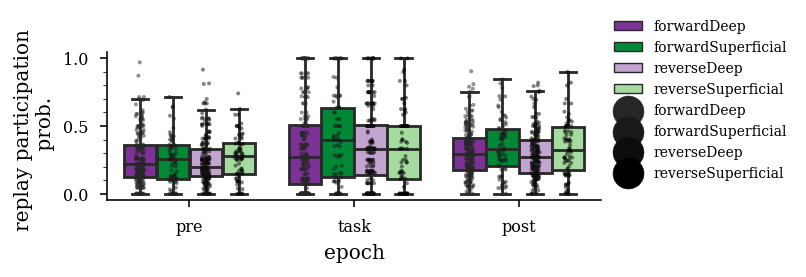

In [28]:
plt.figure(
    figsize=functions.set_size("thesis", fraction=0.75, subplots=(1, 2)), edgecolor=None
)

group_colors = {
    "forwardDeep": "#7b3294",
    "forwardSuperficial": "#008837",
    "reverseDeep": "#c2a5cf",
    "reverseSuperficial": "#a6dba0",
}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()
sns.boxplot(
    x="epoch",
    y="participation",
    hue="replay_layer",
    hue_order=group_colors.keys(),
    saturation=1,
    showfliers=False,
    data=par_df,
    ax=ax,
)

sns.stripplot(
    x="epoch",
    y="participation",
    hue="replay_layer",
    hue_order=group_colors.keys(),
    dodge=True,
    data=par_df,
    size=2,
    color="k",
    linewidth=0,
    alpha=0.5,
    ax=ax,
)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(
    loc="best",
    bbox_to_anchor=(0.9, 0.0, 0.5, 1.3),
    fontsize="x-small",
    frameon=False,
    markerscale=2,
)

ax.set_ylabel("replay participation \n prob.")

plt.savefig(
    os.path.join(fig_save_path, "replay_participation_deep_sup.svg"),
    dpi=300,
    bbox_inches="tight",
)

### look for bias for reverse/forward for subregion

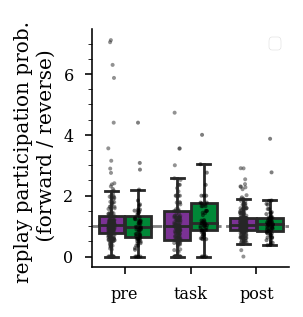

In [190]:
def get_ratio(x, y):
    # return (y - x) / (y + x)
    return x/y


baseline_ratio = get_ratio(
    par_df[(par_df.epoch == "pre") & (par_df.replay_type == "forward")].participation.values,
    par_df[(par_df.epoch == "pre") & (par_df.replay_type == "reverse")].participation.values,
)
task_ratio = get_ratio(
    par_df[(par_df.epoch == "task") & (par_df.replay_type == "forward")].participation.values,
    par_df[(par_df.epoch == "task") & (par_df.replay_type == "reverse")].participation.values,
)
post_ratio = get_ratio(
    par_df[(par_df.epoch == "post") & (par_df.replay_type == "forward")].participation.values,
    par_df[(par_df.epoch == "post") & (par_df.replay_type == "reverse")].participation.values,
)
deepSuperficial = par_df[(par_df.epoch == "pre") & (par_df.replay_type == "forward")].deepSuperficial.values

ratio_df = pd.DataFrame()
ratio_df["deepSuperficial"] = np.hstack([deepSuperficial] * 3)
ratio_df['ratio'] = np.hstack([baseline_ratio, task_ratio, post_ratio])
ratio_df['epoch'] = np.hstack([["pre"]*len(baseline_ratio), ["task"]*len(task_ratio), ["post"]*len(post_ratio)])


plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(2, 1)), edgecolor=None
)


group_colors = {
    "Deep": "#7b3294",
    "Superficial": "#008837"
}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()

sns.boxplot(
    x="epoch",
    y="ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    saturation=1,
    showfliers=False,
    data=ratio_df,
    ax=ax
)
sns.stripplot(
    x="epoch",
    y="ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    dodge=True,
    data=ratio_df,
    size=2,
    color="k",
    linewidth=0,
    alpha=0.5,
    ax=ax,
)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(
    loc="best",
    bbox_to_anchor=(0.5, 0.0, 0.5, 1.2),
    fontsize="x-small",
    frameon=False,
    markerscale=2,
)
ax.axhline(1, color="k", linestyle="--", alpha=0.5,zorder= -1000)
# ax.set_ylabel("replay participation \n (reverse-forward) / (reverse+forward)")
ax.set_ylabel("replay participation prob. \n (forward / reverse)")
ax.set_xlabel("")
ax.legend("")

plt.savefig(
    os.path.join(fig_save_path, "replay_participation_deep_sup_replay_types_ratio.svg"),
    dpi=300,
    bbox_inches="tight",
)

#### paired plots for/rev bias

Text(0, 0.5, 'SUPERFICIAL \n participation')

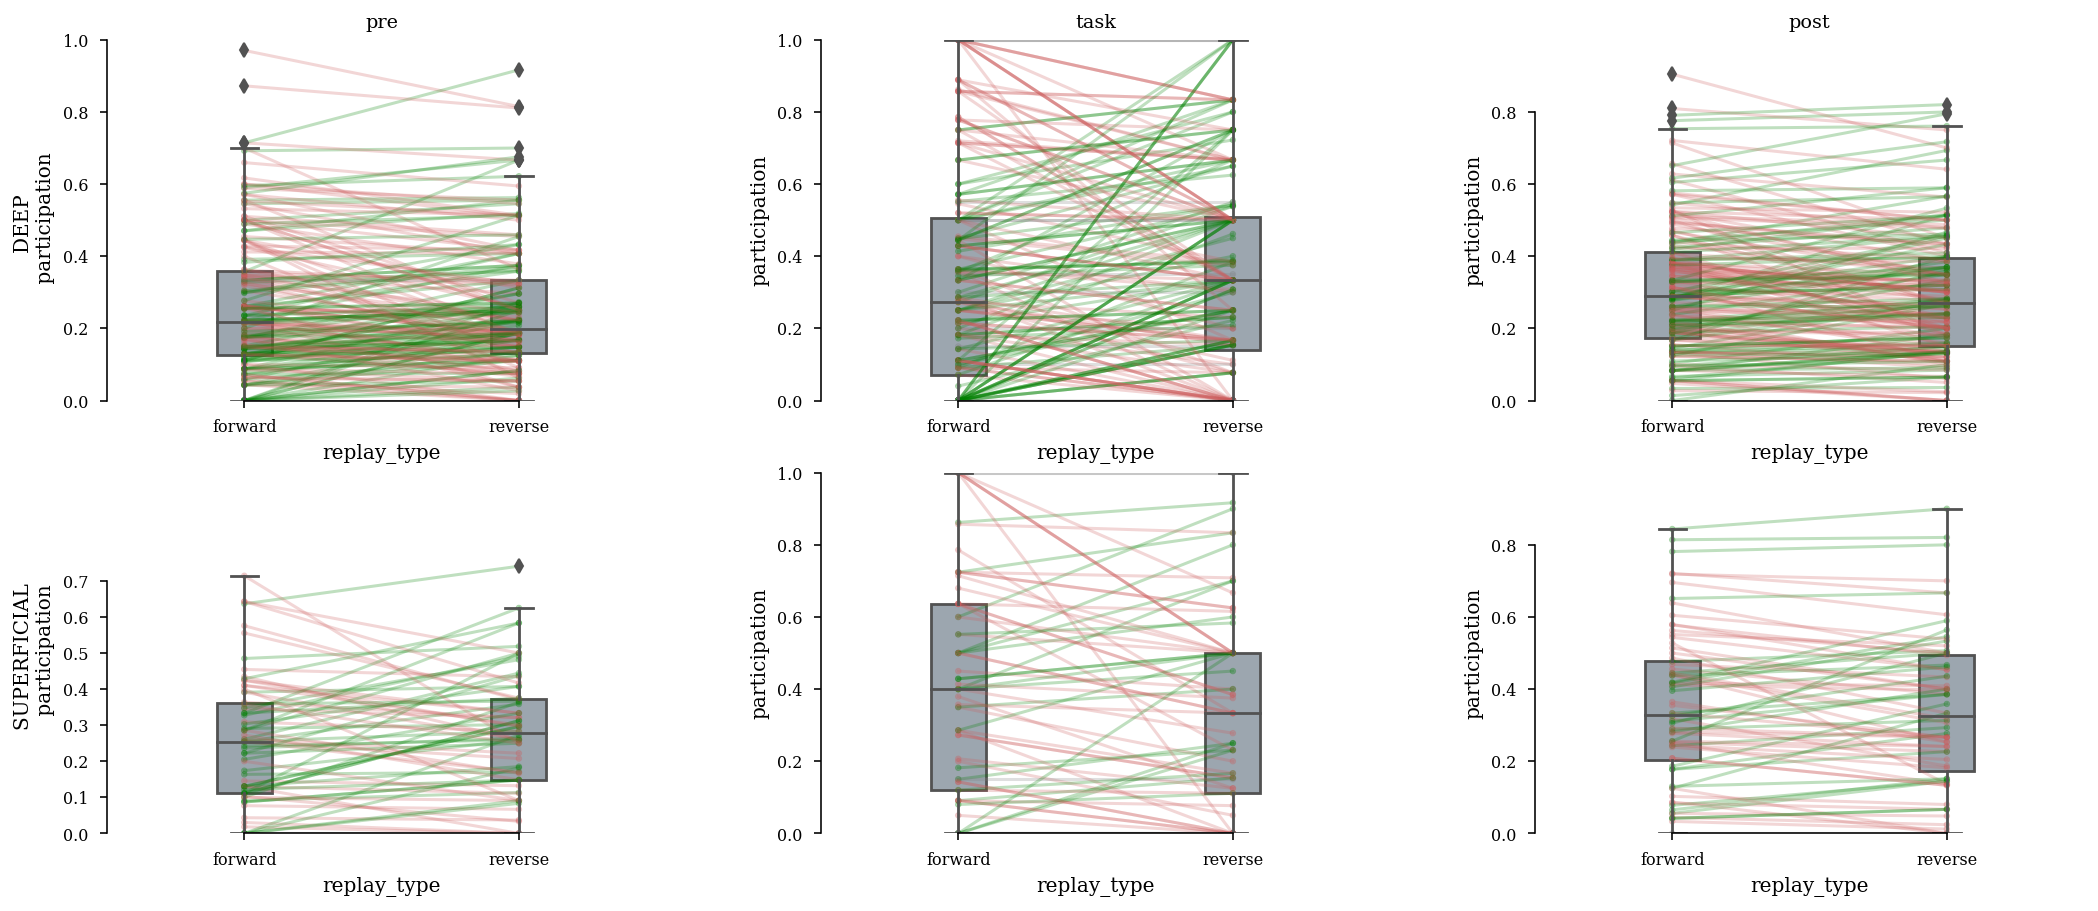

In [177]:
import pingouin as pg
fig, axs = plt.subplots(2, 3, figsize=functions.set_size(
    'thesis', fraction=3, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace=.2, wspace=.3)
axs = axs.ravel()

par_df["basepath_UID"] = par_df.basepath + "_" + par_df.UID.astype(str)

ax = pg.plot_paired(
    data=par_df[(par_df.epoch == "pre") & (par_df.deepSuperficial == "Deep")],
    dv="participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[0],
    pointplot_kwargs={"alpha": 0.25},
)

ax = pg.plot_paired(
    data=par_df[(par_df.epoch == "task") & (par_df.deepSuperficial == "Deep")],
    dv="participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[1],
    pointplot_kwargs={"alpha": 0.25},
)

ax = pg.plot_paired(
    data=par_df[(par_df.epoch == "post") & (par_df.deepSuperficial == "Deep")],
    dv="participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[2],
    pointplot_kwargs={"alpha": 0.25},
)

# same for superficial
ax = pg.plot_paired(
    data=par_df[(par_df.epoch == "pre") & (par_df.deepSuperficial == "Superficial")],
    dv="participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[3],
    pointplot_kwargs={"alpha": 0.25},
)

ax = pg.plot_paired(
    data=par_df[(par_df.epoch == "task") & (par_df.deepSuperficial == "Superficial")],
    dv="participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[4],
    pointplot_kwargs={"alpha": 0.25},
)

ax = pg.plot_paired(
    data=par_df[(par_df.epoch == "post") & (par_df.deepSuperficial == "Superficial")],
    dv="participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[5],
    pointplot_kwargs={"alpha": 0.25},
)

axs[0].set_title("pre")
axs[1].set_title("task")
axs[2].set_title("post")

for i in range(6):
    axs[i].set_ylim(0,1)

axs[0].set_ylabel("DEEP \n participation")
axs[3].set_ylabel("SUPERFICIAL \n participation")

### combine replay types for replay participation

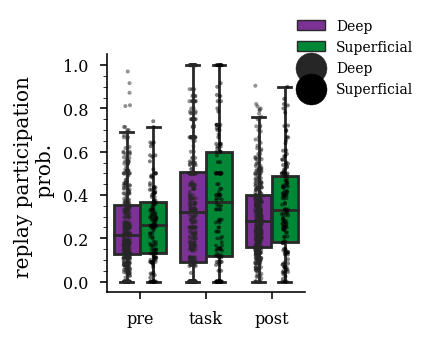

In [74]:
plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(2, 1)), edgecolor=None
)

group_colors = {
    "Deep": "#7b3294",
    "Superficial": "#008837"
}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()

sns.boxplot(
    x="epoch",
    y="participation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    saturation=1,
    showfliers=False,
    data=par_df,
    ax=ax
)
sns.stripplot(
    x="epoch",
    y="participation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    dodge=True,
    data=par_df,
    size=2,
    color="k",
    linewidth=0,
    alpha=0.5,
    ax=ax,
)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(
    loc="best",
    bbox_to_anchor=(0.9, 0.0, 0.5, 1.2),
    fontsize="x-small",
    frameon=False,
    markerscale=2,
)

ax.set_ylabel("replay participation \n prob.")
ax.set_xlabel("")

# ax.set_yscale("log")
plt.savefig(
    os.path.join(fig_save_path, "replay_participation_deep_sup_colapse_replay_types.svg"),
    dpi=300,
    bbox_inches="tight",
)

Text(0.5, 0, '')

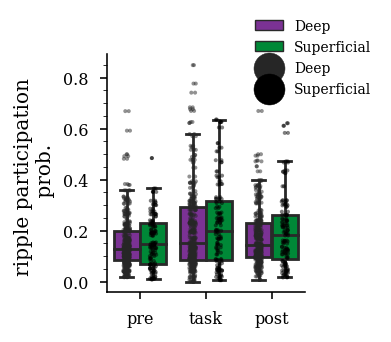

In [159]:
plt.figure(
    figsize=functions.set_size("thesis", fraction=0.3, subplots=(2, 1)), edgecolor=None
)

group_colors = {
    "Deep": "#7b3294",
    "Superficial": "#008837"
}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()

sns.boxplot(
    x="epoch",
    y="rip_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    saturation=1,
    showfliers=False,
    data=par_df,
    ax=ax
)
sns.stripplot(
    x="epoch",
    y="rip_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    dodge=True,
    data=par_df,
    size=2,
    color="k",
    linewidth=0,
    alpha=0.5,
    ax=ax,
)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(
    loc="best",
    bbox_to_anchor=(0.9, 0.0, 0.5, 1.2),
    fontsize="x-small",
    frameon=False,
    markerscale=2,
)

ax.set_ylabel("ripple participation \n prob.")
ax.set_xlabel("")

# ax.set_yscale("log")
# plt.savefig(
#     os.path.join(fig_save_path, "replay_participation_deep_sup_colapse_replay_types.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

#### alternative plot

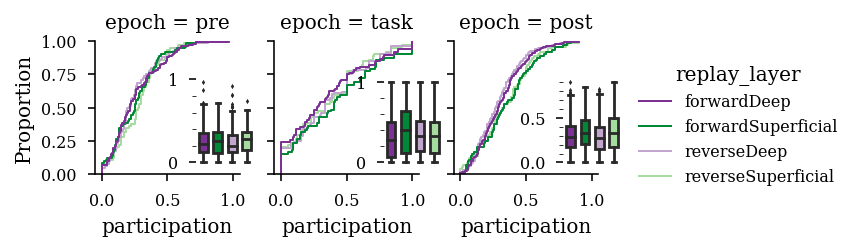

In [29]:
import custom_plots
w, h = functions.set_size('thesis', fraction=1.5, subplots=(1, 3))

group_colors = {"forwardDeep": '#7b3294',
                'forwardSuperficial': '#008837',
                "reverseDeep": '#c2a5cf',
                'reverseSuperficial': '#a6dba0'}

fg = sns.displot(par_df, x="participation", col="epoch", hue="replay_layer",
                 hue_order=group_colors.keys(), kind="ecdf", height=h, aspect=.8, linewidth=1)

g1 = custom_plots.plot_box(par_df[par_df.epoch == 'pre'], 'replay_layer',
                           'participation', fg.axes_dict['pre'], fg.fig, group_colors, x_offset=.12)
g2 = custom_plots.plot_box(par_df[par_df.epoch == 'task'], 'replay_layer',
                           'participation', fg.axes_dict['task'], fg.fig, group_colors, x_offset=.13)
g3 = custom_plots.plot_box(par_df[par_df.epoch == 'post'], 'replay_layer',
                           'participation', fg.axes_dict['post'], fg.fig, group_colors, x_offset=.13)


In [30]:
def get_ratio(x, y):
    return (y - x) / (y + x)
    # return y / x

ratio_pre_task_forward = []
ratio_pre_post_forward = []
ratio_pre_task_reverse = []
ratio_pre_post_reverse = []
deepSuperficial = []
baseline_for = []
baseline_rev = []

rip_par_ratio_pre_task_forward = []
rip_par_ratio_pre_post_forward = []
rip_par_ratio_pre_task_reverse = []
rip_par_ratio_pre_post_reverse = []

for basepath in par_df.basepath.unique():
    for uid in par_df[(par_df.basepath == basepath)].UID.unique():

        baseline_ripple = par_df[(par_df.basepath == basepath) &
                            (par_df.UID == uid) &
                            (par_df.epoch == 'pre') &
                            (par_df.replay_type == 'forward')].rip_par.values
        baseline_forward = par_df[(par_df.basepath == basepath) &
                                  (par_df.UID == uid) &
                                  (par_df.epoch == 'pre') &
                                  (par_df.replay_type == 'forward')].participation.values
        task_forward = par_df[(par_df.basepath == basepath) &
                              (par_df.UID == uid) &
                              (par_df.epoch == 'task') &
                              (par_df.replay_type == 'forward')].participation.values
        post_forward = par_df[(par_df.basepath == basepath) &
                              (par_df.UID == uid) &
                              (par_df.epoch == 'post') &
                              (par_df.replay_type == 'forward')].participation.values

        baseline_for.append(baseline_forward)
        ratio_pre_task_forward.append(get_ratio(baseline_forward, task_forward))
        ratio_pre_post_forward.append(get_ratio(baseline_forward, post_forward))

        rip_par_ratio_pre_task_forward.append(get_ratio(baseline_ripple, task_forward))
        rip_par_ratio_pre_post_forward.append(get_ratio(baseline_ripple, post_forward))

        baseline_reverse = par_df[(par_df.basepath == basepath) &
                                  (par_df.UID == uid) &
                                  (par_df.epoch == 'pre') &
                                  (par_df.replay_type == 'reverse')].participation.values
        task_reverse = par_df[(par_df.basepath == basepath) &
                              (par_df.UID == uid) &
                              (par_df.epoch == 'task') &
                              (par_df.replay_type == 'reverse')].participation.values
        post_reverse = par_df[(par_df.basepath == basepath) &
                              (par_df.UID == uid) &
                              (par_df.epoch == 'post') &
                              (par_df.replay_type == 'reverse')].participation.values

        baseline_rev.append(baseline_reverse)
        ratio_pre_task_reverse.append(get_ratio(baseline_reverse, task_reverse))
        ratio_pre_post_reverse.append(get_ratio(baseline_reverse, post_reverse))

        rip_par_ratio_pre_task_reverse.append(get_ratio(baseline_ripple, task_reverse))
        rip_par_ratio_pre_post_reverse.append(get_ratio(baseline_ripple, post_reverse))

        deepSuperficial.append(par_df[(par_df.basepath == basepath) &
                                      (par_df.UID == uid) &
                                      (par_df.epoch == 'pre') &
                                      (par_df.replay_type == 'reverse')].deepSuperficial)

C:\Users\Cornell\AppData\Local\Temp/ipykernel_15708/4217621850.py:2: RuntimeWarning: invalid value encountered in true_divide


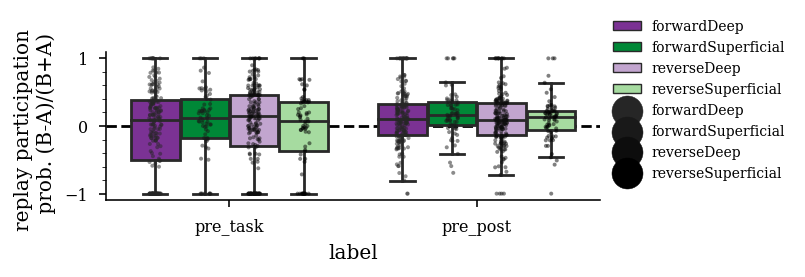

In [31]:
ratio_df = pd.DataFrame()

ratio_df['rip_participation'] = np.hstack([np.hstack(rip_par_ratio_pre_task_forward),
                                np.hstack(rip_par_ratio_pre_post_forward),
                                np.hstack(rip_par_ratio_pre_task_reverse),
                                np.hstack(rip_par_ratio_pre_post_reverse)])

ratio_df['participation'] = np.hstack([np.hstack(ratio_pre_task_forward), np.hstack(
    ratio_pre_post_forward), np.hstack(ratio_pre_task_reverse), np.hstack(ratio_pre_post_reverse)])
ratio_df['baseline'] = np.hstack([np.hstack(baseline_for), np.hstack(
    baseline_for), np.hstack(baseline_rev), np.hstack(baseline_rev)])

ratio_df['label'] = np.hstack([['pre_task']*len(ratio_pre_task_forward),
                               ['pre_post']*len(ratio_pre_post_forward),
                               ['pre_task']*len(ratio_pre_task_reverse),
                               ['pre_post']*len(ratio_pre_post_reverse)])

ratio_df['replay_type'] = np.hstack([['forward']*len(ratio_pre_task_forward),
                                     ['forward']*len(ratio_pre_post_forward),
                                     ['reverse']*len(ratio_pre_task_reverse),
                                     ['reverse']*len(ratio_pre_post_reverse)])
ratio_df['deepSuperficial'] = np.hstack([np.hstack(deepSuperficial), np.hstack(
    deepSuperficial), np.hstack(deepSuperficial), np.hstack(deepSuperficial)])

ratio_df['replay_layer'] = ratio_df['replay_type'] + \
    ratio_df['deepSuperficial']

plt.figure(figsize=functions.set_size(
    'thesis', fraction=.75, subplots=(1, 2)), edgecolor=None)

group_colors = {"forwardDeep": '#7b3294',
                'forwardSuperficial': '#008837',
                "reverseDeep": '#c2a5cf',
                'reverseSuperficial': '#a6dba0'}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()
sns.boxplot(x="label",
            y="participation",
            hue='replay_layer',
            hue_order=group_colors.keys(),
            saturation=1,
            showfliers=False,
            data=ratio_df,
            ax=ax)

sns.stripplot(x="label", y="participation", hue='replay_layer', hue_order=group_colors.keys(), dodge=True, data=ratio_df,
                size=2, color="k", linewidth=0, alpha=.5, ax=ax)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc='best', bbox_to_anchor=(.9, 0., 0.5, 1.3),
          fontsize='x-small', frameon=False, markerscale=2)

ax.set_ylabel('replay participation \n prob. (B-A)/(B+A)')
ax.axhline(0, color='k', zorder=-1000, linestyle="--")
# ax.set_yscale('log')
plt.savefig(os.path.join(fig_save_path,
            'replay_participation_deep_sup_ratio.svg'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_save_path,
            'replay_participation_deep_sup_ratio.pdf'), dpi=300, bbox_inches='tight')


### normalized by baseline ripple participation

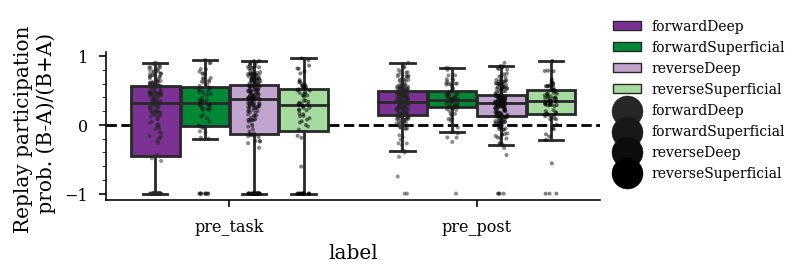

In [69]:
plt.figure(figsize=functions.set_size(
    'thesis', fraction=.75, subplots=(1, 2)), edgecolor=None)

group_colors = {"forwardDeep": '#7b3294',
                'forwardSuperficial': '#008837',
                "reverseDeep": '#c2a5cf',
                'reverseSuperficial': '#a6dba0'}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()
sns.boxplot(x="label",
            y="rip_participation",
            hue='replay_layer',
            hue_order=group_colors.keys(),
            saturation=1,
            showfliers=False,
            data=ratio_df,
            ax=ax)

sns.stripplot(x="label", y="rip_participation", hue='replay_layer', hue_order=group_colors.keys(), dodge=True, data=ratio_df,
                size=2, color="k", linewidth=0, alpha=.5, ax=ax)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc='best', bbox_to_anchor=(.9, 0., 0.5, 1.3),
          fontsize='x-small', frameon=False, markerscale=2)

ax.set_ylabel('Replay participation \n prob. (B-A)/(B+A)')
ax.axhline(0, color='k', zorder=-1000, linestyle="--")

plt.savefig(os.path.join(fig_save_path,
            'ripple_to_replay_participation_deep_sup_ratio.pdf'), dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='baseline', ylabel='participation'>

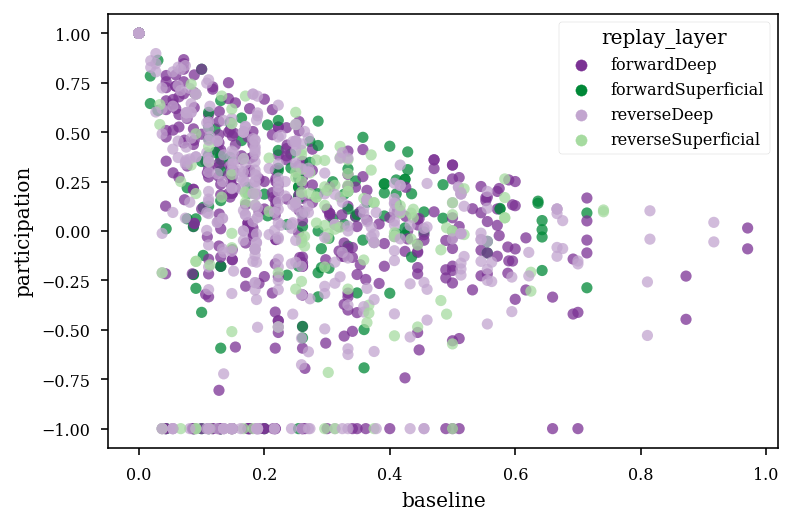

In [34]:
sns.scatterplot(x="baseline", y="participation",
                hue="replay_layer",
                hue_order=group_colors.keys(),
                linewidth=0,
                alpha=.75,
                data=ratio_df[~ratio_df.replay_layer.str.contains("middle")])


In [75]:
def get_ratio(x, y):
    return (y - x) / (y + x)


In [35]:
ratio_df = pd.DataFrame()

ratio_pre_task_forward = get_ratio(par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'forward')].participation.values,
                                   par_df[(par_df.epoch == 'task') & (par_df.replay_type == 'forward')].participation.values)

ratio_pre_post_forward = get_ratio(par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'forward')].participation.values,
                                   par_df[(par_df.epoch == 'post') & (par_df.replay_type == 'forward')].participation.values)

ratio_pre_task_reverse = get_ratio(par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'reverse')].participation.values,
                                   par_df[(par_df.epoch == 'task') & (par_df.replay_type == 'reverse')].participation.values)

ratio_pre_post_reverse = get_ratio(par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'reverse')].participation.values,
                                   par_df[(par_df.epoch == 'post') & (par_df.replay_type == 'reverse')].participation.values)

ratio_df['ratio'] = np.hstack(
    [ratio_pre_task_forward, ratio_pre_post_forward, ratio_pre_task_reverse, ratio_pre_post_reverse])

ratio_df['label'] = np.hstack([['pre_task']*len(ratio_pre_task_forward),
                               ['pre_post']*len(ratio_pre_post_forward),
                               ['pre_task']*len(ratio_pre_task_reverse),
                               ['pre_post']*len(ratio_pre_post_reverse)])

ratio_df['UID'] = np.hstack([par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'forward')].UID,
                            par_df[(par_df.epoch == 'pre') & (
                                par_df.replay_type == 'forward')].UID,
                            par_df[(par_df.epoch == 'pre') & (
                                par_df.replay_type == 'reverse')].UID,
                            par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'reverse')].UID])

ratio_df['replay_layer'] = np.hstack([par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'forward')].replay_layer,
                                      par_df[(par_df.epoch == 'pre') & (
                                          par_df.replay_type == 'forward')].replay_layer,
                                      par_df[(par_df.epoch == 'pre') & (
                                          par_df.replay_type == 'reverse')].replay_layer,
                                      par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'reverse')].replay_layer])

ratio_df['deepSuperficial'] = np.hstack([par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'forward')].deepSuperficial,
                                         par_df[(par_df.epoch == 'pre') & (
                                             par_df.replay_type == 'forward')].deepSuperficial,
                                         par_df[(par_df.epoch == 'pre') & (
                                             par_df.replay_type == 'reverse')].deepSuperficial,
                                         par_df[(par_df.epoch == 'pre') & (par_df.replay_type == 'reverse')].deepSuperficial])

ratio_df['replay_type'] = np.hstack([['forward']*(len(ratio_pre_task_forward)+len(ratio_pre_post_forward)),
                                    ['reverse']*(len(ratio_pre_task_forward)+len(ratio_pre_post_forward))])
ratio_df.head()


C:\Users\Cornell\AppData\Local\Temp/ipykernel_15708/4217621850.py:2: RuntimeWarning: invalid value encountered in true_divide


ratio     label  UID        replay_layer deepSuperficial replay_type
0  0.325301  pre_task    7         forwardDeep            Deep     forward
1  0.375000  pre_task   11         forwardDeep            Deep     forward
2  0.222222  pre_task   16  forwardSuperficial     Superficial     forward
3  0.511450  pre_task   23         forwardDeep            Deep     forward
4 -0.371429  pre_task   26         forwardDeep            Deep     forward

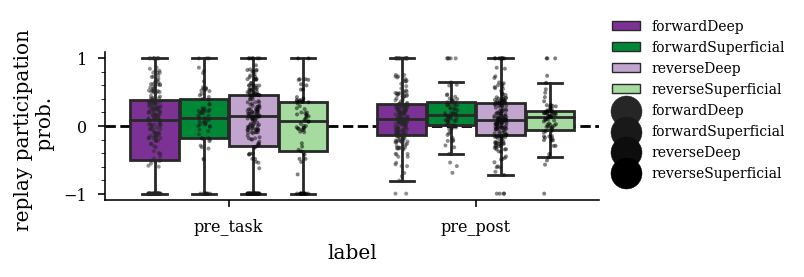

In [36]:
plt.figure(figsize=functions.set_size(
    'thesis', fraction=.75, subplots=(1, 2)), edgecolor=None)

group_colors = {"forwardDeep": '#7b3294',
                'forwardSuperficial': '#008837',
                "reverseDeep": '#c2a5cf',
                'reverseSuperficial': '#a6dba0'}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()
sns.boxplot(x="label",
            y="ratio",
            hue='replay_layer',
            hue_order=group_colors.keys(),
            saturation=1,
            showfliers=False,
            data=ratio_df,
            ax=ax)

sns.stripplot(x="label", y="ratio", hue='replay_layer', hue_order=group_colors.keys(), dodge=True, data=ratio_df,
              size=2, color="k", linewidth=0, alpha=.5, ax=ax)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(loc='best', bbox_to_anchor=(.9, 0., 0.5, 1.3),
          fontsize='x-small', frameon=False, markerscale=2)

ax.set_ylabel('replay participation \n prob.')
ax.axhline(0,color='k',linestyle="--",zorder=-1000)

(-1.1, 1.1, -1.1, 1.1)

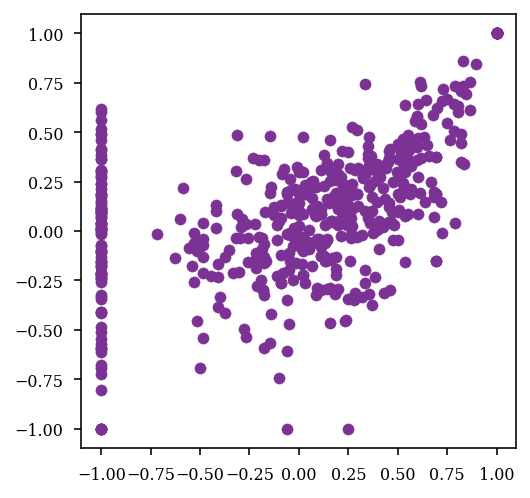

In [37]:
plt.scatter(ratio_df[ratio_df.label == 'pre_task'].ratio,
            ratio_df[ratio_df.label == 'pre_post'].ratio)
plt.axis('square')


Text(111.65, 0.5, 'reverse replay')

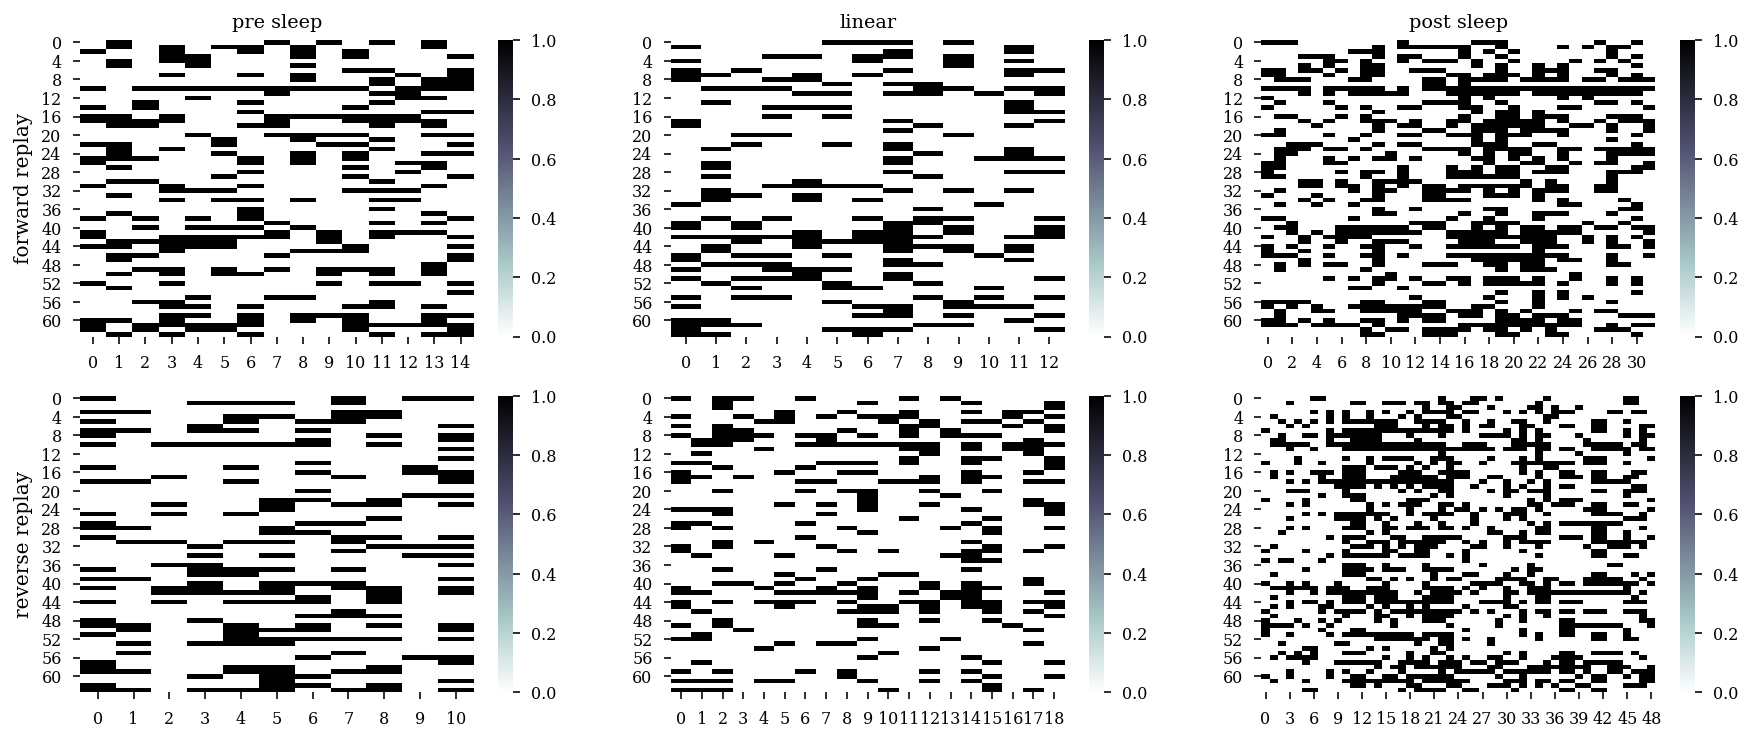

In [267]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

unit_mat = functions.get_participation(st.data,
                                       behavior_epochs[0][nrem_epochs][forward_replay].starts,
                                       behavior_epochs[0][nrem_epochs][forward_replay].stops,
                                       par_type='binary')
sns.heatmap(unit_mat, ax=ax[0, 0], cmap='bone_r')

unit_mat = functions.get_participation(st.data,
                                       behavior_epochs[1][wake_epochs][forward_replay].starts,
                                       behavior_epochs[1][wake_epochs][forward_replay].stops,
                                       par_type='binary')
sns.heatmap(unit_mat, ax=ax[0, 1], cmap='bone_r')

unit_mat = functions.get_participation(st.data,
                                       behavior_epochs[2][nrem_epochs][forward_replay].starts,
                                       behavior_epochs[2][nrem_epochs][forward_replay].stops,
                                       par_type='binary')
sns.heatmap(unit_mat, ax=ax[0, 2], cmap='bone_r')


unit_mat = functions.get_participation(st.data,
                                       behavior_epochs[0][nrem_epochs][reverse_replay].starts,
                                       behavior_epochs[0][nrem_epochs][reverse_replay].stops,
                                       par_type='binary')
sns.heatmap(unit_mat, ax=ax[1, 0], cmap='bone_r')

unit_mat = functions.get_participation(st.data,
                                       behavior_epochs[1][wake_epochs][reverse_replay].starts,
                                       behavior_epochs[1][wake_epochs][reverse_replay].stops,
                                       par_type='binary')
sns.heatmap(unit_mat, ax=ax[1, 1], cmap='bone_r')

unit_mat = functions.get_participation(st.data,
                                       behavior_epochs[2][nrem_epochs][reverse_replay].starts,
                                       behavior_epochs[2][nrem_epochs][reverse_replay].stops,
                                       par_type='binary')
sns.heatmap(unit_mat, ax=ax[1, 2], cmap='bone_r')

ax[0, 0].set_title('pre sleep')
ax[0, 1].set_title('linear')
ax[0, 2].set_title('post sleep')

ax[0, 0].set_ylabel('forward replay')
ax[1, 0].set_ylabel('reverse replay')


In [216]:
starts = ripple_epochs[behavioral_epochs[0]].starts
stops = ripple_epochs[behavioral_epochs[0]].stops
particip_mat = functions.get_participation(st.data, starts, stops)
pop_partic = particip_mat.mean(axis=0)
unit_partic = particip_mat.mean(axis=1)

sig_replay_epochs = nel.EpochArray([np.array([results['df'].start[results['df'].score_pval_col_cycle < 0.01],
                                              results['df'].stop[results['df'].score_pval_col_cycle < 0.01]]).T])

non_sig_replay_epochs = nel.EpochArray([np.array([results['df'].start[results['df'].score_pval_col_cycle > 0.01],
                                                  results['df'].stop[results['df'].score_pval_col_cycle > 0.01]]).T])


## Correlated replay strength with the recruitment of sup cells

In [87]:
import warnings

warnings.filterwarnings("ignore")


def remove_bad_waveforms(uid, cell_metrics, st):
    # remove uids with bad waveforms as we can not estimate deep/sup
    if "tags_bad_waveform" in cell_metrics.columns:
        a = set(cell_metrics[cell_metrics.tags_bad_waveform].UID.values)
        b = set(uid)
        c = b.difference(a)
        uid = np.sort(np.array(list(c)))

    _, x_ind, _ = np.intersect1d(cell_metrics.UID, uid, return_indices=True)
    unit_ids_to_keep = (x_ind + 1).squeeze().tolist()
    st_keep = st._unit_subset(unit_ids_to_keep)

    cell_metrics = cell_metrics.iloc[x_ind]
    return st_keep, cell_metrics


def get_par_df(template_label, results, st_keep, cell_metrics):

    # replay_idx = results[template_label]['df'].score_pval_col_cycle < 0.05
    replay_idx = results[template_label]["df"].score_pval_time_swap < 0.05

    if not any(replay_idx):
        return None
    temp_df = results[template_label]["df"][replay_idx]
    replay_epoch = nel.EpochArray([np.array([temp_df.start, temp_df.stop]).T])

    trajectory_score = nel.AnalogSignalArray(
        data=results[template_label]["df"][replay_idx].trajectory_score.values,
        timestamps=replay_epoch.centers,
    )

    par = functions.get_participation(
        st_keep.data, replay_epoch.starts, replay_epoch.stops
    )
    replay_participation = nel.AnalogSignalArray(
        data=par, timestamps=replay_epoch.centers
    )

    pop_par = []
    deepSuperficial = []
    epoch = []
    n_cells = []
    total_cells = []
    traj_score = []
    epoch_n = []
    active_cells = []
    active_cells_total = []
    for i, beh_ep in enumerate(behavior_epochs):
        pop_par.append(
            replay_participation[beh_ep]
            .data[cell_metrics.deepSuperficial == "Deep", :]
            .mean(axis=0)
        )
        pop_par.append(
            replay_participation[beh_ep]
            .data[cell_metrics.deepSuperficial == "Superficial", :]
            .mean(axis=0)
        )

        active_cells.append(
            replay_participation[beh_ep]
            .data[cell_metrics.deepSuperficial == "Deep", :]
            .sum(axis=0)
        )
        active_cells.append(
            replay_participation[beh_ep]
            .data[cell_metrics.deepSuperficial == "Superficial", :]
            .sum(axis=0)
        )

        active_cells_total.append(replay_participation[beh_ep].data.sum(axis=0))
        active_cells_total.append(replay_participation[beh_ep].data.sum(axis=0))

        total_cells.append(np.tile(cell_metrics.shape[0], len(pop_par[-1])))
        total_cells.append(np.tile(cell_metrics.shape[0], len(pop_par[-1])))

        n_cells.append(
            np.tile(sum(cell_metrics.deepSuperficial == "Deep"), len(pop_par[-1]))
        )
        n_cells.append(
            np.tile(
                sum(cell_metrics.deepSuperficial == "Superficial"), len(pop_par[-1])
            )
        )

        deepSuperficial.append(["Deep"] * len(pop_par[-1]))
        deepSuperficial.append(["Superficial"] * len(pop_par[-1]))

        epoch_n.append([i] * len(pop_par[-1]))
        epoch_n.append([i] * len(pop_par[-1]))

        epoch.append([epoch_df.iloc[i].environment] * len(pop_par[-1]))
        epoch.append([epoch_df.iloc[i].environment] * len(pop_par[-1]))

        traj_score.append(trajectory_score[beh_ep].data.T)
        traj_score.append(trajectory_score[beh_ep].data.T)

    df_par = pd.DataFrame()
    df_par["pop_par"] = np.hstack(pop_par)
    df_par["traj_score"] = np.vstack(traj_score)

    df_par["deepSuperficial"] = np.hstack(deepSuperficial)
    df_par["epoch"] = np.hstack(epoch)
    df_par["epoch_n"] = np.hstack(epoch_n)

    df_par["active_cells"] = np.hstack(active_cells)
    df_par["active_cells_total"] = np.hstack(active_cells_total)

    df_par["n_cells"] = np.hstack(n_cells)
    df_par["total_cells"] = np.hstack(total_cells)

    df_par["basepath"] = results[template_label]["session"]
    df_par["template"] = template_label

    return df_par


save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay"
sessions = glob.glob(save_path + os.sep + "*.pkl")

par_df = pd.DataFrame()

for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)

    basepath = results["outbound_epochs"]["session"]

    epoch_df = loading.load_epoch(basepath)
    pattern_idx, _ = functions.find_epoch_pattern(
        epoch_df.environment, ["sleep", "linear", "sleep"]
    )
    epoch_df = epoch_df[pattern_idx]
    behavior_epochs = nel.EpochArray(
        [np.array([epoch_df.startTime, epoch_df.stopTime]).T]
    )

    # locate active units that were used in anlysis
    # because out/inbound templates were used seperately, we need to include both
    # always load cell metrics from source to get most up to date data
    st, cell_metrics = loading.load_spikes(
        basepath, brainRegion="CA1", putativeCellType="Pyramidal"
    )

    uid = pd.unique(
        np.hstack(
            [
                results["outbound_epochs"]["cell_metrics"].UID,
                results["inbound_epochs"]["cell_metrics"].UID,
            ]
        )
    )

    st_keep, cell_metrics = remove_bad_waveforms(uid, cell_metrics, st)

    deep = -30
    middle = [-30, 30]
    sup = 30
    cell_metrics.loc[
        cell_metrics.deepSuperficialDistance <= deep, "deepSuperficial"
    ] = "Deep"
    
    cell_metrics.loc[
        (cell_metrics.deepSuperficialDistance > middle[0])
        & (cell_metrics.deepSuperficialDistance < middle[1]),
        "deepSuperficial",
    ] = "middle"

    cell_metrics.loc[
        cell_metrics.deepSuperficialDistance >= sup, "deepSuperficial"
    ] = "Superficial"

    # outbound
    par_df = pd.concat(
        [par_df, get_par_df("outbound_epochs", results, st_keep, cell_metrics)]
    )
    # inbound
    par_df = pd.concat(
        [par_df, get_par_df("inbound_epochs", results, st_keep, cell_metrics)]
    )

par_df["frac_cells"] = par_df.n_cells / par_df.total_cells
par_df["frac_active_cells"] = par_df.active_cells / par_df.active_cells_total

# par_df['frac_active_cells_by_total'] = par_df.active_cells / par_df.n_cells # same as pop_par


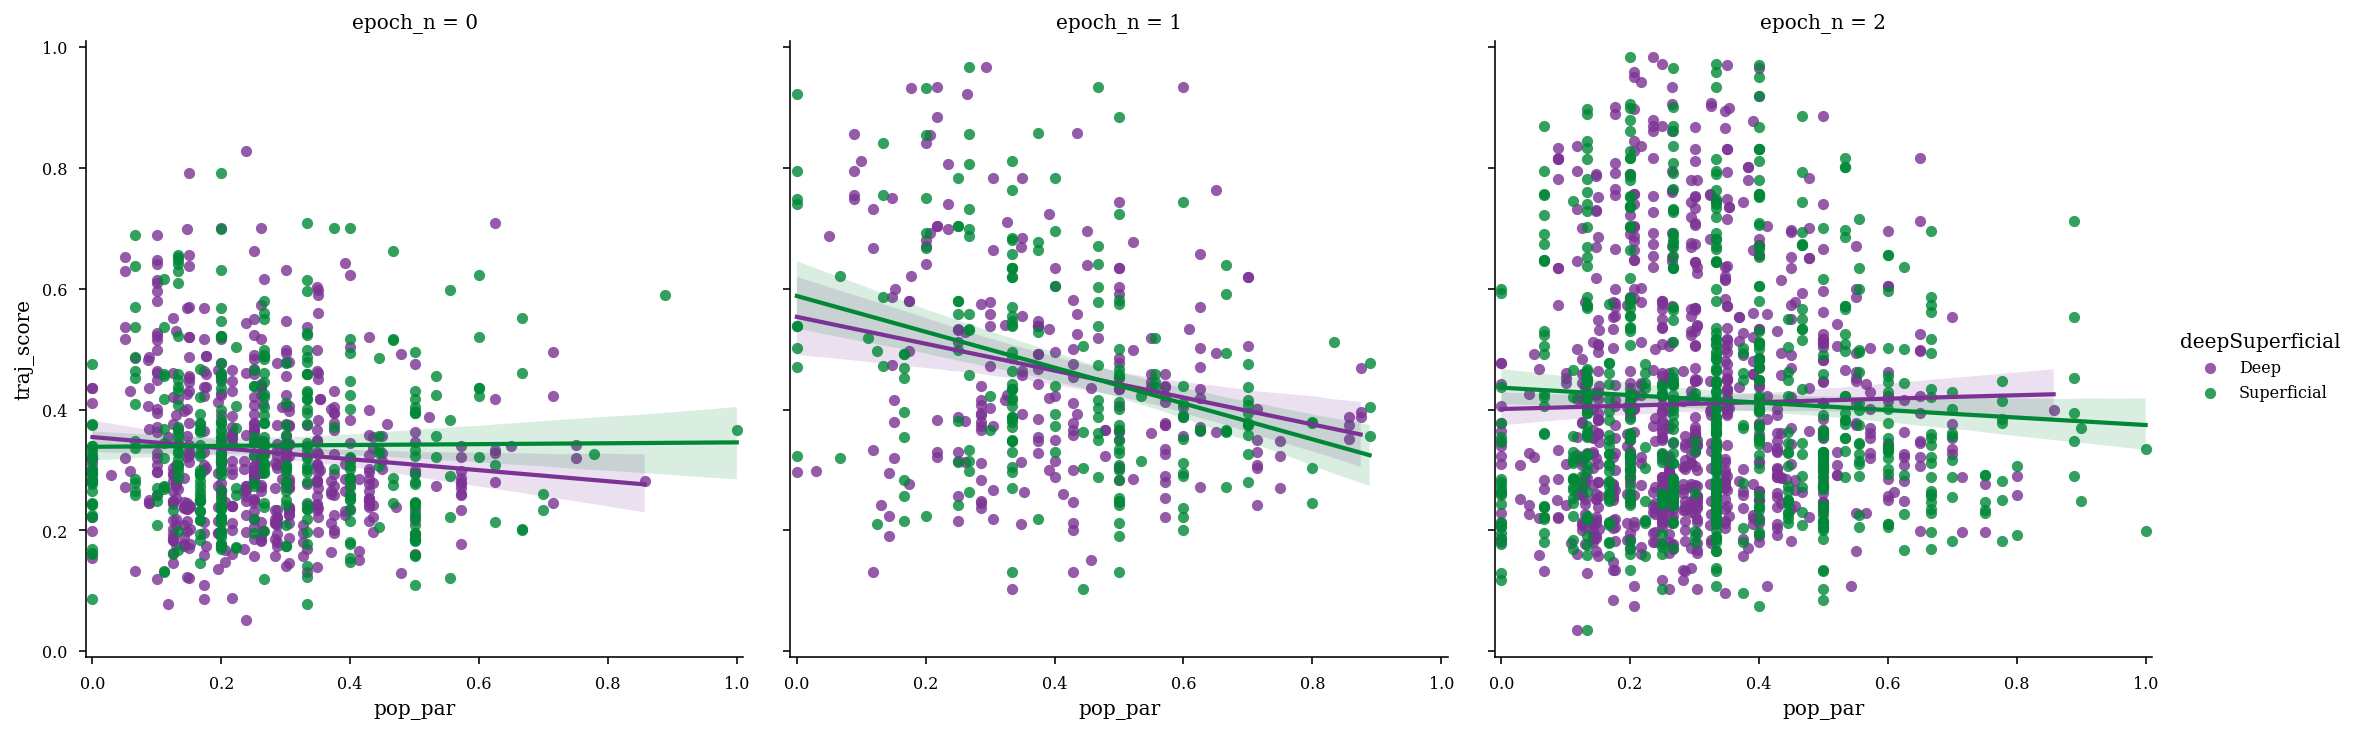

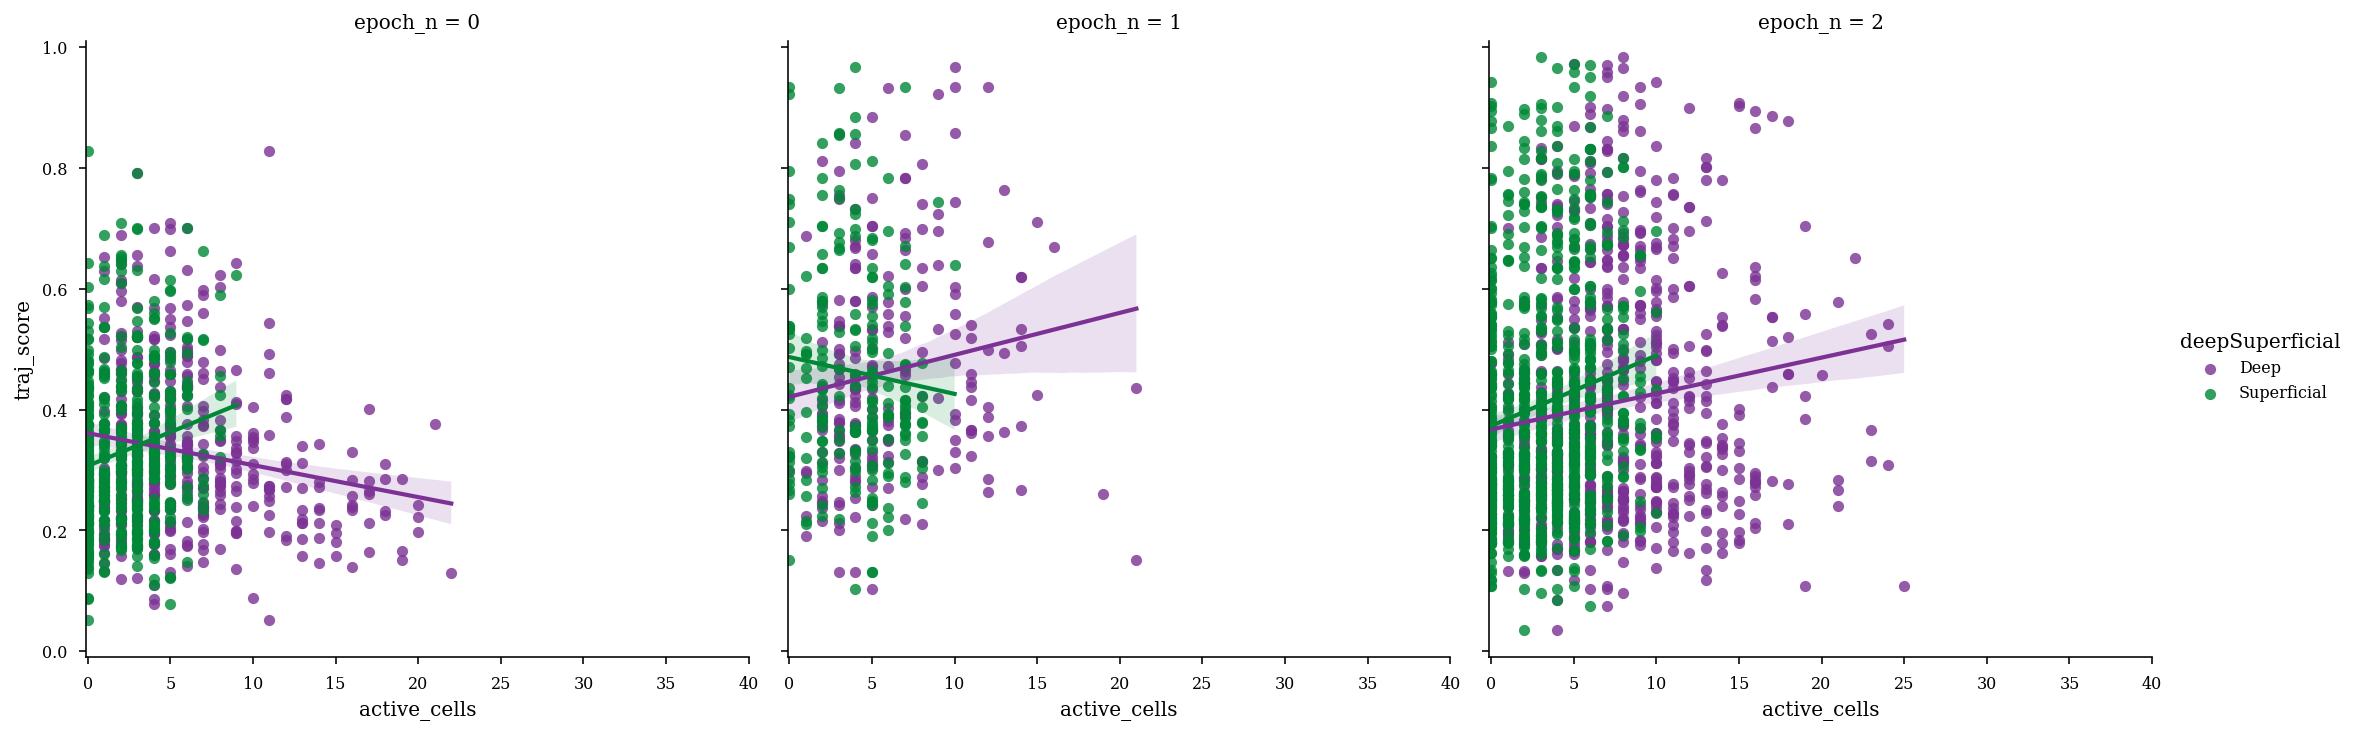

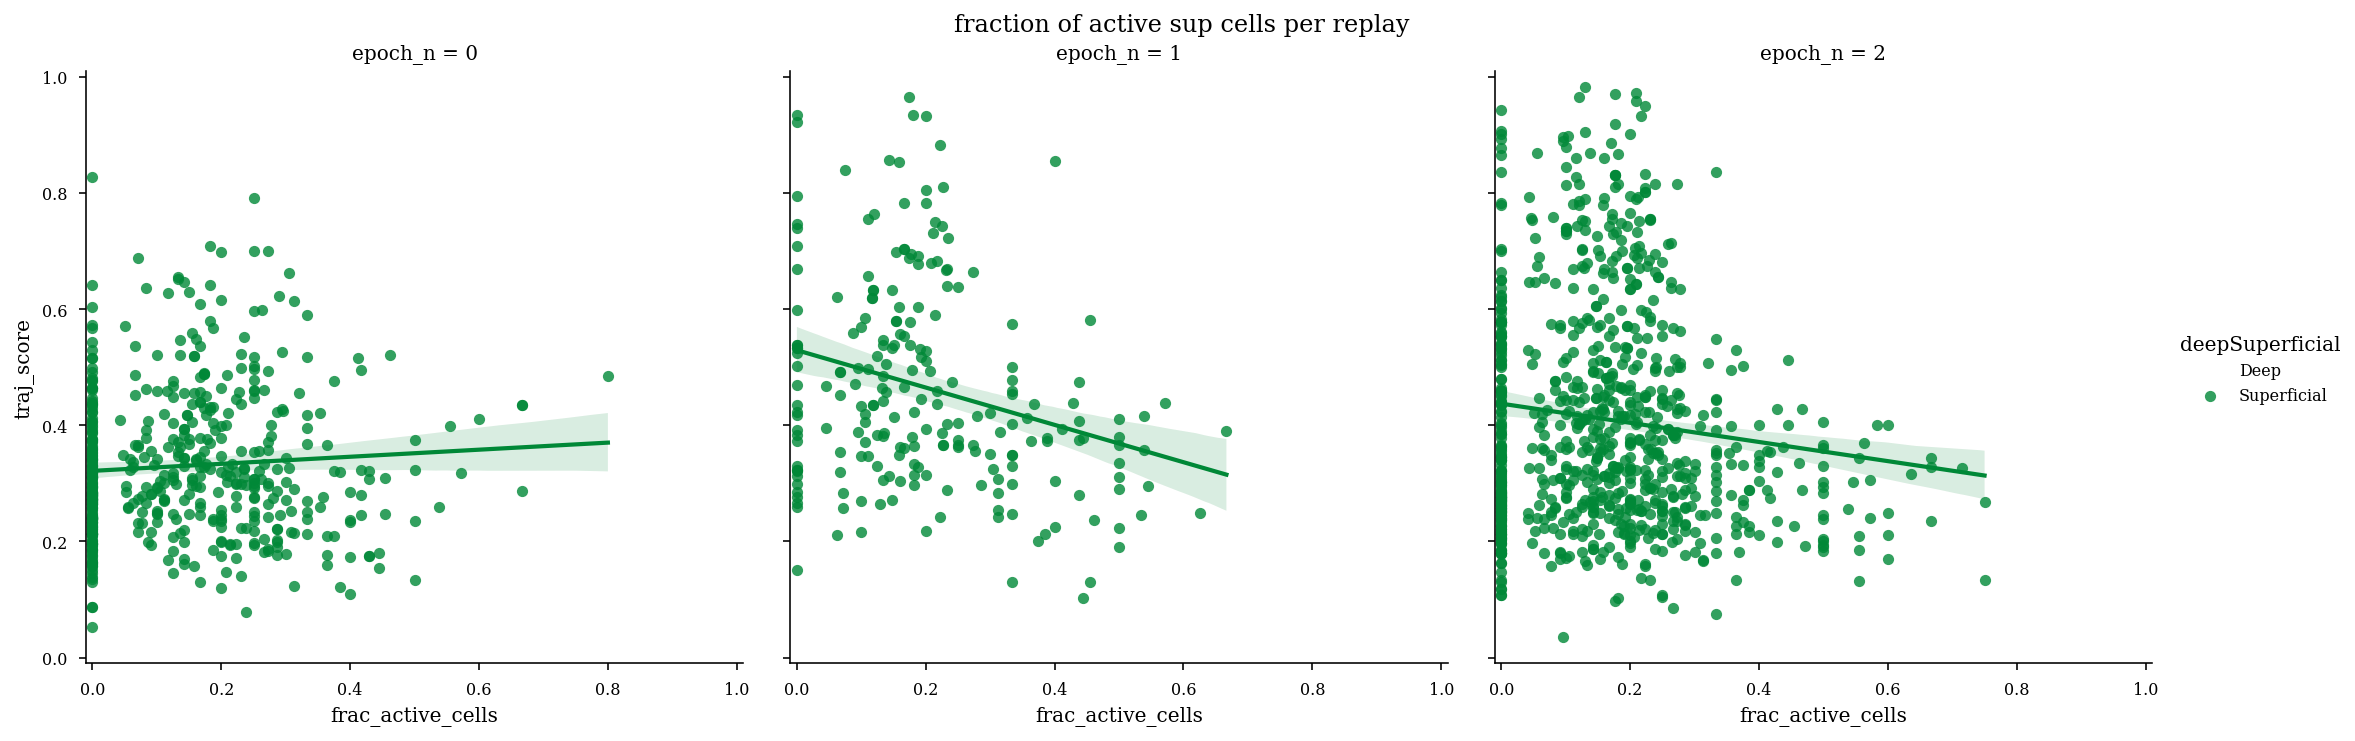

In [88]:
group_colors = {"Deep": '#7b3294',
                'Superficial': '#008837'}
sns.set_palette(sns.color_palette(group_colors.values()))

g = sns.lmplot(
    data=par_df,
    x="pop_par", y="traj_score", hue="deepSuperficial", hue_order=group_colors.keys(), col='epoch_n',
    height=5
)
g.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))

g = sns.lmplot(
    data=par_df,
    x="active_cells", y="traj_score", hue="deepSuperficial", hue_order=group_colors.keys(), col='epoch_n',
    height=5
)
g.set(xlim=(-0.1, 40), ylim=(-0.01, 1.01))

g = sns.lmplot(
    data=par_df[par_df.deepSuperficial == 'Superficial'],
    x="frac_active_cells", y="traj_score", col='epoch_n', hue="deepSuperficial", hue_order=group_colors.keys(),
    height=5
)
g.fig.suptitle('fraction of active sup cells per replay', fontsize=12)
g.fig.subplots_adjust(top=.9)
# plt.title('fraction of active sup cells per replay')
g.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))


### Reproduce above analysis with only cells that were included in replay analysis

In [91]:
import warnings

warnings.filterwarnings("ignore")


def remove_bad_waveforms(uid, cell_metrics, st):
    # remove uids with bad waveforms as we can not estimate deep/sup
    if "tags_bad_waveform" in cell_metrics.columns:
        a = set(cell_metrics[cell_metrics.tags_bad_waveform].UID.values)
        b = set(uid)
        c = b.difference(a)
        uid = np.sort(np.array(list(c)))

    _, x_ind, _ = np.intersect1d(cell_metrics.UID, uid, return_indices=True)
    unit_ids_to_keep = (x_ind + 1).squeeze().tolist()
    st_keep = st._unit_subset(unit_ids_to_keep)

    cell_metrics = cell_metrics.iloc[x_ind]
    return st_keep, cell_metrics


def get_par_df(template_label, results):

    # replay_idx = results[template_label]['df'].score_pval_col_cycle < 0.05
    replay_idx = results[template_label]["df"].score_pval_time_swap < 0.05

    if not any(replay_idx):
        return None
    temp_df = results[template_label]["df"][replay_idx]
    replay_epoch = nel.EpochArray([np.array([temp_df.start, temp_df.stop]).T])

    trajectory_score = nel.AnalogSignalArray(
        data=results[template_label]["df"][replay_idx].trajectory_score.values,
        timestamps=replay_epoch.centers,
    )
    r_squared = nel.AnalogSignalArray(
        data=results[template_label]["df"][replay_idx].r_squared.values,
        timestamps=replay_epoch.centers,
    )

    par = functions.get_participation(
        results[template_label]["sta_placecells"].data,
        replay_epoch.starts,
        replay_epoch.stops,
    )
    replay_participation = nel.AnalogSignalArray(
        data=par, timestamps=replay_epoch.centers
    )

    cell_metrics = results[template_label]["cell_metrics"]

    cell_metrics_, _ = loading.load_cell_metrics(results[template_label]["session"])
    idx = np.in1d(cell_metrics_.UID, cell_metrics.UID)
    if all(cell_metrics_[idx].deepSuperficial == cell_metrics.deepSuperficial):
        cell_metrics.deepSuperficial = cell_metrics_[idx].deepSuperficialDistance

        deep = -30
        middle = [-30, 30]
        sup = 30
        cell_metrics.loc[
            cell_metrics.deepSuperficialDistance <= deep, "deepSuperficial"
        ] = "Deep"
        cell_metrics.loc[
            (cell_metrics.deepSuperficialDistance > middle[0])
            & (cell_metrics.deepSuperficialDistance < middle[1]),
            "deepSuperficial",
        ] = "middle"
        cell_metrics.loc[
            cell_metrics.deepSuperficialDistance >= sup, "deepSuperficial"
        ] = "Superficial"
    else:
        print("what happened?")

    pop_par = []
    deepSuperficial = []
    epoch = []
    n_cells = []
    total_cells = []
    traj_score = []
    r2 = []
    epoch_n = []
    active_cells = []
    active_cells_total = []
    for i, beh_ep in enumerate(behavior_epochs):
        pop_par.append(
            replay_participation[beh_ep]
            .data[cell_metrics.deepSuperficial == "Deep", :]
            .mean(axis=0)
        )
        pop_par.append(
            replay_participation[beh_ep]
            .data[cell_metrics.deepSuperficial == "Superficial", :]
            .mean(axis=0)
        )

        active_cells.append(
            replay_participation[beh_ep]
            .data[cell_metrics.deepSuperficial == "Deep", :]
            .sum(axis=0)
        )
        active_cells.append(
            replay_participation[beh_ep]
            .data[cell_metrics.deepSuperficial == "Superficial", :]
            .sum(axis=0)
        )

        active_cells_total.append(replay_participation[beh_ep].data.sum(axis=0))
        active_cells_total.append(replay_participation[beh_ep].data.sum(axis=0))

        total_cells.append(np.tile(cell_metrics.shape[0], len(pop_par[-1])))
        total_cells.append(np.tile(cell_metrics.shape[0], len(pop_par[-1])))

        n_cells.append(
            np.tile(sum(cell_metrics.deepSuperficial == "Deep"), len(pop_par[-1]))
        )
        n_cells.append(
            np.tile(
                sum(cell_metrics.deepSuperficial == "Superficial"), len(pop_par[-1])
            )
        )

        deepSuperficial.append(["Deep"] * len(pop_par[-1]))
        deepSuperficial.append(["Superficial"] * len(pop_par[-1]))

        epoch_n.append([i] * len(pop_par[-1]))
        epoch_n.append([i] * len(pop_par[-1]))

        epoch.append([epoch_df.iloc[i].environment] * len(pop_par[-1]))
        epoch.append([epoch_df.iloc[i].environment] * len(pop_par[-1]))

        traj_score.append(trajectory_score[beh_ep].data.T)
        traj_score.append(trajectory_score[beh_ep].data.T)

        r2.append(r_squared[beh_ep].data.T)
        r2.append(r_squared[beh_ep].data.T)

    df_par = pd.DataFrame()
    df_par["pop_par"] = np.hstack(pop_par)
    df_par["traj_score"] = np.vstack(traj_score)
    df_par["r_squared"] = np.vstack(r2)

    df_par["deepSuperficial"] = np.hstack(deepSuperficial)
    df_par["epoch"] = np.hstack(epoch)
    df_par["epoch_n"] = np.hstack(epoch_n)

    df_par["active_cells"] = np.hstack(active_cells)
    df_par["active_cells_total"] = np.hstack(active_cells_total)

    df_par["n_cells"] = np.hstack(n_cells)
    df_par["total_cells"] = np.hstack(total_cells)

    df_par["basepath"] = results[template_label]["session"]
    df_par["template"] = template_label

    return df_par


save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay"
sessions = glob.glob(save_path + os.sep + "*.pkl")

par_df = pd.DataFrame()

for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)

    basepath = results["outbound_epochs"]["session"]

    epoch_df = loading.load_epoch(basepath)
    pattern_idx, _ = functions.find_epoch_pattern(
        epoch_df.environment, ["sleep", "linear", "sleep"]
    )
    epoch_df = epoch_df[pattern_idx]
    behavior_epochs = nel.EpochArray(
        [np.array([epoch_df.startTime, epoch_df.stopTime]).T]
    )

    # outbound
    par_df = pd.concat([par_df, get_par_df("outbound_epochs", results)])
    # inbound
    par_df = pd.concat([par_df, get_par_df("inbound_epochs", results)])

par_df["frac_cells"] = par_df.n_cells / par_df.total_cells
par_df["frac_active_cells"] = par_df.active_cells / par_df.active_cells_total

# par_df['frac_active_cells_by_total'] = par_df.active_cells / par_df.n_cells # same as pop_par


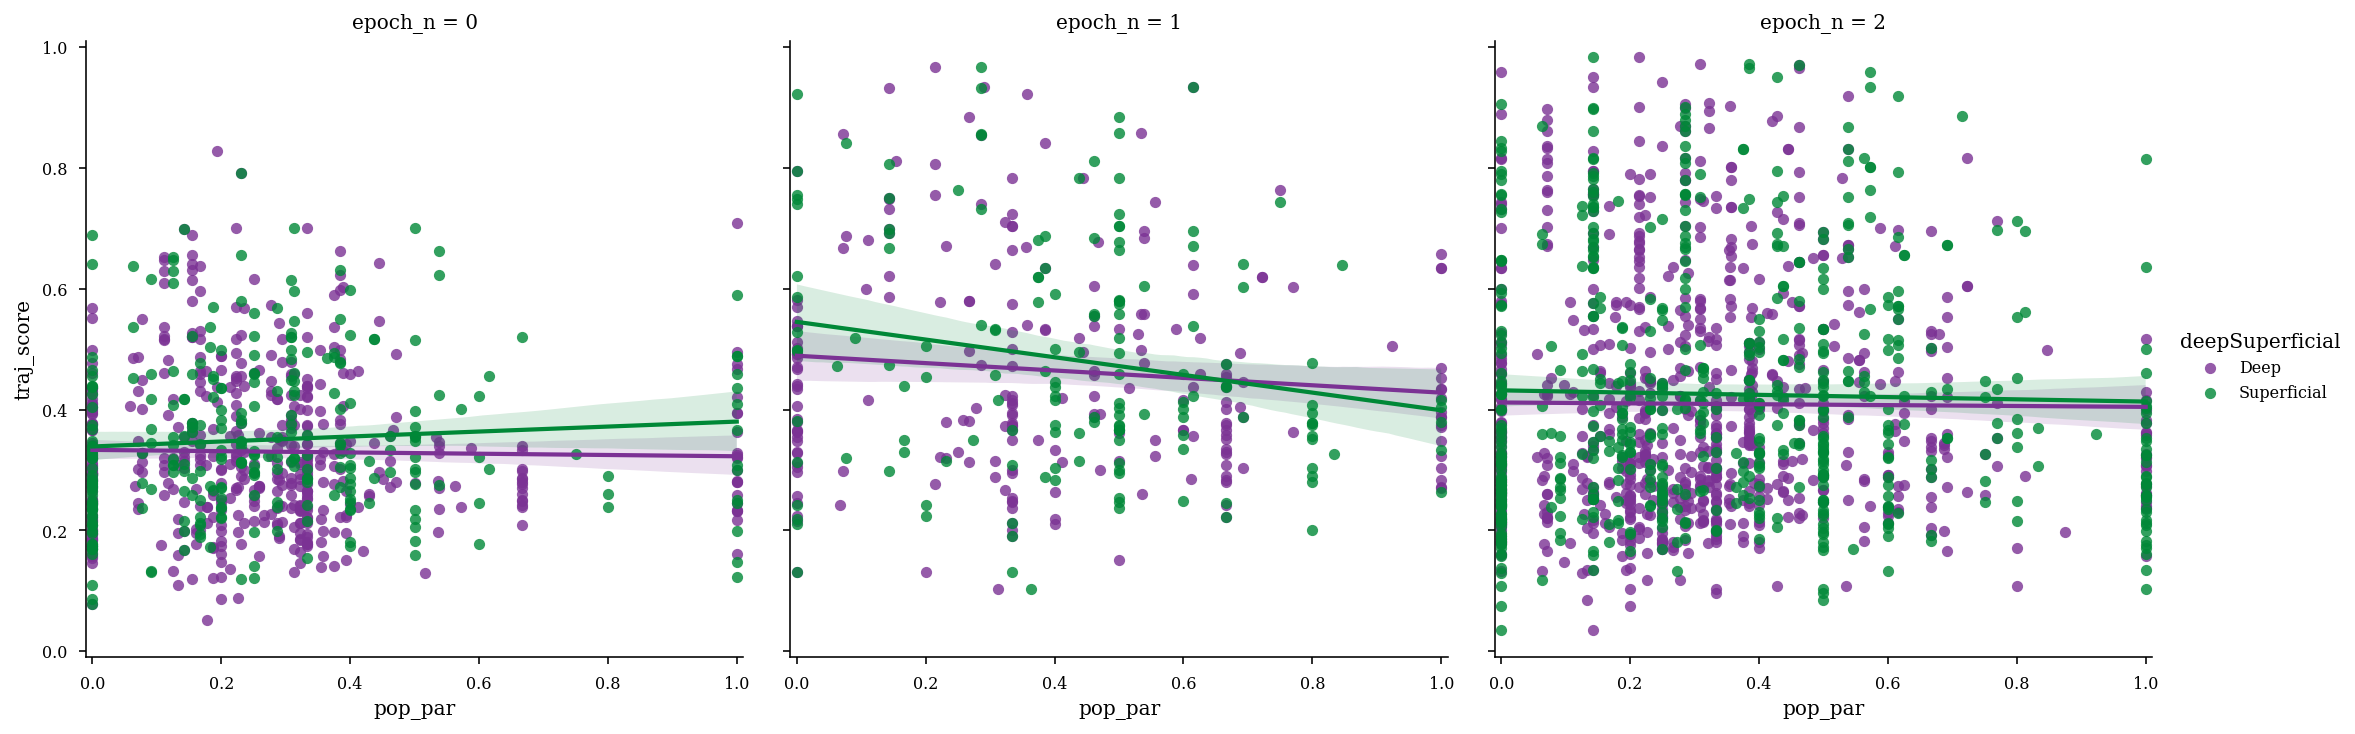

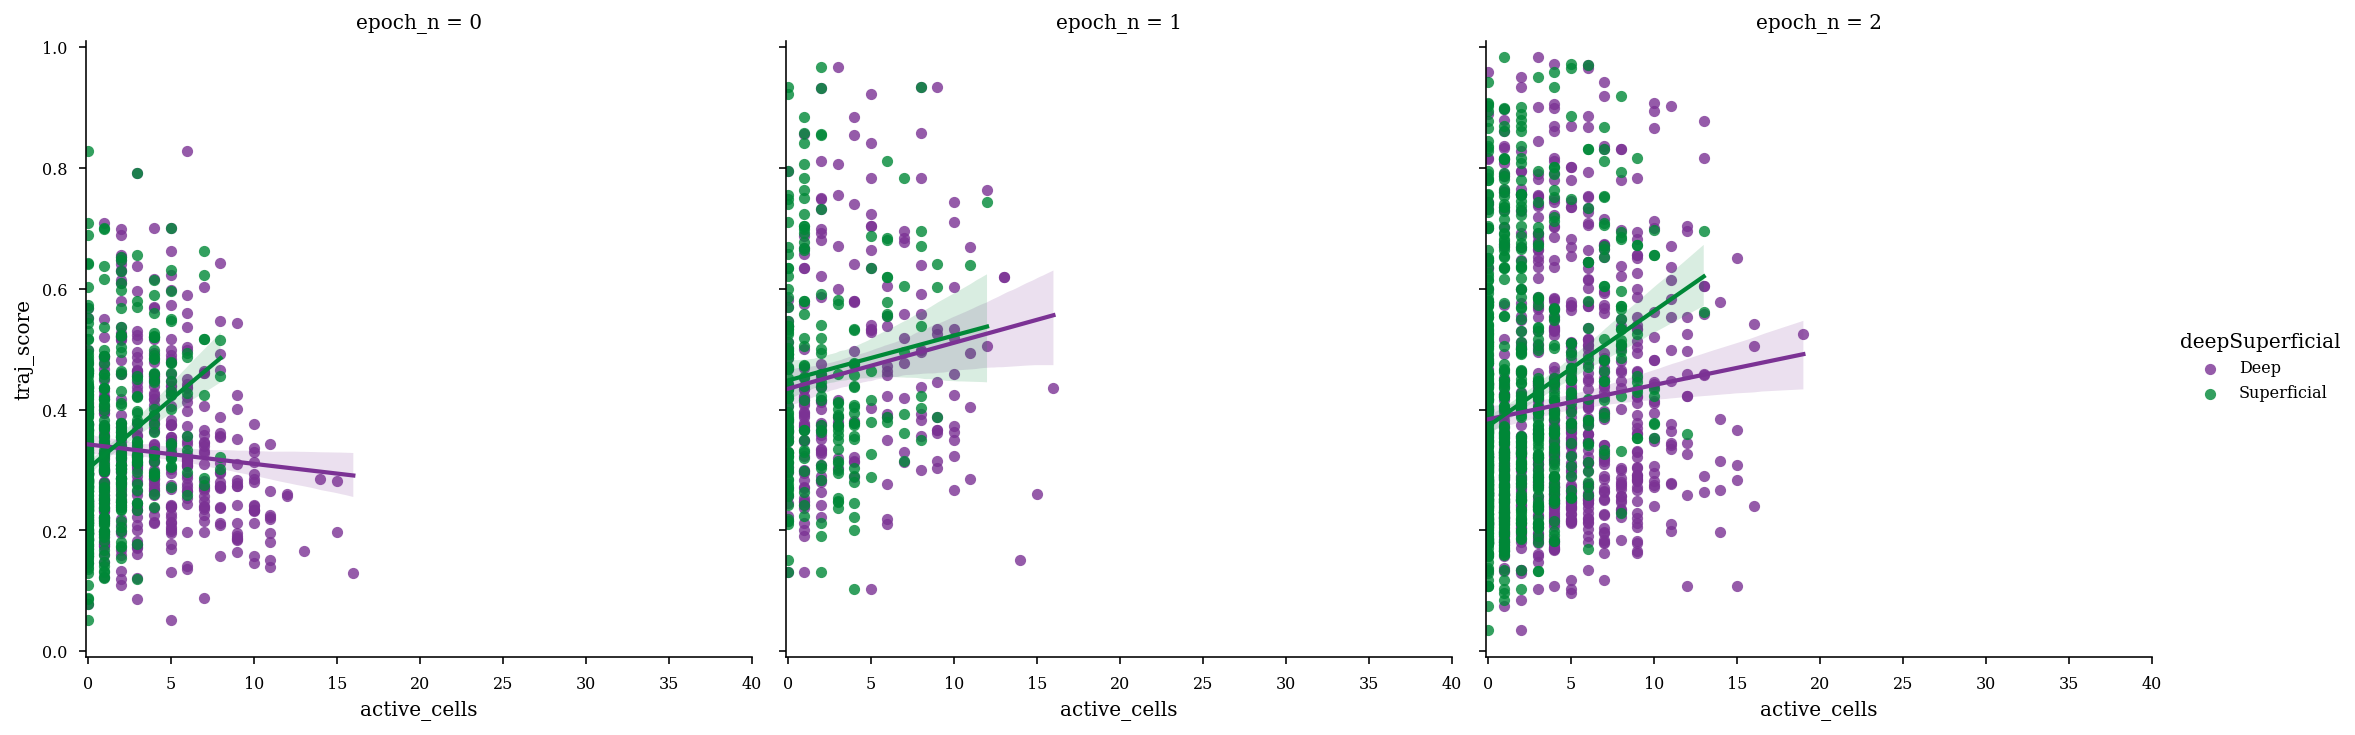

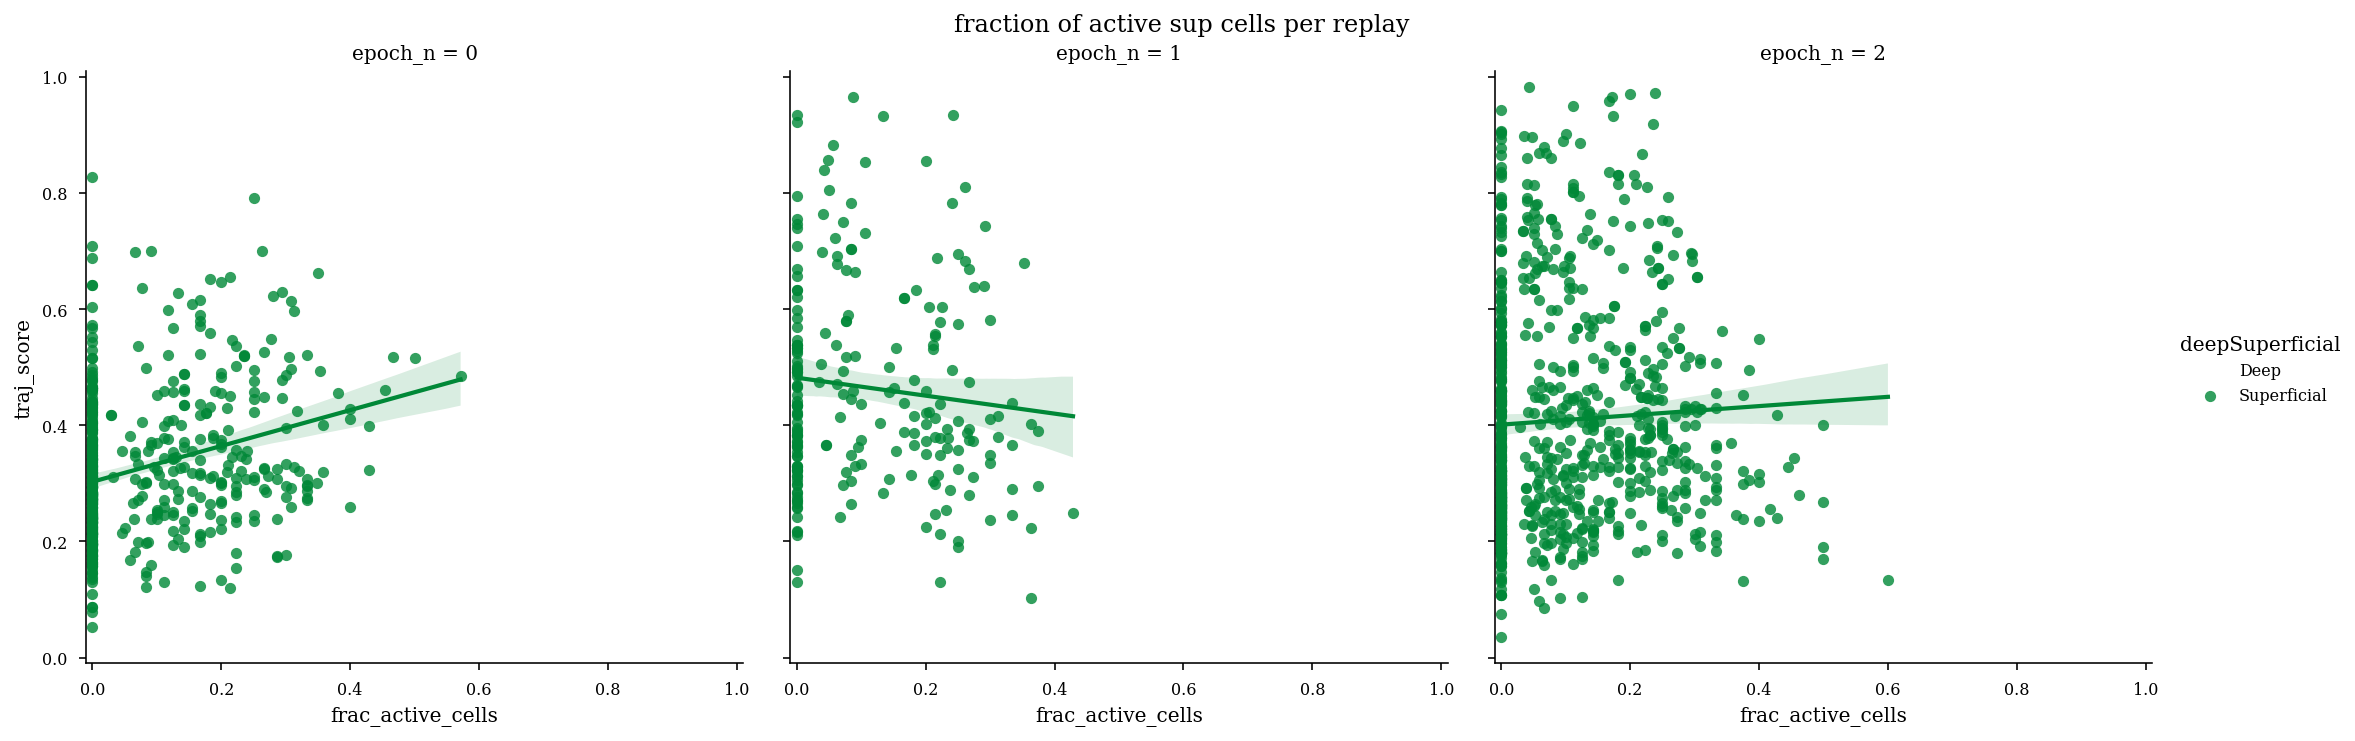

In [92]:
group_colors = {"Deep": '#7b3294',
                'Superficial': '#008837'}
sns.set_palette(sns.color_palette(group_colors.values()))

g = sns.lmplot(
    data=par_df,
    x="pop_par", y="traj_score", hue="deepSuperficial", hue_order=group_colors.keys(), col='epoch_n',
    height=5
)
g.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))

g = sns.lmplot(
    data=par_df,
    x="active_cells", y="traj_score", hue="deepSuperficial", hue_order=group_colors.keys(), col='epoch_n',
    height=5
)
g.set(xlim=(-0.1, 40), ylim=(-0.01, 1.01))

g = sns.lmplot(
    data=par_df[par_df.deepSuperficial == 'Superficial'],
    x="frac_active_cells", y="traj_score", col='epoch_n', hue="deepSuperficial", hue_order=group_colors.keys(),
    height=5
)
g.fig.suptitle('fraction of active sup cells per replay', fontsize=12)
g.fig.subplots_adjust(top=.9)
# plt.title('fraction of active sup cells per replay')
g.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))


## psth

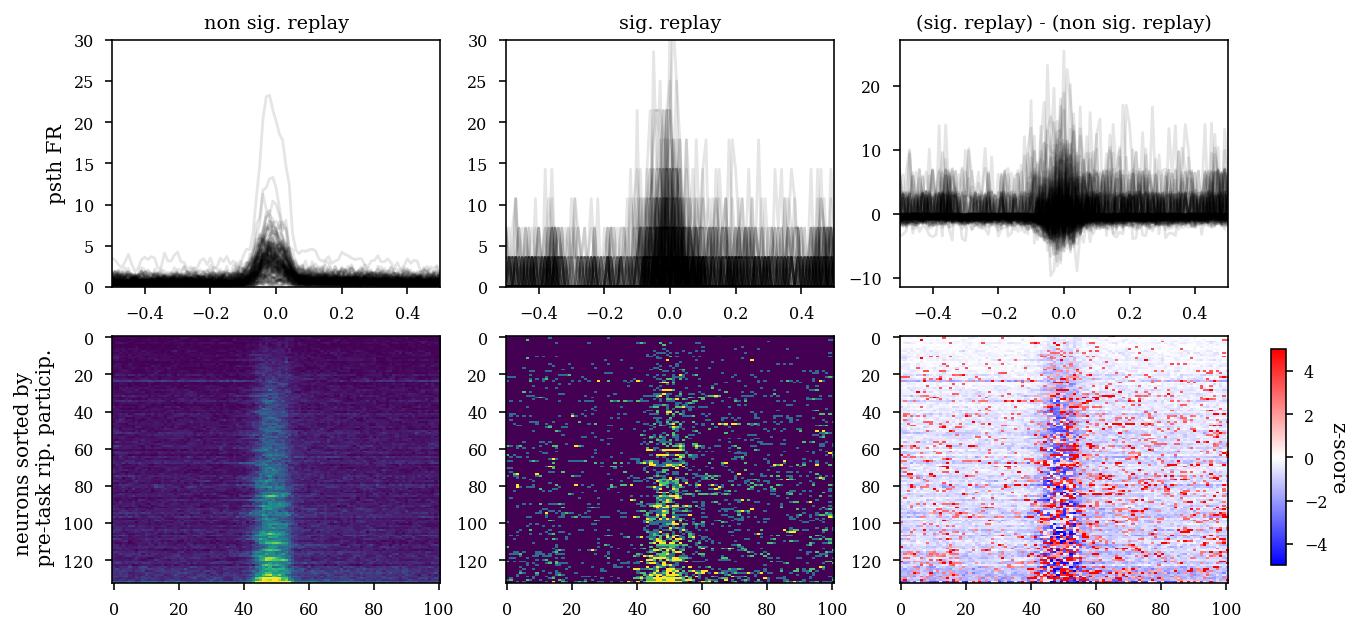

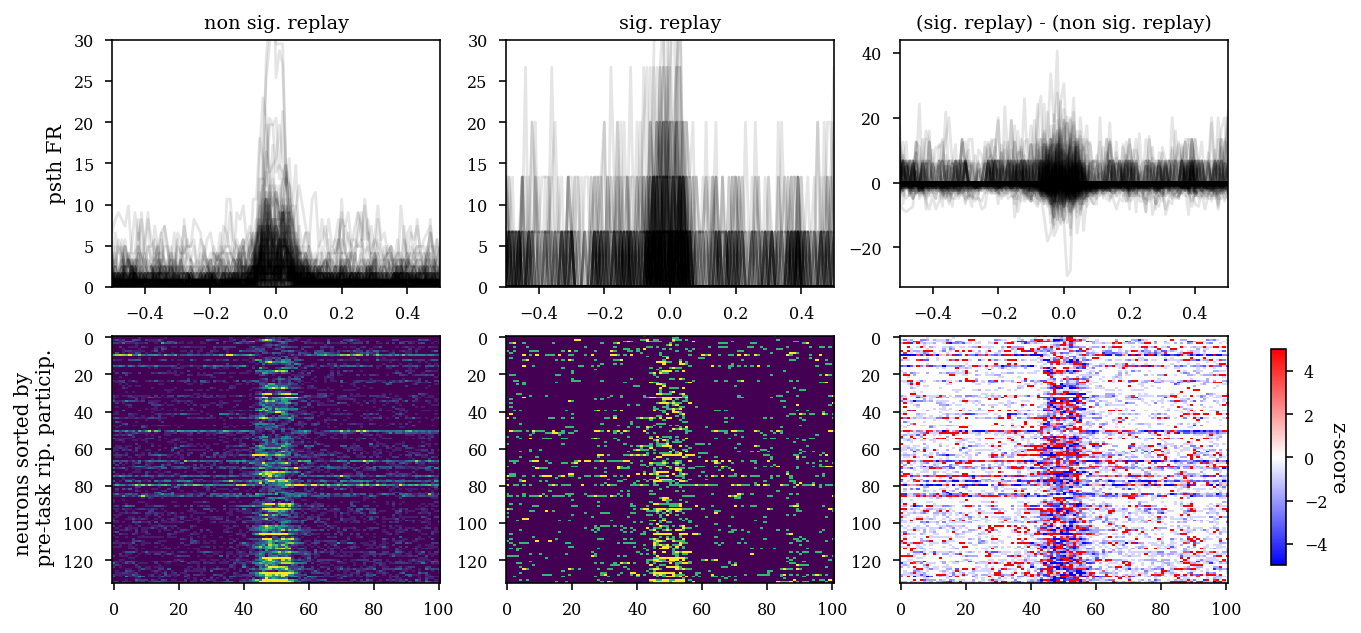

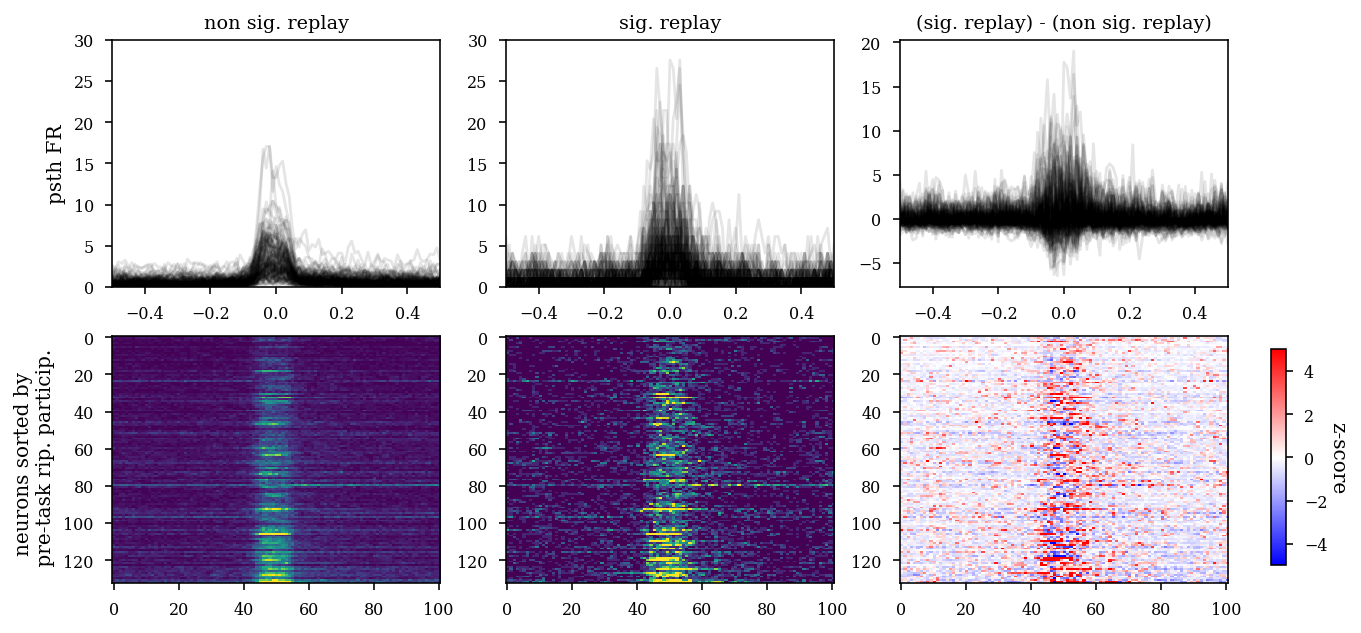

In [277]:
def plot_custom_psth(st, behavioral_epochs, unit_partic, epoch=2):
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))

    psth_non_sig = functions.compute_psth(
        st[behavioral_epochs[epoch]].data, non_sig_replay_epochs[behavioral_epochs[epoch]].centers, bin_width=0.01, n_bins=100)
    axs[0, 0].plot(psth_non_sig, color='k', alpha=.1)
    axs[1, 0].imshow(psth_non_sig[np.argsort(unit_partic)].T,
                     aspect='auto', interpolation='nearest', vmax=10)

    psth_sig = functions.compute_psth(
        st[behavioral_epochs[epoch]].data, sig_replay_epochs[behavioral_epochs[epoch]].centers, bin_width=0.01, n_bins=100)
    axs[0, 1].plot(psth_sig, color='k', alpha=.1)
    axs[1, 1].imshow(psth_sig[np.argsort(unit_partic)].T,
                     aspect='auto', interpolation='nearest', vmax=10)

    axs[0, 2].plot(psth_sig-psth_non_sig, color='k', alpha=.1)
    sm = axs[1, 2].imshow((psth_sig-psth_non_sig)[np.argsort(unit_partic)].T,
                          aspect='auto', interpolation='nearest', cmap='bwr', vmax=5, vmin=-5)

    axs[0, 0].set_ylim(0, 30)
    axs[0, 1].set_ylim(0, 30)

    axs[0, 0].set_title('non sig. replay')
    axs[0, 1].set_title('sig. replay')
    axs[0, 2].set_title('(sig. replay) - (non sig. replay)')

    axs[0, 0].set_ylabel('psth FR')

    axs[1, 0].set_ylabel('neurons sorted by \n pre-task rip. particip.')

    axs[0, 0].set_xlim(psth_non_sig.index.min(), psth_non_sig.index.max())
    axs[0, 1].set_xlim(psth_non_sig.index.min(), psth_non_sig.index.max())
    axs[0, 2].set_xlim(psth_non_sig.index.min(), psth_non_sig.index.max())

    cax = plt.axes([.93, 0.15, 0.01, 0.3])
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('z-score', rotation=270, labelpad=10)


plot_custom_psth(st, behavioral_epochs, unit_partic, epoch=0)

plot_custom_psth(st, behavioral_epochs, unit_partic, epoch=1)
plot_custom_psth(st, behavioral_epochs, unit_partic, epoch=2)


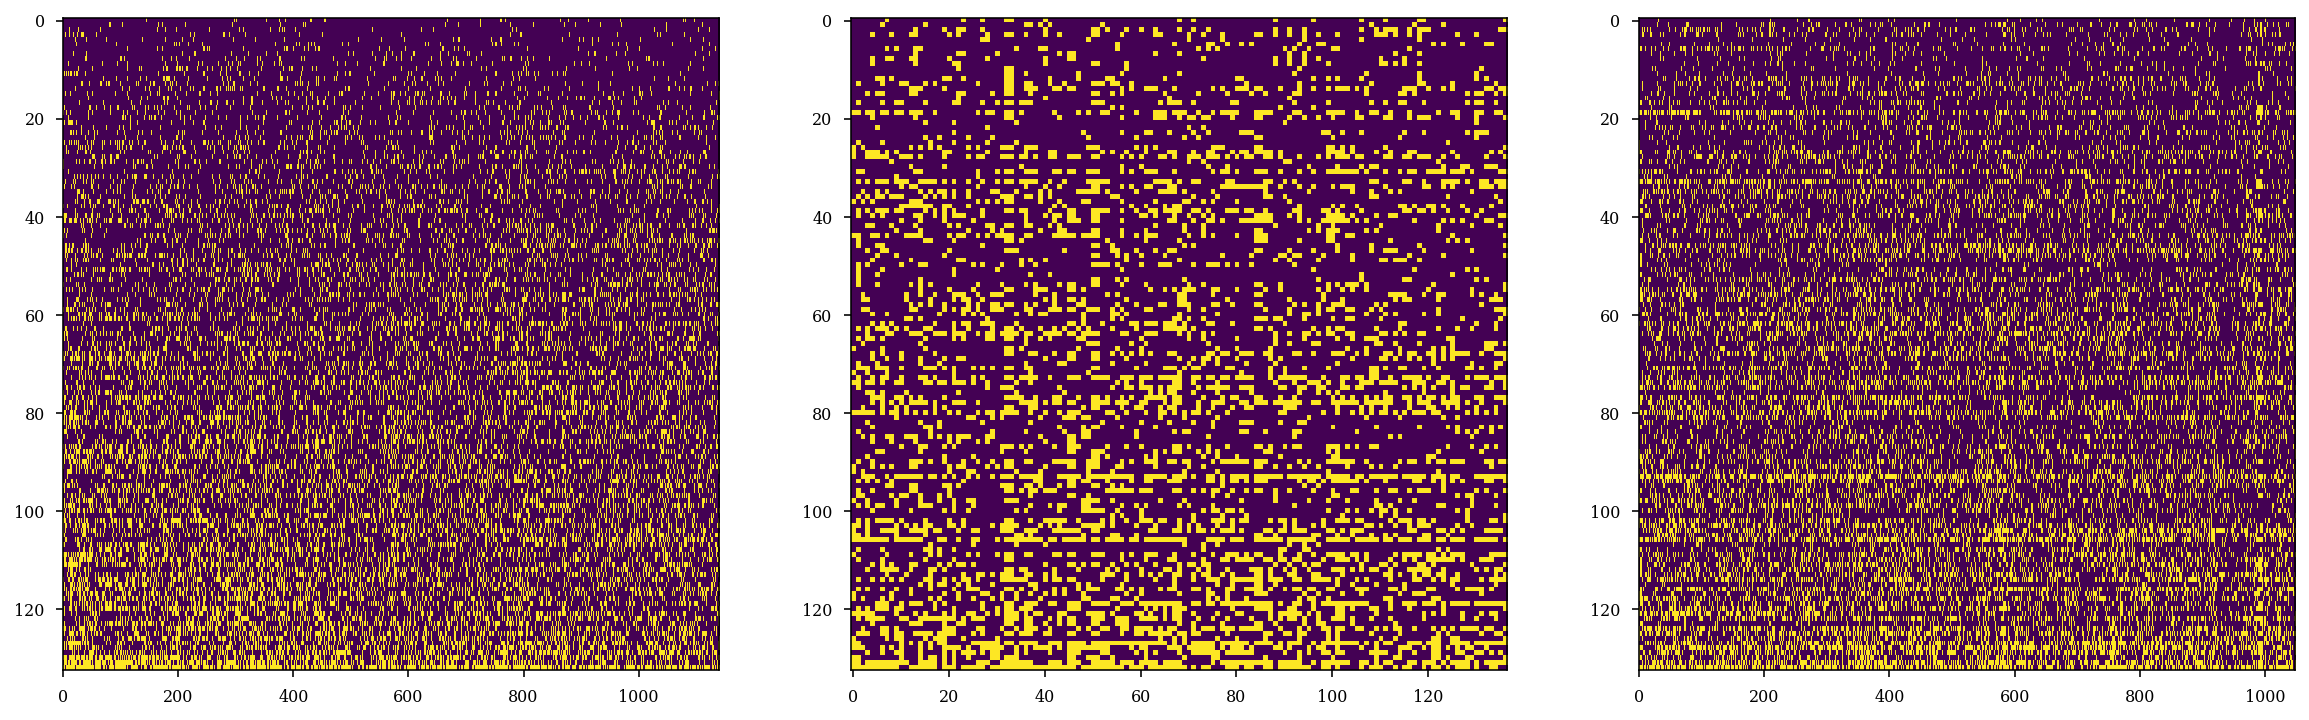

In [284]:
starts = ripple_epochs[behavioral_epochs[0]].starts
stops = ripple_epochs[behavioral_epochs[0]].stops
particip_mat = functions.get_participation(st.data, starts, stops)
pop_partic = particip_mat.mean(axis=0)
unit_partic = particip_mat.mean(axis=1)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
idx = np.argsort(unit_partic)
axs[0].imshow(particip_mat[idx, :], aspect='auto', interpolation='nearest')


starts = ripple_epochs[behavioral_epochs[1]].starts
stops = ripple_epochs[behavioral_epochs[1]].stops
particip_mat = functions.get_participation(st.data, starts, stops)
pop_partic = particip_mat.mean(axis=0)
unit_partic = particip_mat.mean(axis=1)

# idx = np.argsort(unit_partic)
axs[1].imshow(particip_mat[idx, :], aspect='auto', interpolation='nearest')


starts = ripple_epochs[behavioral_epochs[2]].starts
stops = ripple_epochs[behavioral_epochs[2]].stops
particip_mat = functions.get_participation(st.data, starts, stops)
pop_partic = particip_mat.mean(axis=0)
unit_partic = particip_mat.mean(axis=1)

# idx = np.argsort(unit_partic)
axs[2].imshow(particip_mat[idx, :], aspect='auto', interpolation='nearest')


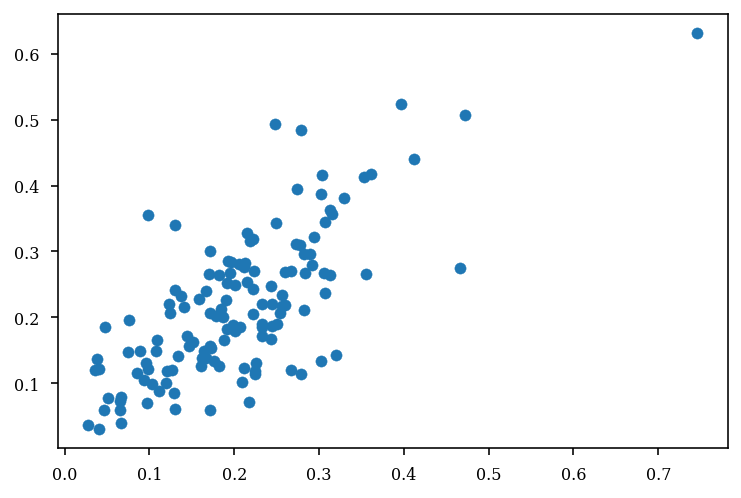

In [285]:
starts = ripple_epochs[behavioral_epochs[0]].starts
stops = ripple_epochs[behavioral_epochs[0]].stops
particip_mat_pre = functions.get_participation(st.data, starts, stops)
# pop_partic = particip_mat.mean(axis=0)
unit_partic_pre = particip_mat_pre.mean(axis=1)

starts = ripple_epochs[behavioral_epochs[2]].starts
stops = ripple_epochs[behavioral_epochs[2]].stops
particip_mat_post = functions.get_participation(st.data, starts, stops)
# pop_partic = particip_mat.mean(axis=0)
unit_partic_post = particip_mat_post.mean(axis=1)

plt.scatter(unit_partic_pre, unit_partic_post)


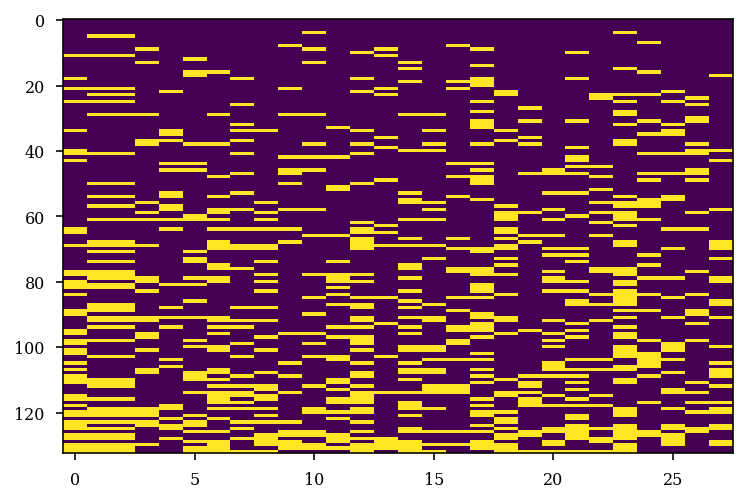

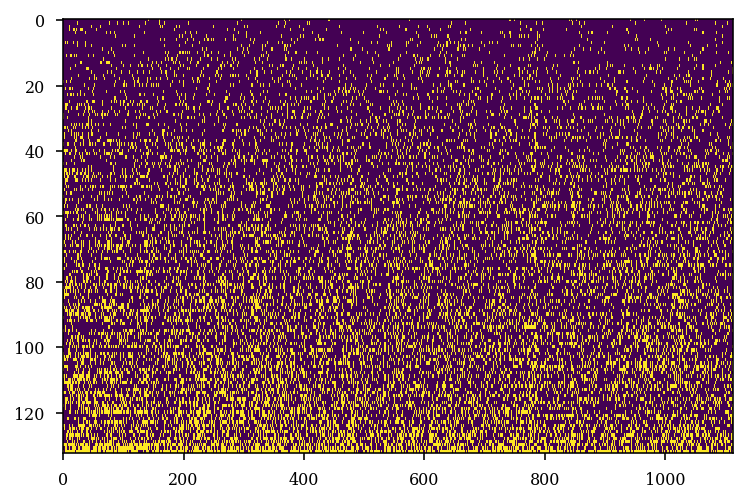

In [131]:
# plt.hist(unit_partic_pre,50)
# plt.show()

idx = results['df'].peaks.between(
    behavioral_epochs[0].start, behavioral_epochs[0].stop)

sort_idx = np.argsort(unit_partic_pre)

plt.imshow(particip_mat_pre[:, results['df'][idx].score_pval_col_cycle <
           0.01][sort_idx], aspect='auto', interpolation='nearest')
plt.figure()
plt.imshow(particip_mat_pre[:, results['df'][idx].score_pval_col_cycle >
           0.01][sort_idx], aspect='auto', interpolation='nearest')


In [132]:
sig_replay_epochs = nel.EpochArray([np.array([results['df'].start[results['df'].score_pval_col_cycle < 0.01],
                                              results['df'].stop[results['df'].score_pval_col_cycle < 0.01]]).T])

non_sig_replay_epochs = nel.EpochArray([np.array([results['df'].start[results['df'].score_pval_col_cycle > 0.01],
                                                  results['df'].stop[results['df'].score_pval_col_cycle > 0.01]]).T])

starts = sig_replay_epochs[behavioral_epochs[0]].starts
stops = sig_replay_epochs[behavioral_epochs[0]].stops
particip_mat = functions.get_participation(st.data, starts, stops)
unit_partic_pre_sig_replay = particip_mat.mean(axis=1)

starts = sig_replay_epochs[behavioral_epochs[1]].starts
stops = sig_replay_epochs[behavioral_epochs[1]].stops
particip_mat = functions.get_participation(st.data, starts, stops)
unit_partic_task_sig_replay = particip_mat.mean(axis=1)

starts = sig_replay_epochs[behavioral_epochs[2]].starts
stops = sig_replay_epochs[behavioral_epochs[2]].stops
particip_mat = functions.get_participation(st.data, starts, stops)
unit_partic_post_sig_replay = particip_mat.mean(axis=1)


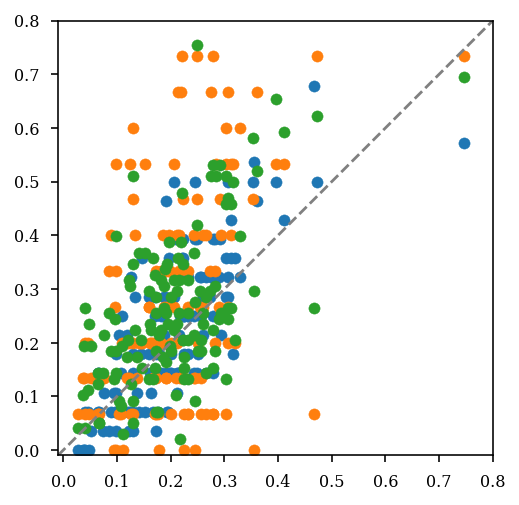

In [156]:
starts = ripple_epochs[behavioral_epochs[0]].starts
stops = ripple_epochs[behavioral_epochs[0]].stops
particip_mat_pre = functions.get_participation(st.data, starts, stops)
unit_partic_pre = particip_mat_pre.mean(axis=1)

plt.scatter(unit_partic_pre, unit_partic_pre_sig_replay)
plt.scatter(unit_partic_pre, unit_partic_task_sig_replay)
plt.scatter(unit_partic_pre, unit_partic_post_sig_replay)
plt.xlim(-.01, .8)
plt.ylim(-.01, .8)
ax = plt.gca()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='grey', ls='--')
ax.set_aspect('equal', adjustable='box')


In [167]:
# starts = sig_replay_epochs[behavioral_epochs[0]].starts
# stops = sig_replay_epochs[behavioral_epochs[0]].stops
# particip_mat = functions.get_participation(st.data,starts,stops)
# unit_partic_pre_sig_replay = particip_mat.mean(axis=1)

# # plt.imshow(unit_partic_pre[particip_mat])
# plt.imshow(unit_partic_pre[particip_mat],aspect='auto',interpolation='nearest')
# plt.colorbar()


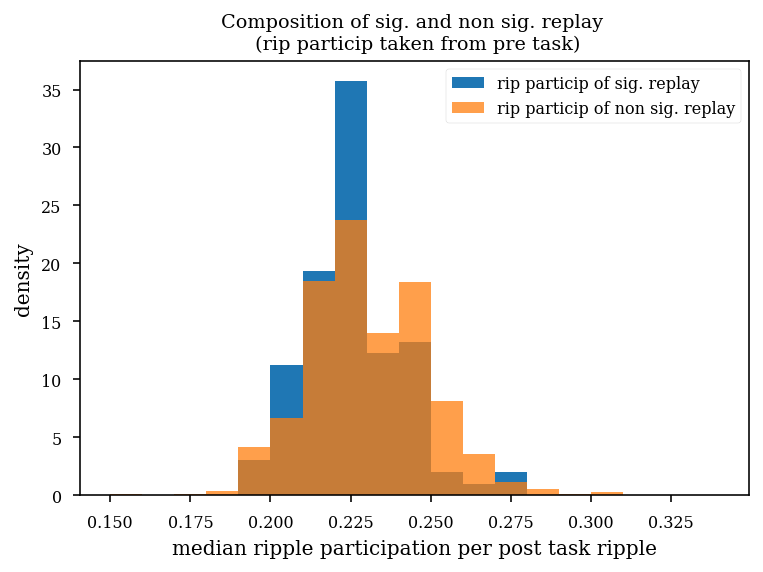

In [191]:
sig_replay_epochs = nel.EpochArray([np.array([results['df'].start[results['df'].score_pval_col_cycle < 0.01],
                                              results['df'].stop[results['df'].score_pval_col_cycle < 0.01]]).T])

non_sig_replay_epochs = nel.EpochArray([np.array([results['df'].start[results['df'].score_pval_col_cycle > 0.01],
                                                  results['df'].stop[results['df'].score_pval_col_cycle > 0.01]]).T])
# get pre participation
starts = ripple_epochs[behavioral_epochs[0]].starts
stops = ripple_epochs[behavioral_epochs[0]].stops
particip_mat_pre = functions.get_participation(st.data, starts, stops)
unit_partic_pre = particip_mat_pre.mean(axis=1)

# get participation in sig. replay
starts = sig_replay_epochs[behavioral_epochs[2]].starts
stops = sig_replay_epochs[behavioral_epochs[2]].stops
particip_mat_sig_replay = functions.get_participation(st.data, starts, stops)

# get participation in non-sig. replay
starts = non_sig_replay_epochs[behavioral_epochs[2]].starts
stops = non_sig_replay_epochs[behavioral_epochs[2]].stops
particip_mat_non_sig_replay = functions.get_participation(
    st.data, starts, stops)

par_out = []
for event in particip_mat_sig_replay.T:
    par_out.append(np.median(unit_partic_pre[event == 1]))
par_out_sig_replay = np.hstack(par_out)

par_out = []
for event in particip_mat_non_sig_replay.T:
    par_out.append(np.median(unit_partic_pre[event == 1]))
par_out_non_sig_replay = np.hstack(par_out)

bins = np.arange(.15, .35, .01)
plt.hist(par_out_sig_replay, bins=bins, density=True,
         label='rip particip of sig. replay')
plt.hist(par_out_non_sig_replay, bins=bins, alpha=.75,
         density=True, label='rip particip of non sig. replay')
plt.xlabel('median ripple participation per post task ripple')
plt.ylabel('density')
plt.title(
    'Composition of sig. and non sig. replay \n (rip particip taken from pre task)')
plt.legend()
plt.show()


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


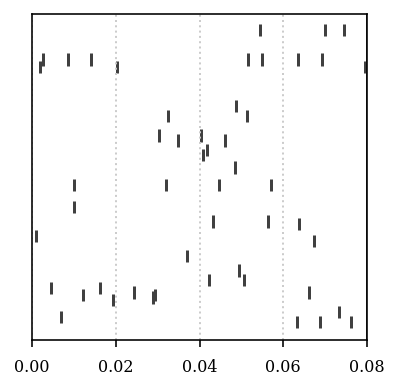

In [20]:

plt.figure(figsize=(3, 3))

# plt.eventplot(results['sta_placecells'].data)
# plt.show()
bst = results['bst_placecells']
st = results['sta_placecells']
tc_placecells = results['tc']

idx = 0
bst = bst[idx]

no = tc_placecells.get_peak_firing_order_ids()
st.reorder_units_by_ids(no, inplace=True)

st_cut = st[bst.support]
st_cut._support = bst.support  # hacky fix so that we can plot events out of order
st_cut = nel.utils.collapse_time(st_cut)

ax = plt.gca()
npl.rasterplot(st_cut, vertstack=True, ax=ax, lh=5)
ax.set_xlim(st_cut.support.time.squeeze())

bin_edges = np.linspace(st_cut.support.time[0, 0],
                        st_cut.support.time[0, 1],
                        bst.n_bins+1)

ax.vlines(bin_edges, *ax.get_ylim(), lw=1, linestyle=':', color='0.8')
ax.vlines(bin_edges[np.cumsum(bst.lengths)], *ax.get_ylim(), lw=1, color='0.2')

npl.utils.no_yticks(ax)
npl.utils.no_yticklabels(ax)


## Explore broad features of sig and non sig replay from different thresholds

<AxesSubplot:xlabel='pop_partic', ylabel='Probability'>

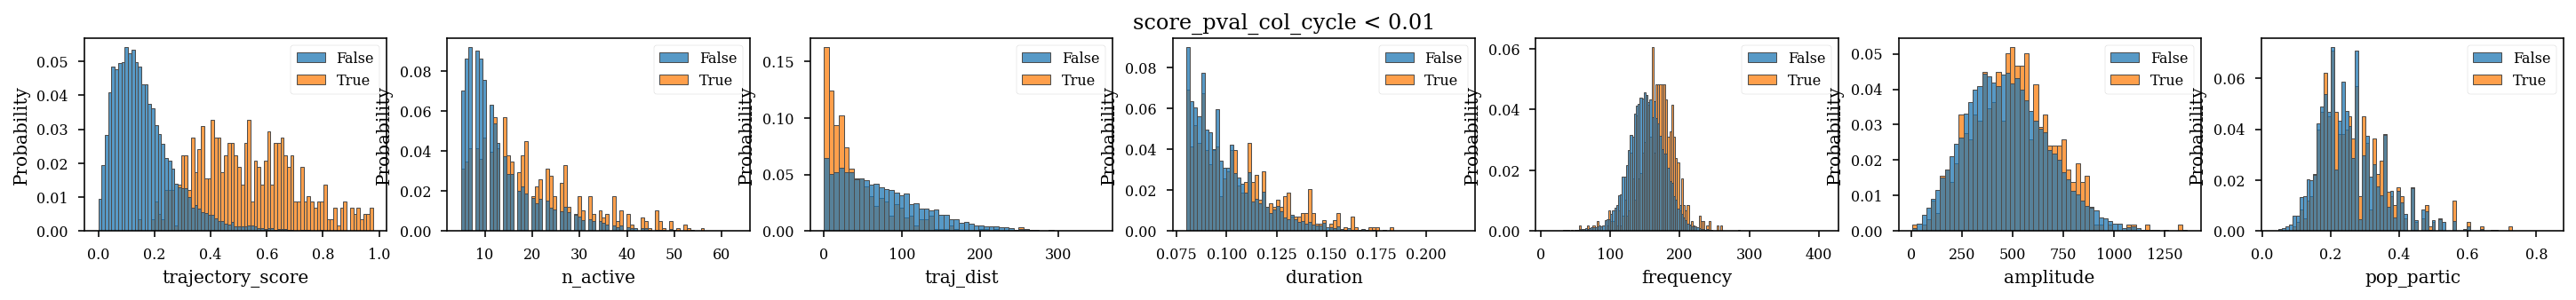

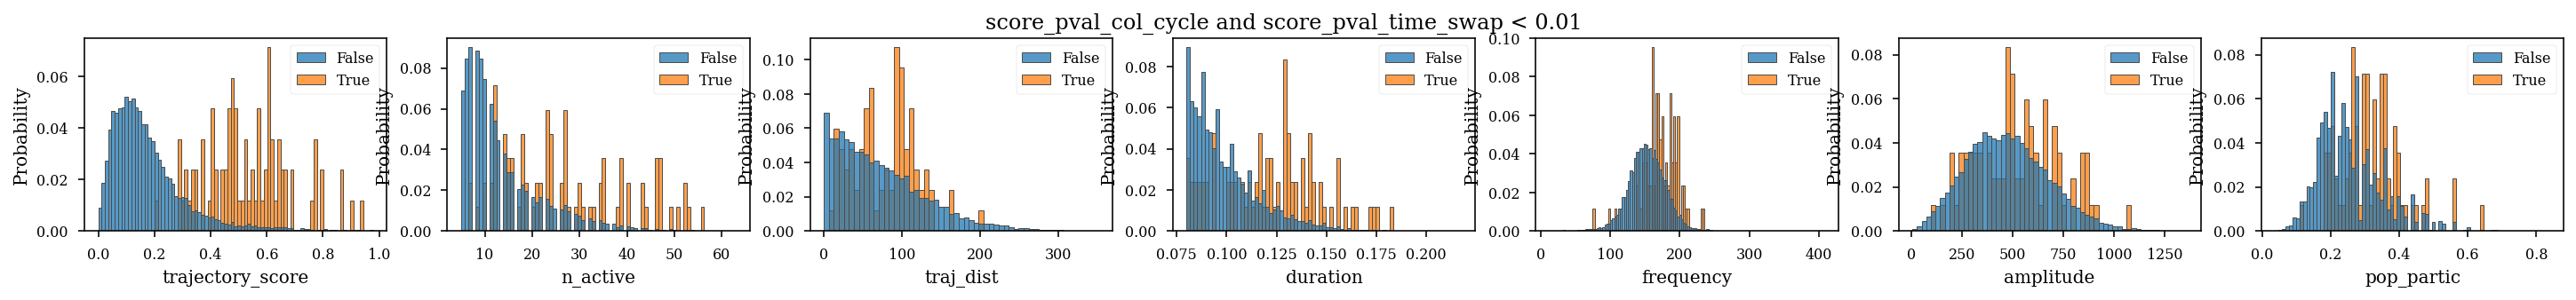

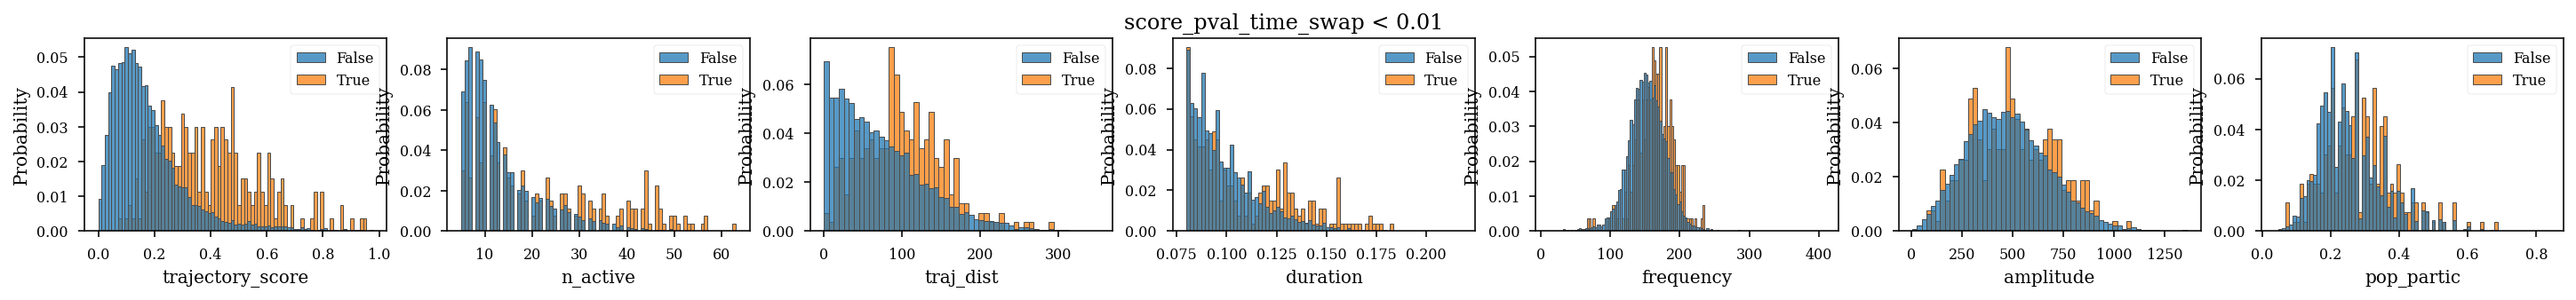

In [198]:
fig, axs = plt.subplots(1, 7, figsize=(25, 2))
fig.suptitle('score_pval_col_cycle < 0.01', fontsize=12)
idx = df['score_pval_col_cycle'].values < 0.01
sns.histplot(df, x="trajectory_score", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[0])
sns.histplot(df, x="n_active", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[1])
sns.histplot(df, x="traj_dist", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[2])
sns.histplot(df, x="duration", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[3])
sns.histplot(df, x="frequency", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[4])
sns.histplot(df, x="amplitude", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[5])
sns.histplot(df, x="pop_partic", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[6])

fig, axs = plt.subplots(1, 7, figsize=(25, 2))
fig.suptitle(
    'score_pval_col_cycle and score_pval_time_swap < 0.01', fontsize=12)
idx = (df['score_pval_col_cycle'] < 0.01) & (df['score_pval_time_swap'] < 0.01)
sns.histplot(df, x="trajectory_score", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[0])
sns.histplot(df, x="n_active", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[1])
sns.histplot(df, x="traj_dist", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[2])
sns.histplot(df, x="duration", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[3])
sns.histplot(df, x="frequency", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[4])
sns.histplot(df, x="amplitude", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[5])
sns.histplot(df, x="pop_partic", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[6])

fig, axs = plt.subplots(1, 7, figsize=(25, 2))
fig.suptitle('score_pval_time_swap < 0.01', fontsize=12)
idx = (df['score_pval_time_swap'].values < 0.01)
sns.histplot(df, x="trajectory_score", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[0])
sns.histplot(df, x="n_active", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[1])
sns.histplot(df, x="traj_dist", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[2])
sns.histplot(df, x="duration", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[3])
sns.histplot(df, x="frequency", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[4])
sns.histplot(df, x="amplitude", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[5])
sns.histplot(df, x="pop_partic", hue=idx, edgecolor=".3",
             stat='probability', common_norm=False, linewidth=.5, ax=axs[6])


## Nice event plots

In [100]:
def gather_events(basepath):
    epoch_df = loading.load_epoch(basepath)
    pattern_idx, _ = functions.find_epoch_pattern(
        epoch_df.environment, ['sleep', 'linear', 'sleep'])
    epoch_df = epoch_df[pattern_idx]
    presleep_epochs = nel.EpochArray([np.array([epoch_df.startTime.iloc[0],
                                                epoch_df.stopTime.iloc[0]]).T])
    linear_epochs = nel.EpochArray([np.array([epoch_df.startTime.iloc[1],
                                              epoch_df.stopTime.iloc[1]]).T])
    postsleep_epochs = nel.EpochArray([np.array([epoch_df.startTime.iloc[2],
                                                epoch_df.stopTime.iloc[2]]).T])

    state_dict = loading.load_SleepState_states(basepath)
    nrem_epochs = nel.EpochArray(state_dict['NREMstate'])
    wake_epochs = nel.EpochArray(state_dict['WAKEstate'])
    rem_epochs = nel.EpochArray(state_dict['REMstate'])

    temp_df = results['outbound_epochs']['df'][(results['outbound_epochs']['df']['score_pval_time_swap'] < 0.05) &
                                               (results['inbound_epochs']['df'].replay_type == 'reverse')]
    reverse_replay_epochs = nel.EpochArray([np.array([temp_df.start,
                                                      temp_df.stop]).T])

    temp_df = results['inbound_epochs']['df'][(results['inbound_epochs']['df']['score_pval_time_swap'] < 0.05) &
                                              (results['inbound_epochs']['df'].replay_type == 'forward')]
    forward_replay_epochs = nel.EpochArray([np.array([temp_df.start,
                                                      temp_df.stop]).T])

    events = []
    events.append(nrem_epochs)
    events.append(wake_epochs)
    events.append(rem_epochs)
    events.append(presleep_epochs)
    events.append(linear_epochs)
    events.append(postsleep_epochs)
    events.append(reverse_replay_epochs)
    events.append(forward_replay_epochs)

    return events, ['nrem', 'wake', 'rem', 'presleep', 'linear', 'postsleep', 'reverse_replay', 'forward_replay']


In [101]:
import custom_plots

session = r'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Achilles_Achilles_10252013.pkl'
with open(session, 'rb') as f:
    results = pickle.load(f)
try:
    events, labels = gather_events(
        results['outbound_epochs']['df'].basepath.unique()[0])
    basepath = results['outbound_epochs']['df'].basepath.unique()[0]
except:
    events, labels = gather_events(
        results['inbound_epochs']['df'].basepath.unique()[0])
    basepath = results['inbound_epochs']['df'].basepath.unique()[0]

# plt.figure(figsize=(20, 5))
# custom_plots.plot_events(events, labels,alpha=1)
# plt.title(basepath)

C:\Users\Cornell\AppData\Local\Temp/ipykernel_13168/1233723725.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [103]:
display(events)
print(labels)

[<EpochArray at 0x1f10dd3cd90: 60 epochs> of length 4:24:50 hours,
 <EpochArray at 0x1f10dd3cf40: 62 epochs> of length 4:39:07 hours,
 <EpochArray at 0x1f10dd3c4c0: 22 epochs> of length 34:31 minutes,
 <EpochArray at 0x1f1005acbe0: 1 epoch> of length 5:01:19:500 hours,
 <EpochArray at 0x1f1002f25b0: 1 epoch> of length 34:27:500 minutes,
 <EpochArray at 0x1f1002f2dc0: 1 epoch> of length 4:05:14:103 hours,
 <EpochArray at 0x1f104ff95b0: 82 epochs> of length 8.6952 seconds,
 <EpochArray at 0x1f100bc8340: 71 epochs> of length 7.156 seconds]

['nrem', 'wake', 'rem', 'presleep', 'linear', 'postsleep', 'reverse_replay', 'forward_replay']


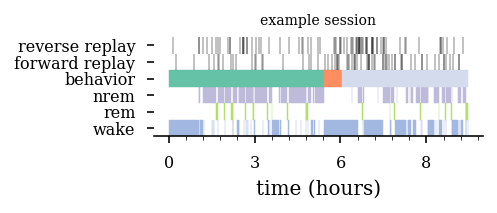

In [130]:
events
labels
import matplotlib

plt.figure(figsize=functions.set_size('thesis', fraction=.5, subplots=(1, 2)), edgecolor=None)

# cmap = matplotlib.cm.get_cmap('tab20')
y = np.linspace(0, 1, 7)

for ep in events[np.where(np.array(labels) == 'wake')[0][0]]:
    plt.axvspan(ep.starts, ep.stops,y[0],y[1], alpha=1, color='#a3b8e0ff')
for ep in events[np.where(np.array(labels) == 'rem')[0][0]]:
    plt.axvspan(ep.starts, ep.stops,y[1],y[2], alpha=1, color='#b3de69')
for ep in events[np.where(np.array(labels) == 'nrem')[0][0]]:
    plt.axvspan(ep.starts, ep.stops,y[2],y[3], alpha=1, color='#bebada')

for ep in events[np.where(np.array(labels) == 'presleep')[0][0]]:
    plt.axvspan(ep.starts, ep.stops,y[3],y[4], alpha=1, color='#66c2a689')
for ep in events[np.where(np.array(labels) == 'linear')[0][0]]:
    plt.axvspan(ep.starts, ep.stops,y[3],y[4], alpha=1, color='#fc8e6299')
for ep in events[np.where(np.array(labels) == 'postsleep')[0][0]]:
    plt.axvspan(ep.starts, ep.stops,y[3],y[4], alpha=1, color='#d3dbecff')

for ep in events[np.where(np.array(labels) == 'forward_replay')[0][0]]:
    plt.axvspan(ep.starts, ep.stops,y[4],y[5], alpha=1, color='k') 
for ep in events[np.where(np.array(labels) == 'reverse_replay')[0][0]]:
    plt.axvspan(ep.starts, ep.stops,y[5],y[6], alpha=1, color='k')

plt.xlabel('time (hours)')
plt.title('example session',fontsize=7)
ax = plt.gca()

import matplotlib.ticker as ticker
scale_x = 60
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(x/scale_x/scale_x)))
ax.xaxis.set_major_formatter(ticks_x)

ax.set_yticks(y[:-1] + np.diff(y)[0]/2)
ax.set_yticklabels(['wake','rem','nrem','behavior','forward replay','reverse replay'])

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(os.path.join(fig_save_path,'event_plot_example.svg'),dpi=300,bbox_inches='tight')


C:\Users\Cornell\AppData\Local\Temp/ipykernel_2424/1754881867.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_2424/1754881867.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_2424/1754881867.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_2424/1754881867.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_2424/1754881867.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_2424/1754881867.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Cornell\AppData\Local\Temp/ipykernel_2424/1754881867.py:18: UserWarning: Boolean Series key will be reindexed to match Da

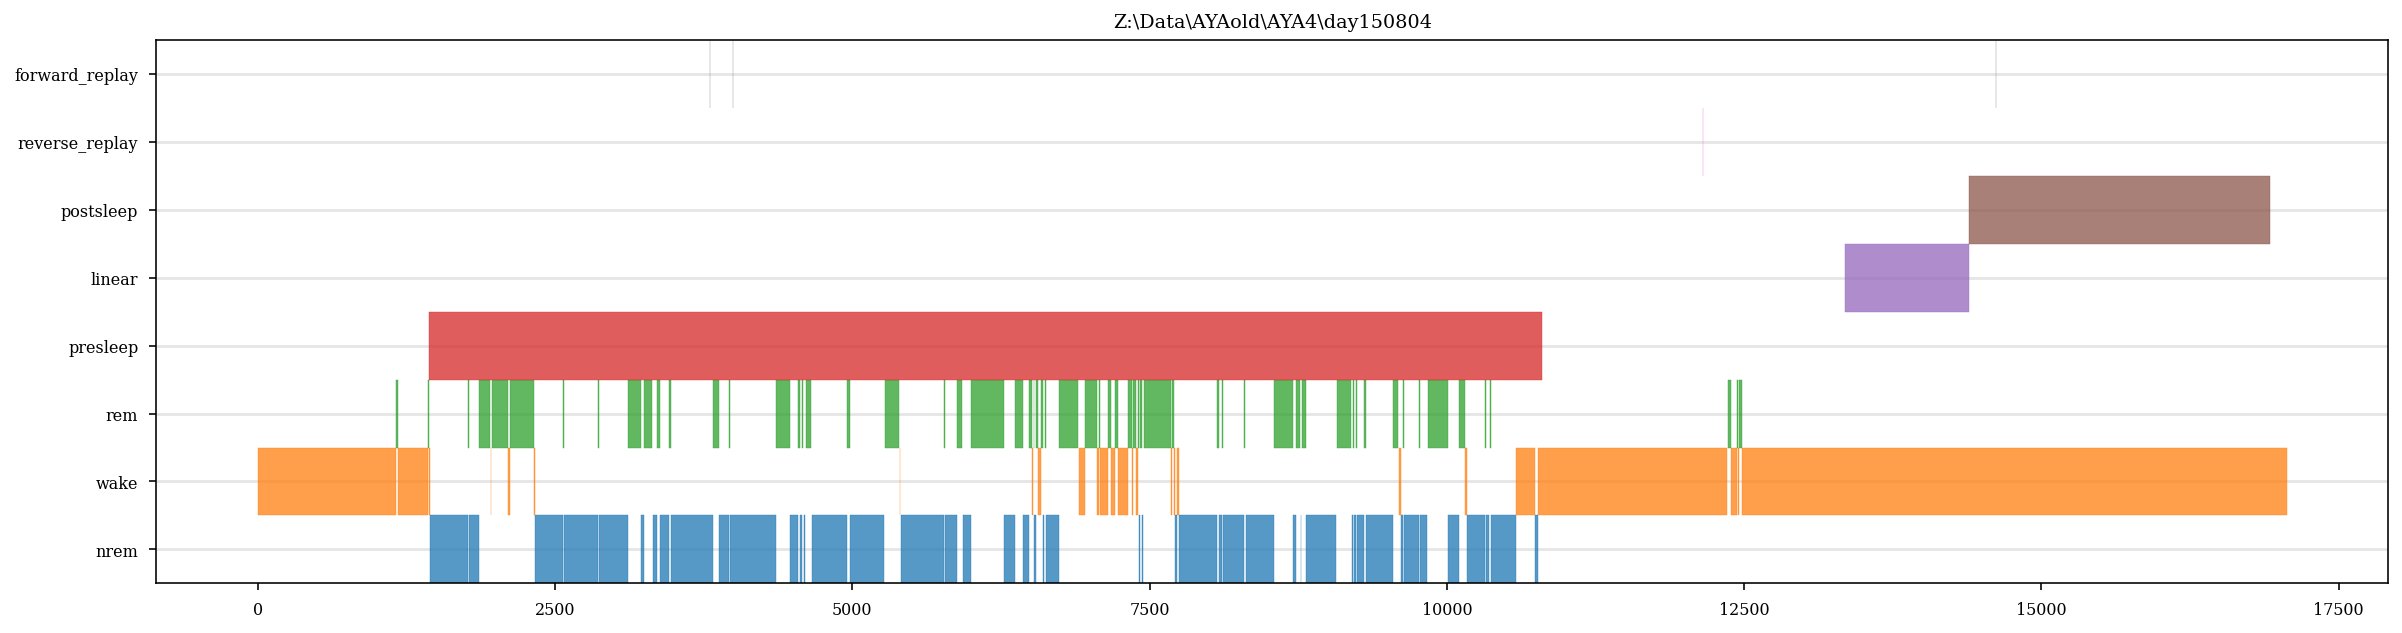

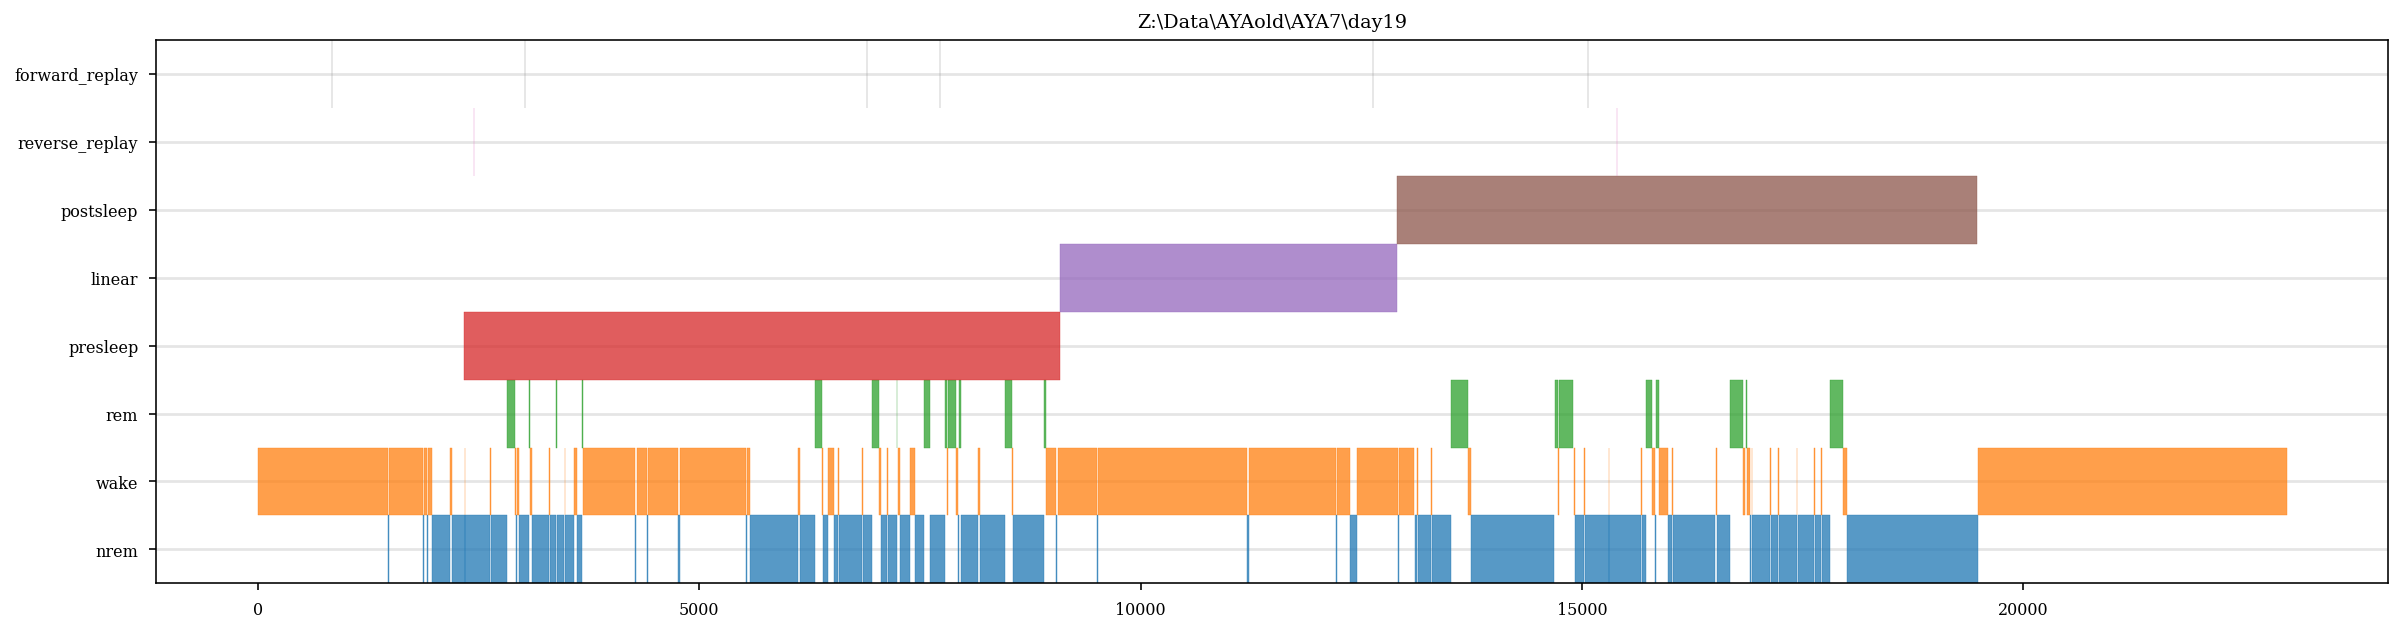

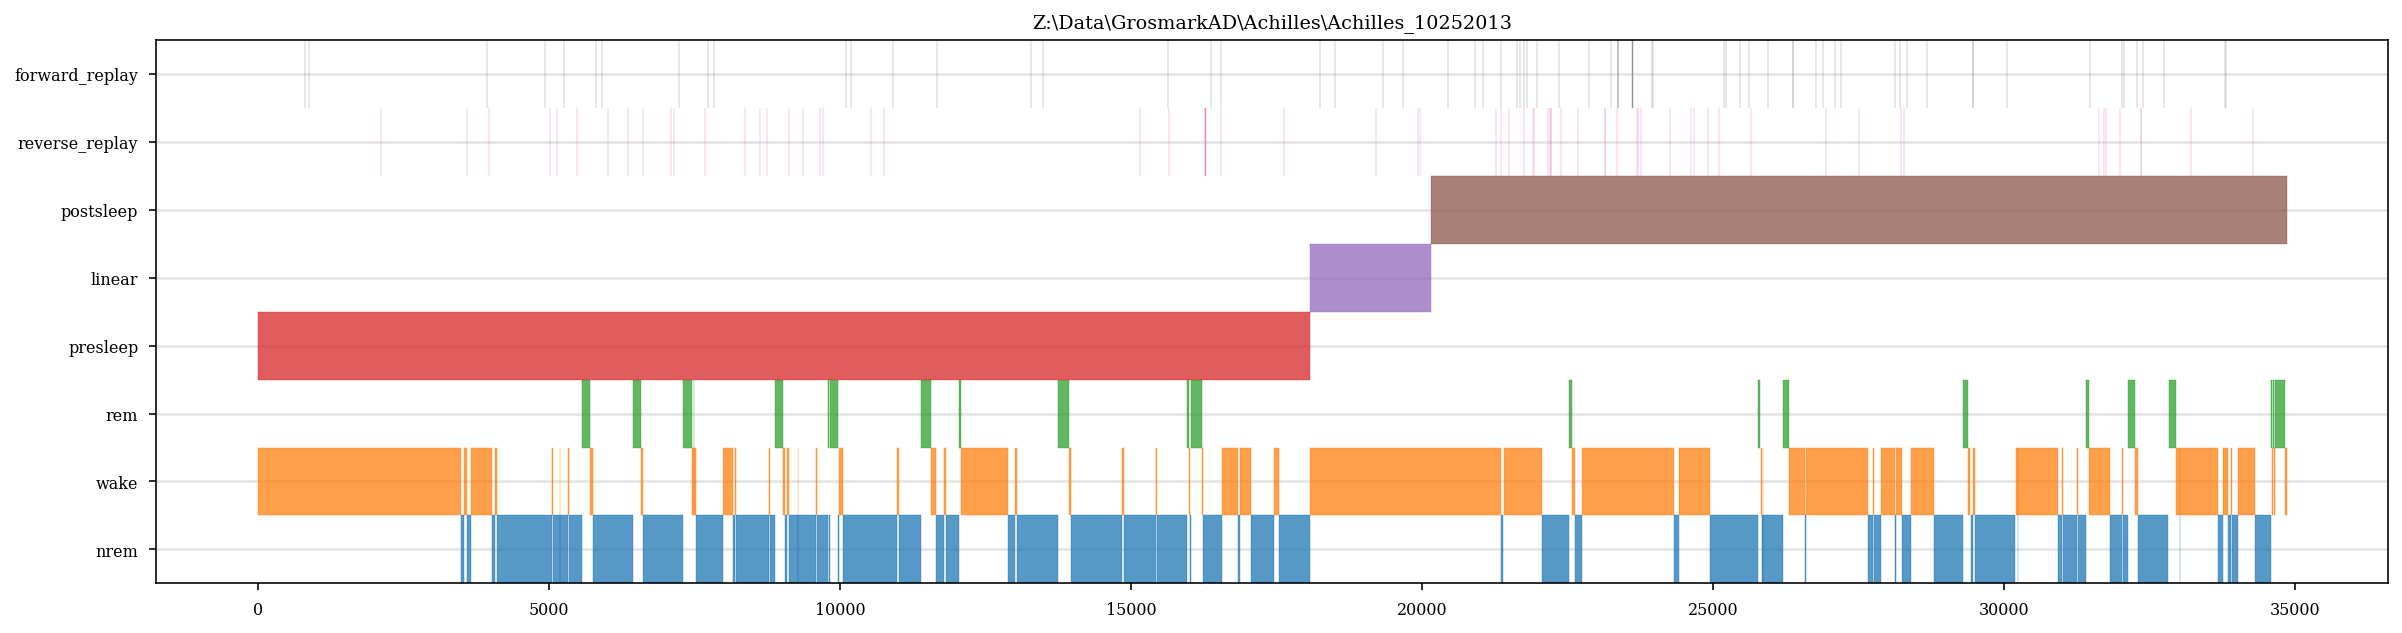

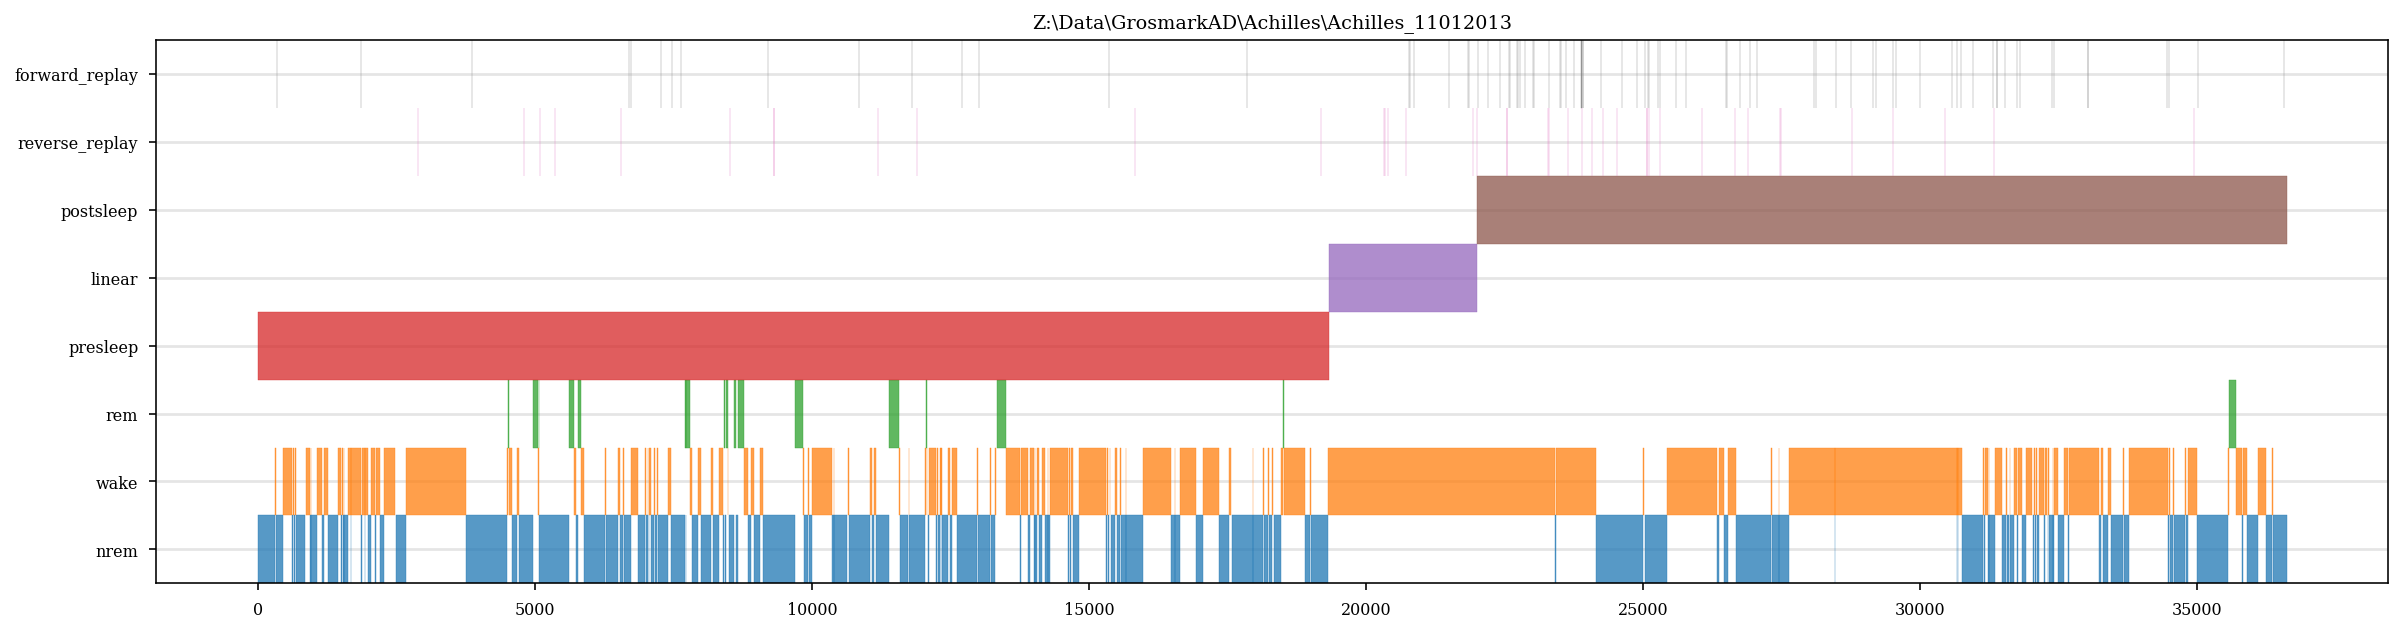

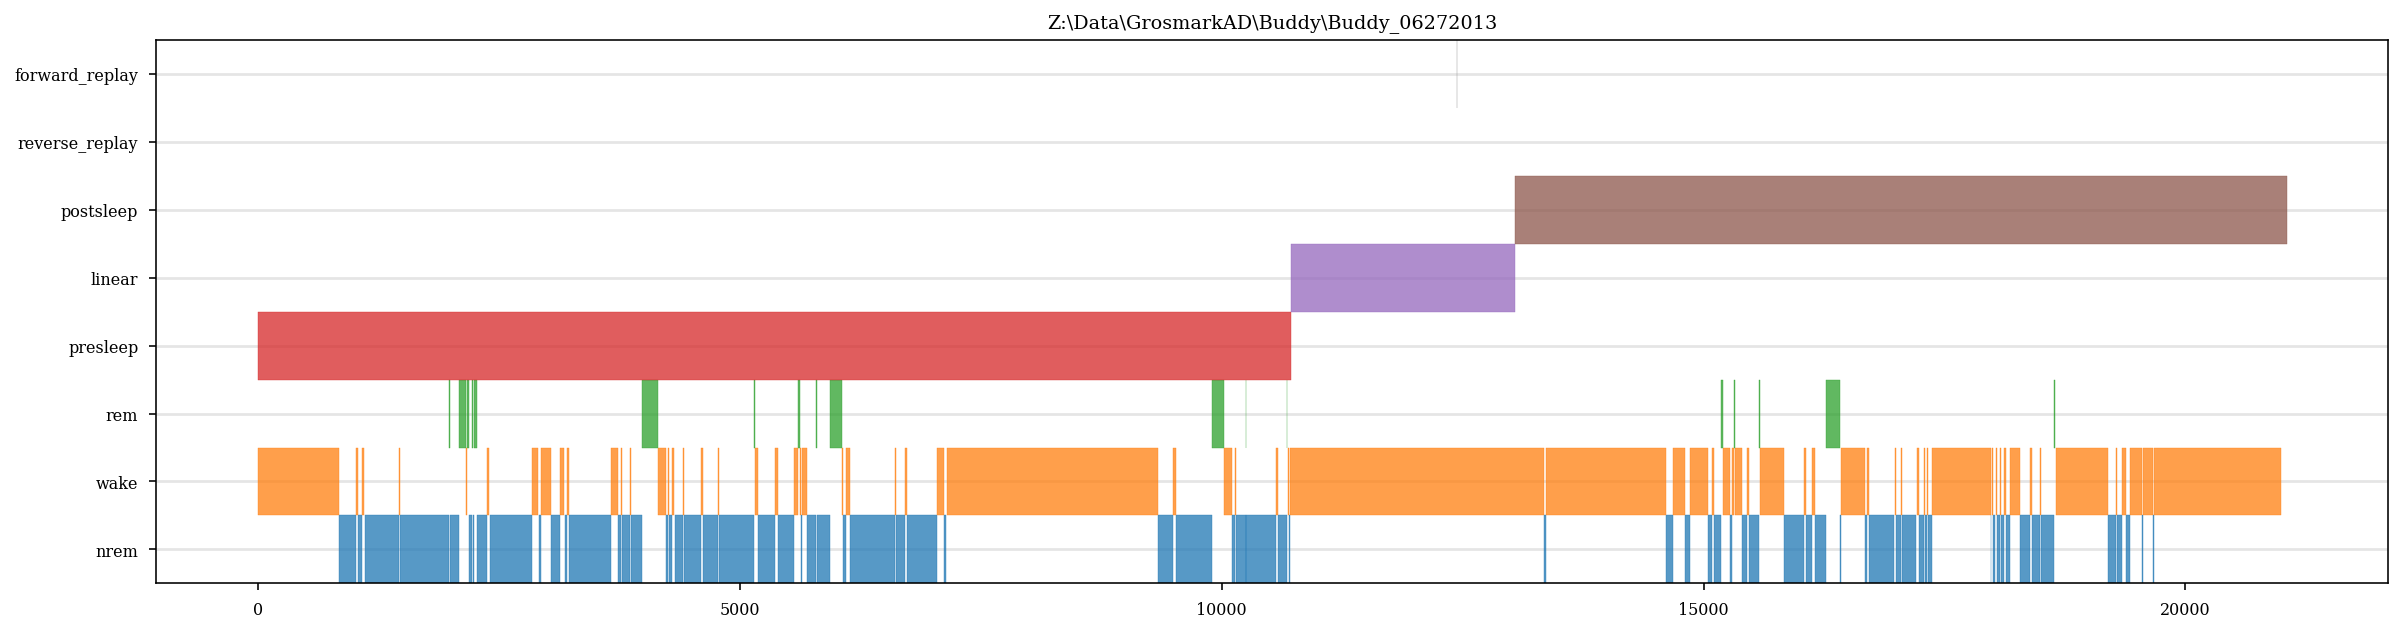

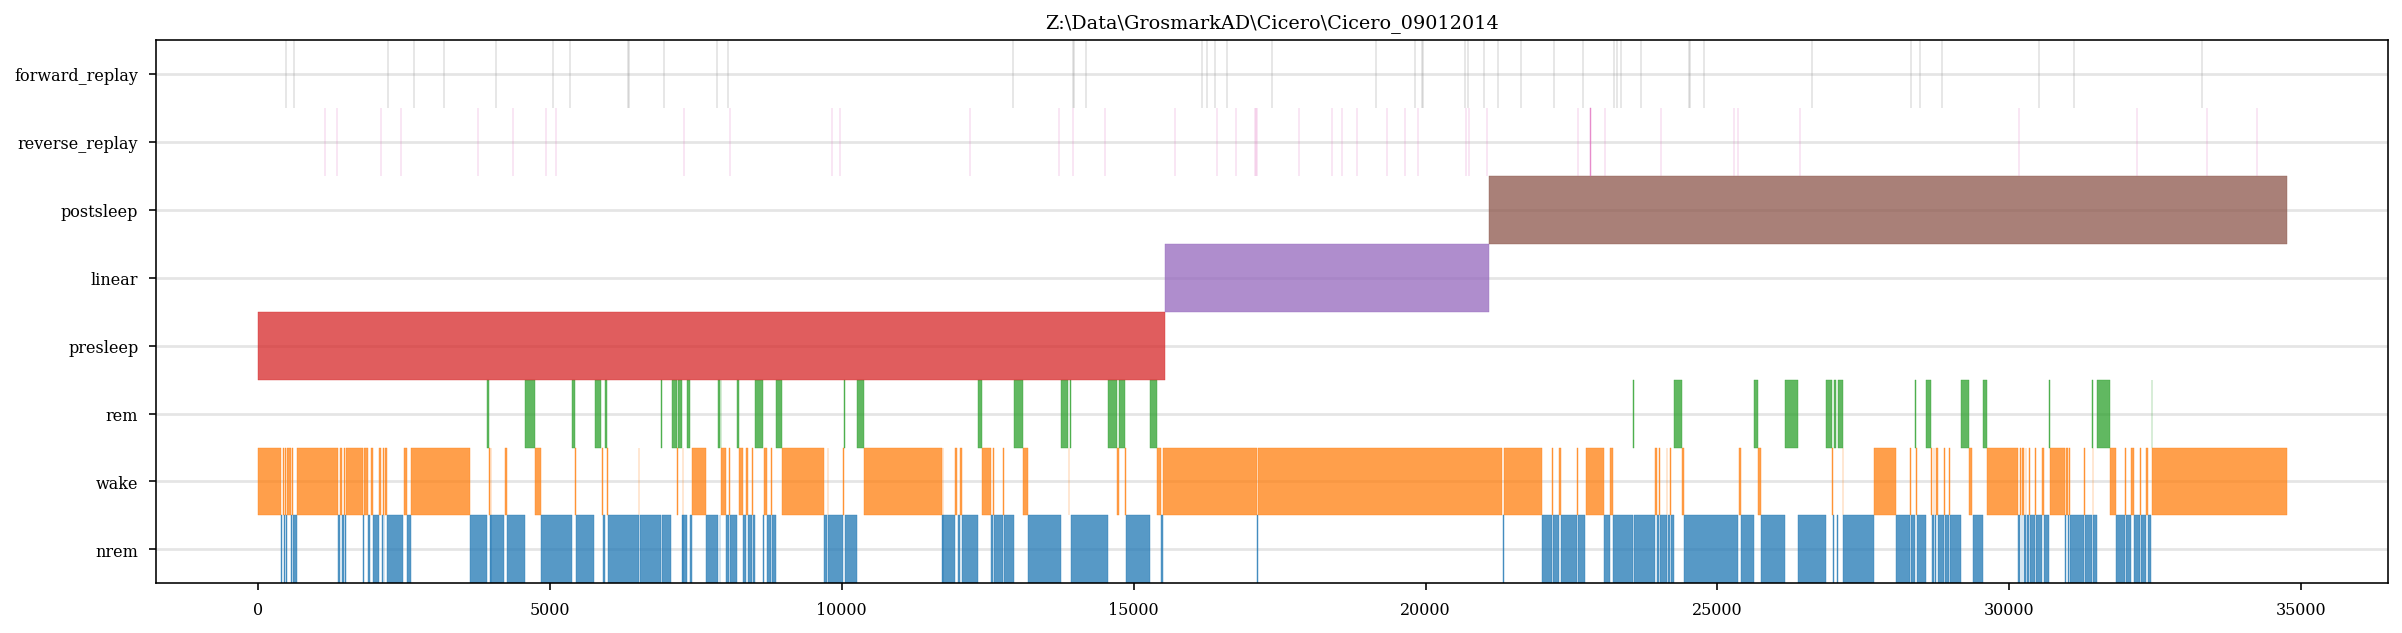

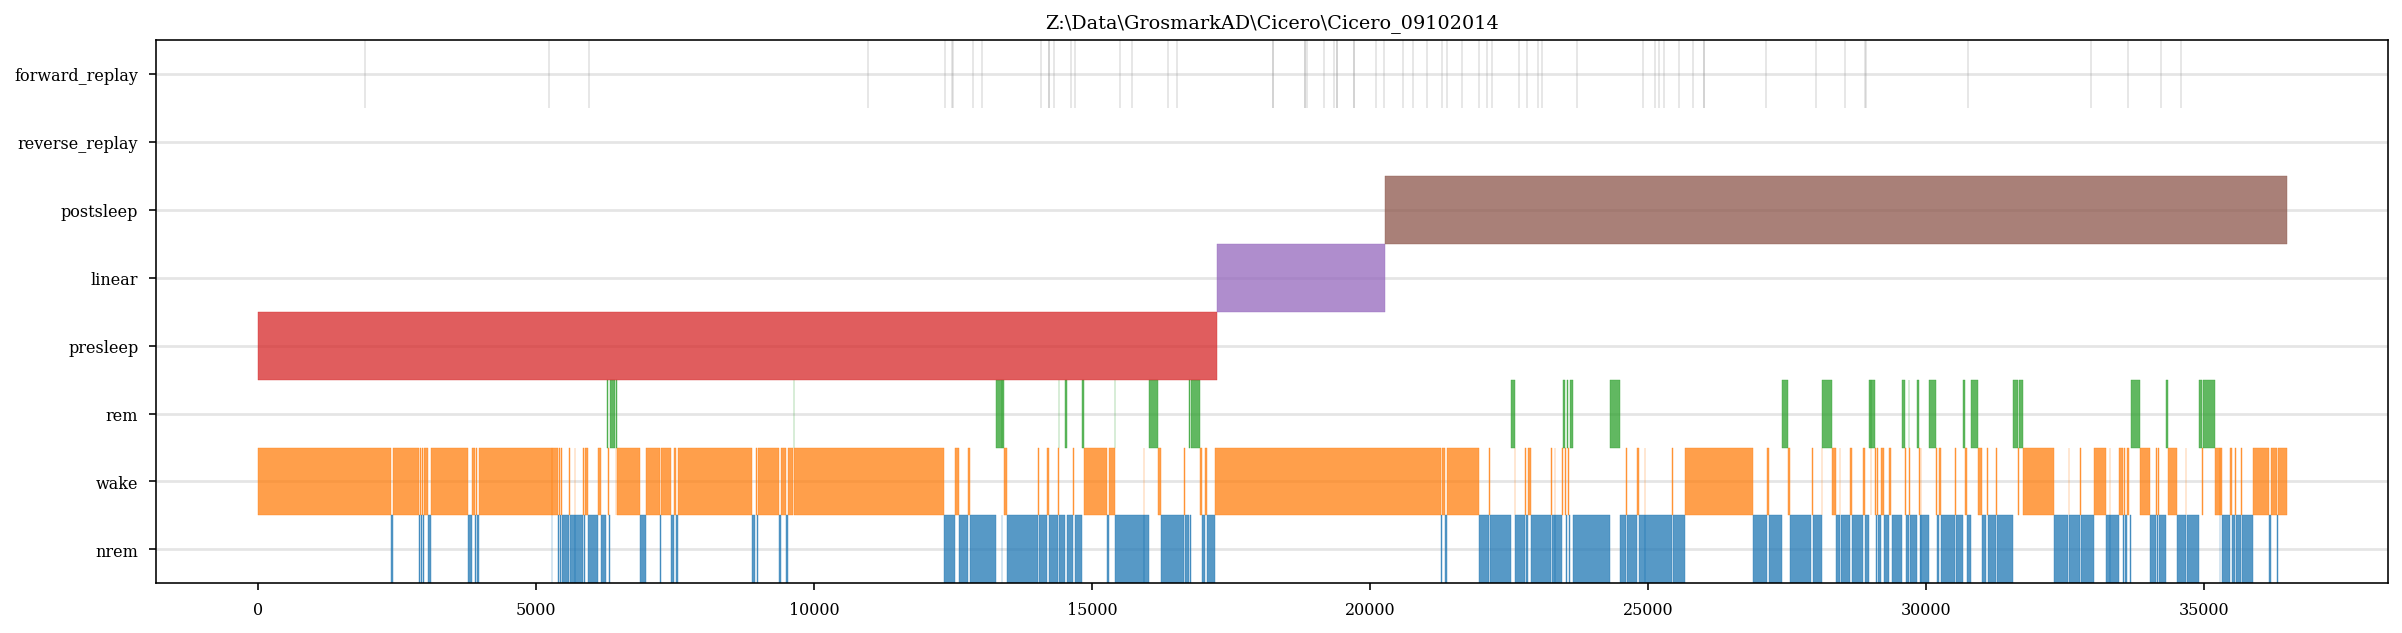

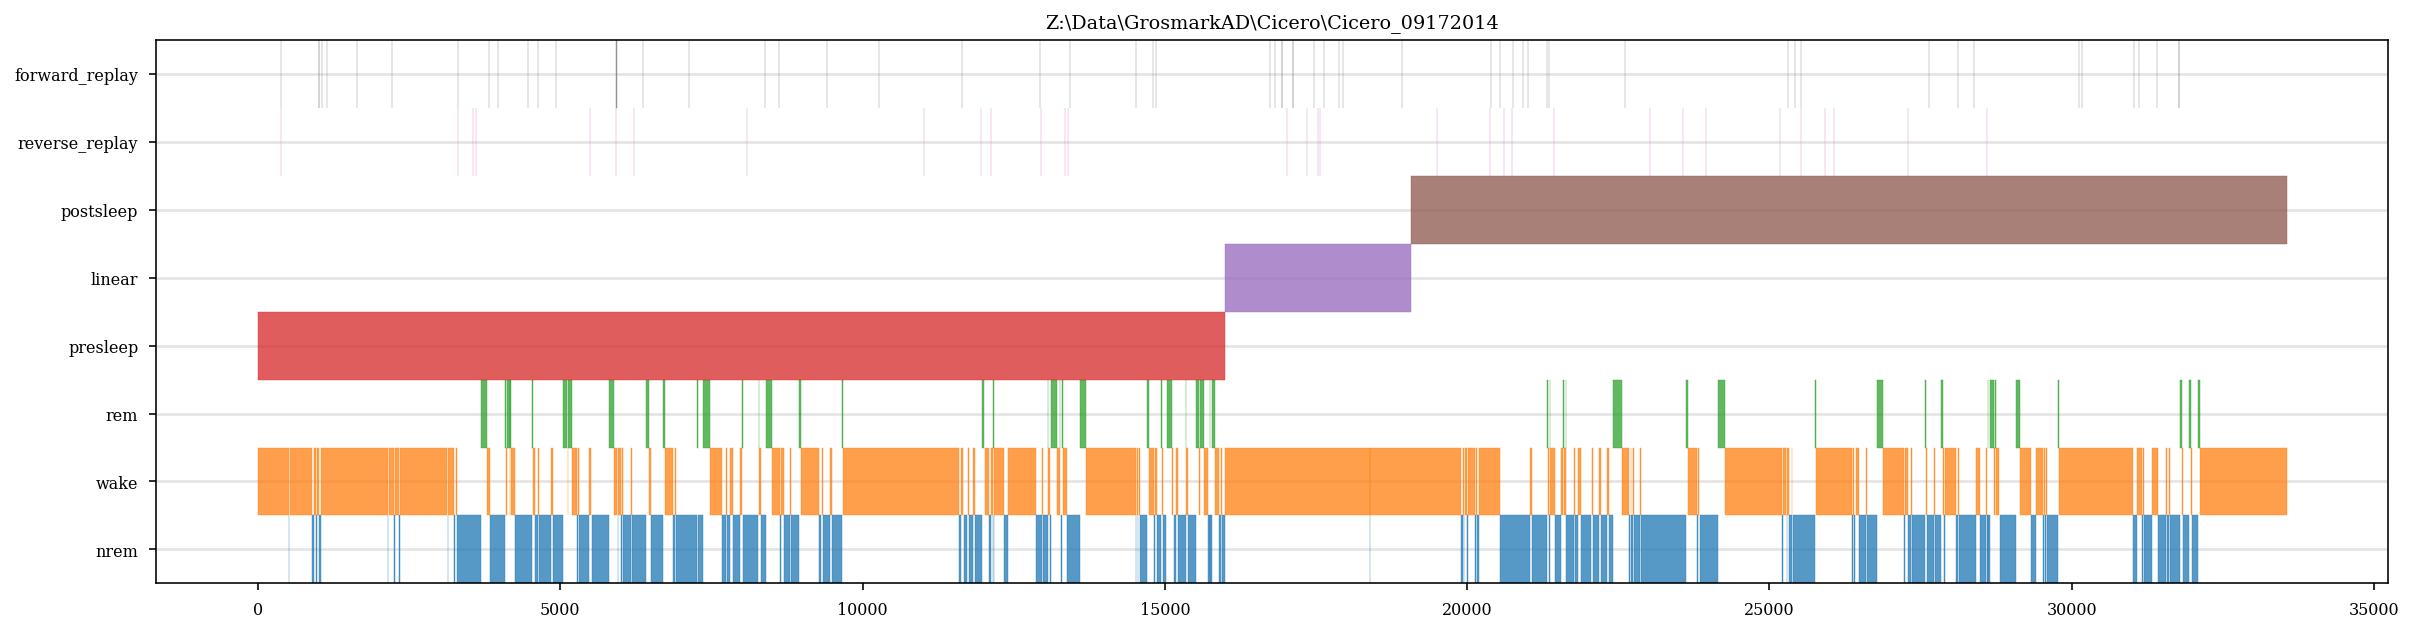

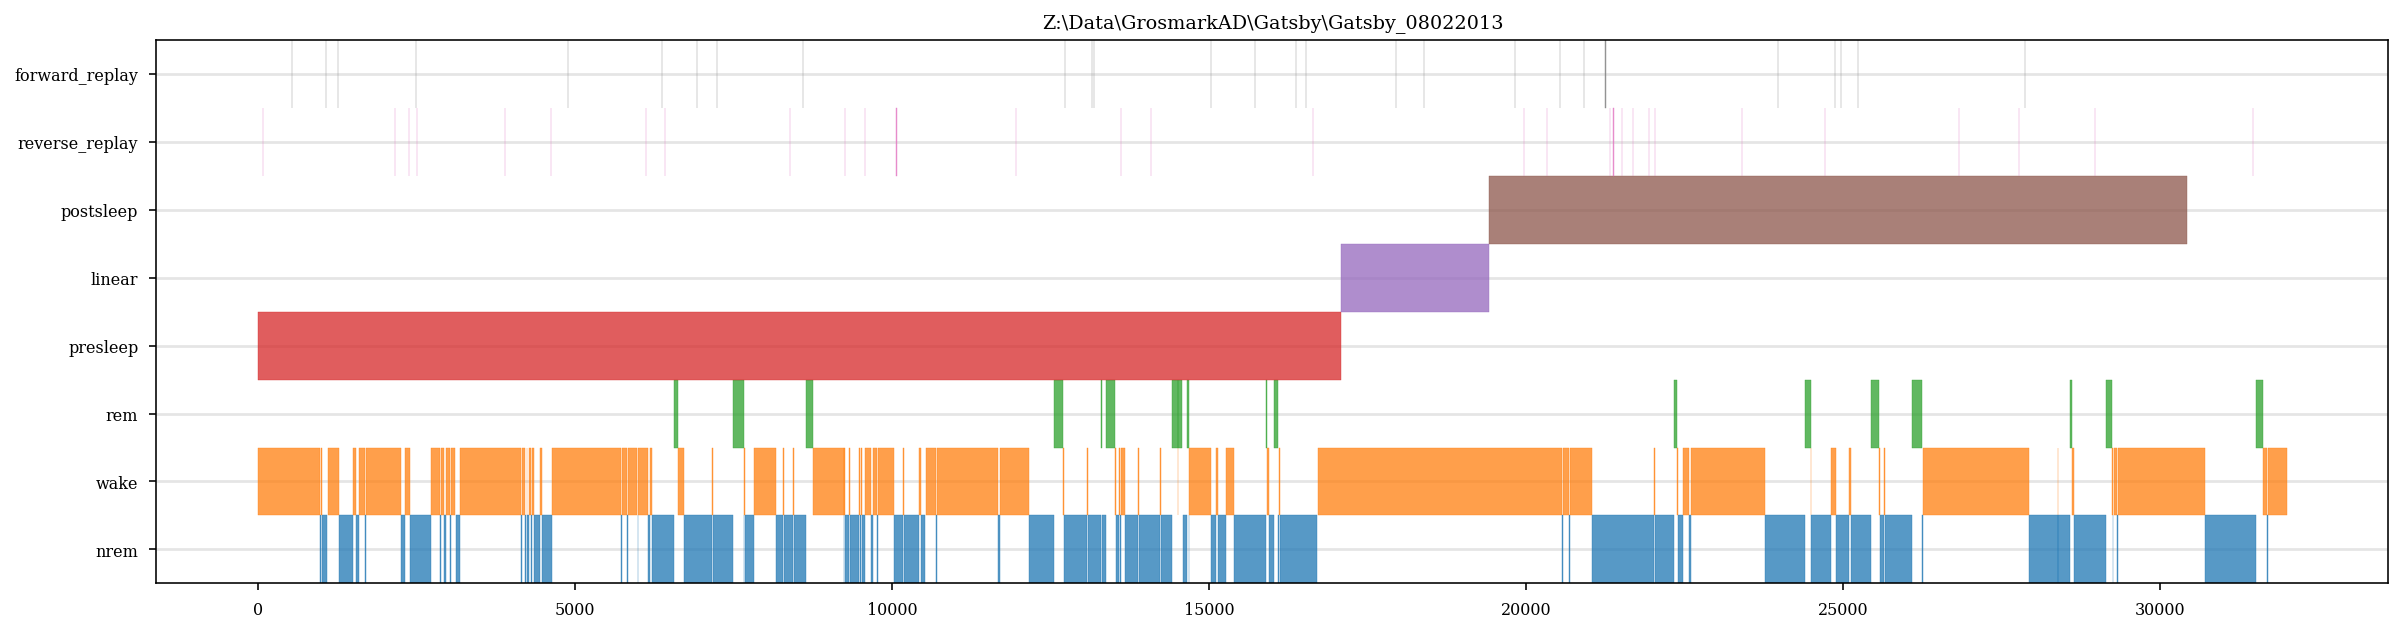

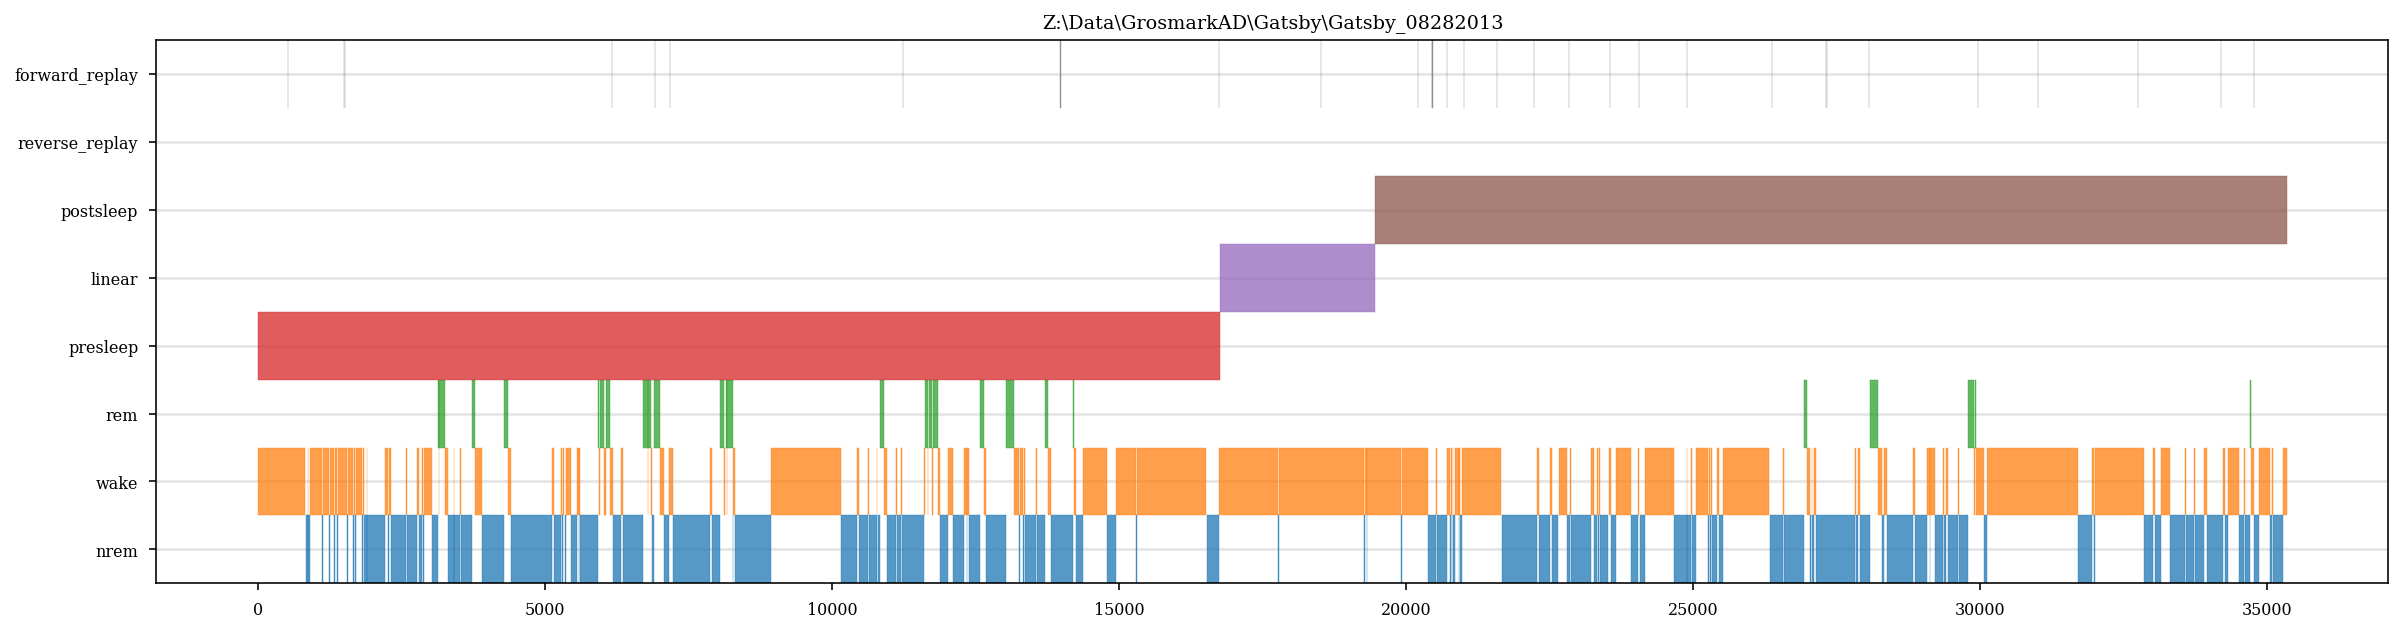

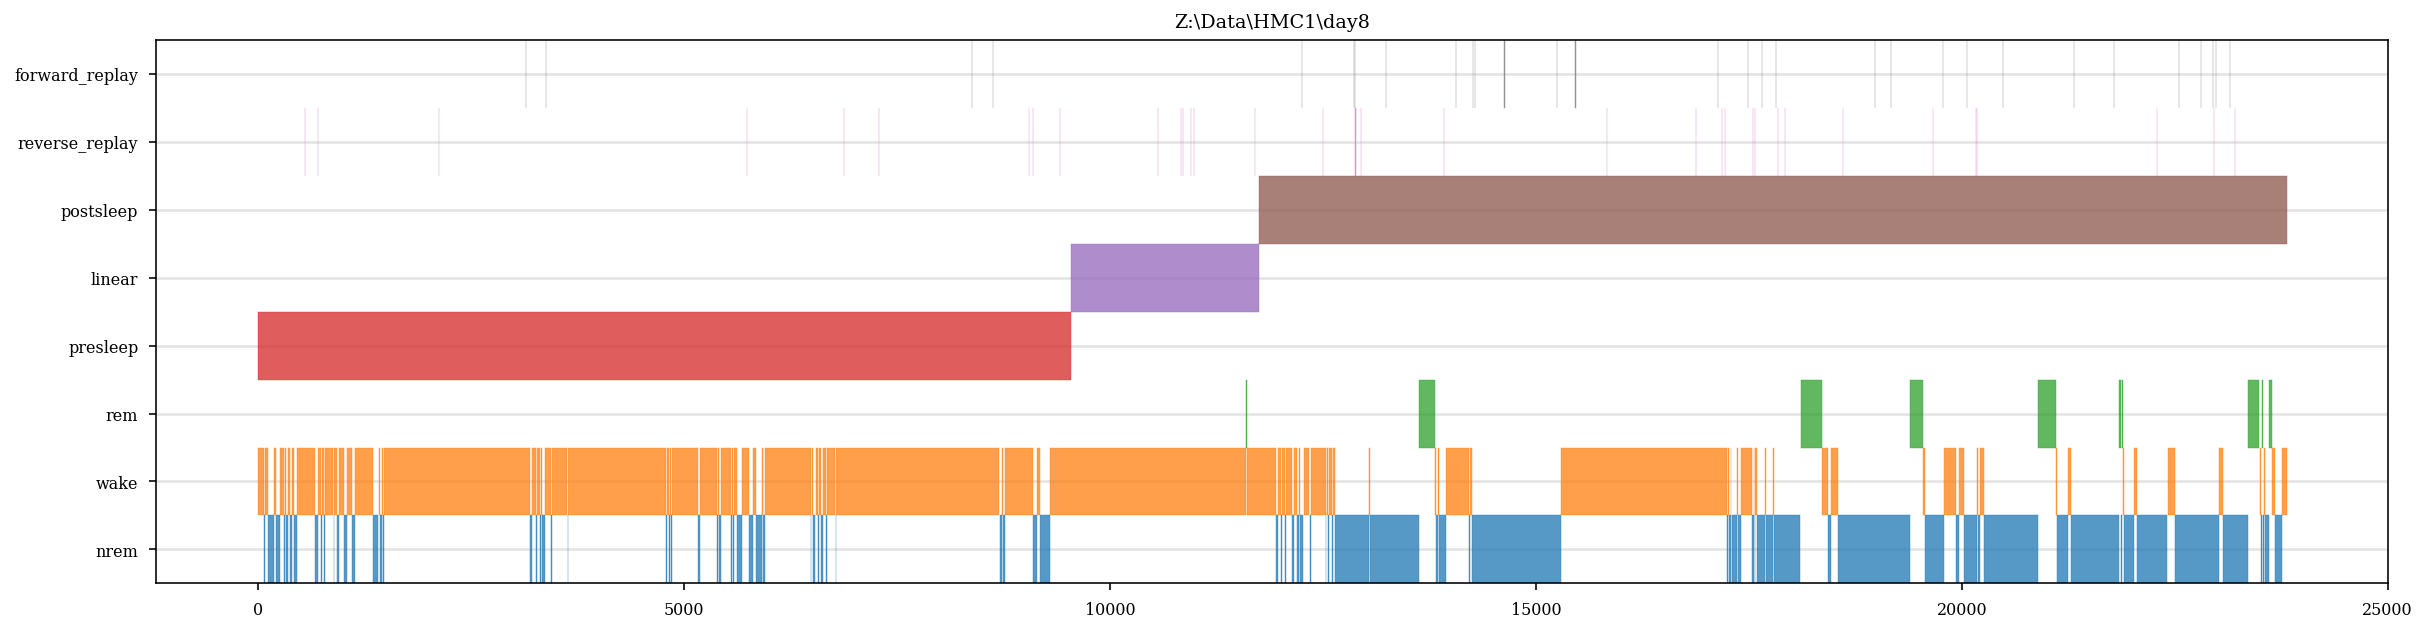

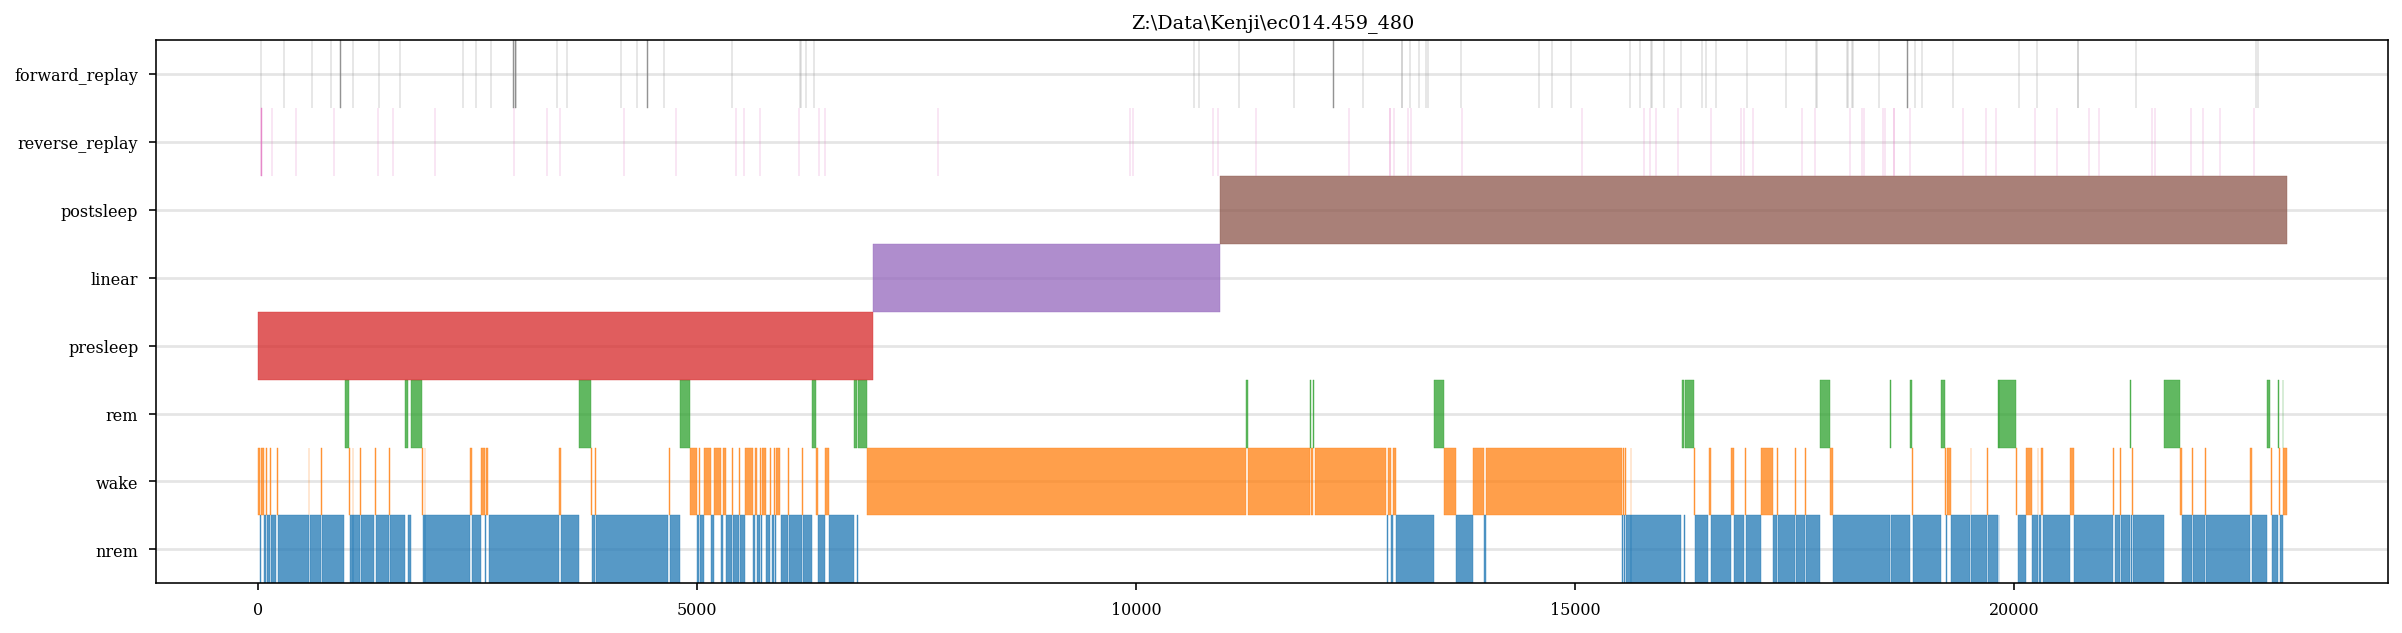

In [101]:
import custom_plots

sessions = glob.glob(save_path + os.sep + '*.pkl')
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)
    try:
        events, labels = gather_events(
            results['outbound_epochs']['df'].basepath.unique()[0])
        basepath = results['outbound_epochs']['df'].basepath.unique()[0]
    except:
        events, labels = gather_events(
            results['inbound_epochs']['df'].basepath.unique()[0])
        basepath = results['inbound_epochs']['df'].basepath.unique()[0]

    plt.figure(figsize=(20, 5))
    custom_plots.plot_events(events, labels)
    plt.title(basepath)


## Find individual examples

In [35]:
idxs = np.where((results['df']['score_pval_col_cycle'] < 0.05) &
                (results['df']['score_pval_time_swap'] < 0.05) &
                (results['df']['n_active'] > 5) &
                (results['df']['inactive_bin_prop'] < .2))[0]


In [79]:
# test = results['bst_placecells'][idx]
# # results['sta_placecells']
# test.bin_centers

any(results['df']['replay_type'] == np.nan)


False

In [4]:
sessions = glob.glob(save_path + os.sep + '*.pkl')

with open(sessions[0], 'rb') as f:
    results = pickle.load(f)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


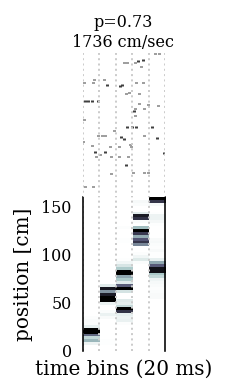

In [98]:

idxs = np.where((results['df']['score_pval_col_cycle'] < 0.05) &
                (results['df']['score_pval_time_swap'] < 0.05) &
                (results['df']['n_active'] > 5) &
                (results['df']['inactive_bin_prop'] < .2))[0]
idx = idxs[2]
idx = int(idx)
if isinstance(idx, int):
    title = "p={:.2f}\n{:.0f} cm/sec".format(
        results['df'].trajectory_score.iloc[idx], results['df'].traj_speed.iloc[idx])
else:
    title = ""
ax = replay_fig.plot_all_replay(results['bst_placecells'][idx],
                                results['sta_placecells'],
                                results['tc'],
                                results['tc'],
                                vmax=.1,
                                title_str=title)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


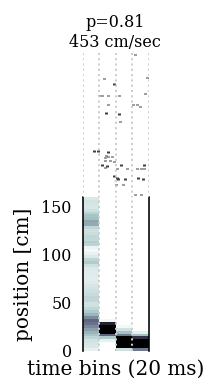

reverse


In [44]:
idxs = np.where((results['df']['replay_type'] == 'reverse') & (results['df']['score_pval_col_cycle'] < 0.05) &
                (results['df']['score_pval_time_swap'] < 0.05) &
                (results['df']['n_active'] > 5) &
                (results['df']['inactive_bin_prop'] < .2))[0]
idx = idxs[1]
idx = int(idx)
if isinstance(idx, int):
    title = "p={:.2f}\n{:.0f} cm/sec".format(
        results['df'].trajectory_score.iloc[idx], results['df'].traj_speed.iloc[idx])
else:
    title = ""
ax = replay_fig.plot_all_replay(results['bst_placecells'][idx],
                                results['sta_placecells'],
                                results['tc'],
                                results['tc'],
                                vmax=.1,
                                title_str=title)

print(results['df'].replay_type.iloc[idx])


In [50]:
# results['df'].replay_type


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


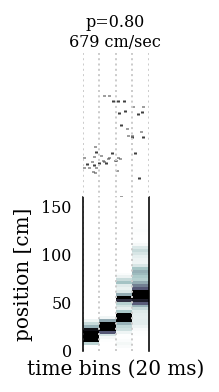

forward


In [45]:
idxs = np.where((results['df']['score_pval_col_cycle'] < 0.05) &
                (results['df']['score_pval_time_swap'] < 0.05) &
                (results['df']['n_active'] > 5) &
                (results['df']['inactive_bin_prop'] < .2))[0]
idx = idxs[31]
idx = int(idx)
if isinstance(idx, int):
    title = "p={:.2f}\n{:.0f} cm/sec".format(
        results['df'].trajectory_score.iloc[idx], results['df'].traj_speed.iloc[idx])
else:
    title = ""
ax = replay_fig.plot_all_replay(results['bst_placecells'][idx],
                                results['sta_placecells'],
                                results['tc'],
                                results['tc'],
                                vmax=.1,
                                title_str=title)

print(results['df'].replay_type.iloc[idx])


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


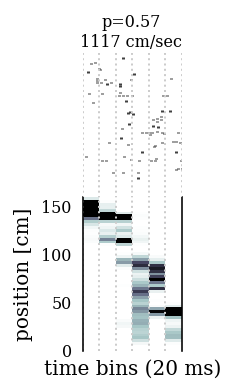

forward


In [46]:
idxs = np.where((results['df']['score_pval_col_cycle'] < 0.05) &
                (results['df']['score_pval_time_swap'] < 0.05) &
                (results['df']['n_active'] > 5) &
                (results['df']['inactive_bin_prop'] < .2))[0]
idx = idxs[29]
idx = int(idx)
if isinstance(idx, int):
    title = "p={:.2f}\n{:.0f} cm/sec".format(
        results['df'].trajectory_score.iloc[idx], results['df'].traj_speed.iloc[idx])
else:
    title = ""
ax = replay_fig.plot_all_replay(results['bst_placecells'][idx],
                                results['sta_placecells'],
                                results['tc'],
                                results['tc'],
                                vmax=.1,
                                title_str=title)

print(results['df'].replay_type.iloc[idx])


In [50]:
idxs = np.where((results['df']['score_pval_col_cycle'] < 0.05) &
                (results['df']['score_pval_time_swap'] < 0.05) &
                (results['df']['n_active'] > 5) &
                (results['df']['inactive_bin_prop'] < .2))[0]
idx = (
    (results['df']['score_pval_col_cycle'] < 0.05) &
    (results['df']['score_pval_time_swap'] < 0.05)
)
results['df'][idx]


start        stop       peaks   amplitude  duration   frequency  \
24        47.6952     47.8432     47.7912  851.758590    0.1480  161.080797   
227      862.1312    862.2456    862.1608  850.904118    0.1144  192.164774   
228      862.1312    862.2456    862.1608  850.904118    0.1144  192.164774   
261      960.9256    961.0640    960.9712  690.977610    0.1384  173.337576   
539     2095.3560   2095.4424   2095.4232  378.692609    0.0864  176.284368   
...           ...         ...         ...         ...       ...         ...   
10845  33345.9768  33346.1384  33346.0552  686.269406    0.1616  161.658598   
10901  33636.1368  33636.2920  33636.2184  707.100262    0.1552  166.927743   
10902  33636.1368  33636.2920  33636.2184  707.100262    0.1552  166.927743   
11108  34270.2720  34270.4184  34270.2928  895.957985    0.1464  184.415552   
11196  34428.1976  34428.3112  34428.2496  423.913874    0.1136  131.641087   

       detectorName  ripple_channel  event_spk_thres  \
24     bz_DetectSWR              76                1   
227    bz_DetectSWR              76                1   
228    bz_DetectSWR              76                1   
261    bz_DetectSWR              76                1   
539    bz_DetectSWR              76                1   
...             ...             ...              ...   
10845  bz_DetectSWR              76                1   
10901  bz_DetectSWR              76                1   
10902  bz_DetectSWR              76                1   
11108  bz_DetectSWR              76                1   
11196  bz_DetectSWR              76                1   

                                            basepath  ...      slope  \
24     Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ... -18.328841   
227    Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ...  34.716981   
228    Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ...  34.716981   
261    Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ... -10.954178   
539    Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ... -23.245283   
...                                              ...  ...        ...   
10845  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ...  14.159928   
10901  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ... -18.652291   
10902  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ... -18.652291   
11108  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ... -23.180593   
11196  Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  ...   8.452830   

           intercept  score_pval_time_swap  score_pval_col_cycle   traj_dist  \
24        276.010782              0.001999              0.009993  109.973046   
227     -3978.566038              0.019320              0.006662  138.867925   
228     -4152.150943              0.013324              0.007328  138.867925   
261      1570.875112              0.027981              0.035310   54.770889   
539      6386.113208              0.041306              0.041972   69.735849   
...              ...                   ...                   ...         ...   
10845 -146645.283019              0.007995              0.016656   99.119497   
10901  194103.935310              0.001999              0.003331  111.913747   
10902  194234.501348              0.001999              0.001999  111.913747   
11108  244448.625337              0.000666              0.005996  139.083558   
11196  -89476.830189              0.019987              0.005996   33.811321   

        traj_speed  traj_step  replay_type  dist_rat_start  dist_rat_end  
24      916.442049  18.328841          NaN             NaN           NaN  
227    1735.849057  34.716981          NaN             NaN           NaN  
228    1735.849057  34.716981          NaN             NaN           NaN  
261     547.708895  10.954178          NaN             NaN           NaN  
539    1162.264151  23.245283          NaN             NaN           NaN  
...            ...        ...          ...             ...           ...  
10845   707.996406  14.159928          

In [200]:
import warnings
warnings.filterwarnings("ignore")

idxs = np.where((results['df']['score_pval_col_cycle'] < 0.05))[0]

for idx in idxs:
    idx = int(idx)
    if isinstance(idx, int):
        title = "p={:.2f}\n{:.0f} cm/sec".format(
            results['df'].trajectory_score.iloc[idx], results['df'].traj_speed.iloc[idx])
    else:
        title = ""
    ax, fig = replay_fig.plot_all_replay(results['bst_placecells'][idx],
                                         results['sta_placecells'],
                                         results['tc'],
                                         results['tc'],
                                         vmax=.1,
                                         title_str=title)
    fig.savefig(os.path.join(fig_save_path, 'replay_examples',
                str(idx)+'_.png'), dpi=300, bbox_inches='tight')
    plt.close(fig)


In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nelpy.plotting as npl
import nelpy as nel


def plot_all_PBEs(bst, spiketrainarray, tuningcurve, tc_placecells, idx=None, title_str=None, vmax=.1):
    if idx is not None:
        bst = bst[idx]
    st = spiketrainarray
    tc = tuningcurve
    tc_placecells = tc_placecells

    no = tc_placecells.get_peak_firing_order_ids()
    st.reorder_units_by_ids(no, inplace=True)

    st_cut = st[bst.support]
    st_cut._support = bst.support  # hacky fix so that we can plot events out of order
    st_cut = nel.utils.collapse_time(st_cut)

    # decode neural activity
    posterior, bdries, mode_pth, mean_pth = nel.decoding.decode1D(
        bst=bst, ratemap=tc, xmax=120)

    width, height = functions.set_size('thesis', fraction=.25, subplots=(3, 1))

#     with npl.FigureManager(show=True, figsize=(0.2*bst.n_bins,4)) as (fig, ax):
    with npl.FigureManager(show=True, figsize=(width*bst.n_bins*.1, height)) as (fig, ax):

        npl.utils.skip_if_no_output(fig)

        pixel_width = 0.5
        if vmax == False:
            npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(
                121), data=posterior, cmap=plt.cm.bone_r, ax=ax, rasterized=True)
        else:
            npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(
                121), data=posterior, cmap=plt.cm.bone_r, ax=ax, vmax=vmax, rasterized=True)
#         npl.utils.yticks_interval(310)
        npl.utils.no_yticks(ax)
        # plt.imshow(posterior, cmap=plt.cm.Spectral_r, interpolation='none', aspect='auto')
        ax.vlines(np.arange(bst.lengths.sum())-pixel_width, *
                  ax.get_ylim(), lw=1, linestyle=':', color='0.8')
        ax.vlines(np.cumsum(bst.lengths)-pixel_width, *ax.get_ylim(), lw=1)

        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)

        event_centers = np.insert(np.cumsum(bst.lengths), 0, 0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks(event_centers)
        if idx is not None:
            ax.set_xticklabels(idx)
        else:
            ax.set_xticklabels(np.arange(bst.n_epochs))

        npl.utils.no_xticks(ax)
#         npl.utils.clear_left_right(ax)
        npl.utils.clear_top_bottom(ax)

        divider = make_axes_locatable(ax)
        axRaster = divider.append_axes("top", size=1, pad=0)

        npl.rasterplot(st_cut, vertstack=True, ax=axRaster, lh=1.25)
        axRaster.set_xlim(st_cut.support.time.squeeze())
        bin_edges = np.linspace(
            st_cut.support.time[0, 0], st_cut.support.time[0, 1], bst.n_bins+1)
        axRaster.vlines(bin_edges, *ax.get_ylim(), lw=1,
                        linestyle=':', color='0.8', zorder=-1000)
#         axRaster.vlines(bin_edges[np.cumsum(bst.lengths)], *ax.get_ylim(), lw=1, color='0.2')
        npl.utils.no_xticks(axRaster)
        npl.utils.no_xticklabels(axRaster)
        npl.utils.no_yticklabels(axRaster)
        npl.utils.no_yticks(axRaster)
        ax.set_ylabel('position [cm]')
        ax.set_xlabel('time bins (20 ms)')
        if title_str:
            fig.suptitle(title_str, fontsize=8)
        npl.utils.clear_left_right(axRaster)
#         npl.utils.clear_right(axRaster)
        npl.utils.clear_top_bottom(axRaster)
    return ax, fig
